# GENERAL DESCRIPTION

The aim of this work is to build machine learning models for predicting the daily mean level of PM10 in Italy in 2020. 
Both air quality data and meteorological data will be taken into account.

The data will be processed several times, with different techniques, in order to find the best features and the best dataset. This search is performed with an incremental approach, effectuating a sequence of steps. At each step, several processing alternatives are built and evaluated: the best alternative is then selected and, if his addition on the current dataset does improve the performance, that new feature is added.

Practically speaking, each dataset is evaluated by building a machine learning model on it. For each dataset, four different models are taken into account: each of them is evaluated testing all the possible combinations of some hyperparameters in an exhaustive way. The following list is the list of the four models, with the associated grid of hyperparameters to test.

In [ ]:
model_paramGrid_list = [ 
                         ("kNN", KNeighborsRegressor(), {"n_neighbors":range(1,45), "weights":["uniform","distance"]}),
                         ("DT", DecisionTreeRegressor(), {"max_leaf_nodes":range(2,51), "max_features":[None,"sqrt"]}),
                         ("PR", PolynomialRegression(), {"degree":[1,2,3,4]}),
                         ("RF", RandomForestRegressor(), {"n_estimators":range(1,51), "max_features":[None,"sqrt"]})
                       ]

In the end, the best dataset and the best model are selected (i.e. the best couple dataset-model is selected).

The evaluating measure used during this incremental selection is the MSE cross validation score, which is an error measure: this means that the best couple dataset-model is the one which has associated the minimum validation score.

## Prerequisites

The [EEA-datasets-handler](https://github.com/EnricoPittini/EEA-datasets-handler) library will be used in order to acquire and handle the EEA air pollution datasets.

The [timeSeries-processing](https://github.com/EnricoPittini/timeSeries-processing) library will be used in order to process the time series datasets.

Finally, the [model-selection](https://github.com/EnricoPittini/model-selection) library will be used in order to evaluate the machine learning models.

In [1]:
import EEA_datasets_handler as eea
import timeSeries_processing as tsp 
import model_selection as ms

**Acquire the EEA air pollution datasets of PM10 in Italy in 2020.**

In [ ]:
# Download the datasets 
# IT'S NECESSARY ONLY IF THEY HAVEN'T BEEN DOWNLOADED YET
dest_path = "C:\\Datasets"
countries_cities_dict = {"IT": "all"} 
pollutants = ["PM10"] 
years = [2020]
eea.download_datasets(dest_path, countries_cities_dict, pollutants, years)

In [2]:
# Load the datasets
source_path = "C:\\Datasets\\EEA"
countries_cities_dict = {"IT":"all"}
pollutants = ["PM10"]
years = [2020]
df = eea.load_datasets(source_path, countries_cities_dict, pollutants, years)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158282 entries, 0 to 158281
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Countrycode               158282 non-null  object 
 1   Namespace                 158282 non-null  object 
 2   AirQualityNetwork         158282 non-null  object 
 3   AirQualityStation         158282 non-null  object 
 4   AirQualityStationEoICode  158282 non-null  object 
 5   SamplingPoint             158282 non-null  object 
 6   SamplingProcess           158282 non-null  object 
 7   Sample                    158207 non-null  object 
 8   AirPollutant              158282 non-null  object 
 9   AirPollutantCode          158282 non-null  object 
 10  AveragingTime             158282 non-null  object 
 11  Concentration             133256 non-null  float64
 12  UnitOfMeasurement         158282 non-null  object 
 13  DatetimeBegin             158282 non-null  o

Countrycode     Namespace AirQualityNetwork AirQualityStation  \
0               IT  IT.ISPRA.AQD        NET.IT224A       STA.IT1523A   
1               IT  IT.ISPRA.AQD        NET.IT224A       STA.IT1523A   
2               IT  IT.ISPRA.AQD        NET.IT224A       STA.IT1523A   
3               IT  IT.ISPRA.AQD        NET.IT224A       STA.IT1523A   
4               IT  IT.ISPRA.AQD        NET.IT224A       STA.IT1523A   
...            ...           ...               ...               ...   
158277          IT  IT.ISPRA.AQD        NET.IT100A       STA.IT2079A   
158278          IT  IT.ISPRA.AQD        NET.IT100A       STA.IT2079A   
158279          IT  IT.ISPRA.AQD        NET.IT100A       STA.IT2079A   
158280          IT  IT.ISPRA.AQD        NET.IT100A       STA.IT2079A   
158281          IT  IT.ISPRA.AQD        NET.IT100A       STA.IT2079A   

       AirQualityStationEoICode                           SamplingPoint  \
0                       IT1523A  SPO.IT1523A_5_BETA_2005-04-20_00:00:00   
1                       IT1523A  SPO.IT1523A_5_BETA_2005-04-20_00:00:00   
2                       IT1523A  SPO.IT1523A_5_BETA_2005-04-20_00:00:00   
3                       IT1523A  SPO.IT1523A_5_BETA_2005-04-20_00:00:00   
4                       IT1523A  SPO.IT1523A_5_BETA_2005-04-20_00:00:00   
...                         ...                                     ...   
158277                  IT2079A  SPO.IT2079A_5_BETA_2009-07-23_00:00:00   
158278                  IT2079A  SPO.IT2079A_5_BETA_2009-07-23_00:00:00   
158279                  IT2079A  SPO.IT2079A_5_BETA_2009-07-23_00:00:00   
158280                  IT2079A  SPO.IT2079A_5_BETA_2009-07-23_00:00:00   
158281                  IT2079A  SPO.IT2079A_5_BETA_2009-07-23_00:00:00   

                               SamplingProcess  \
0       SPP.IT1523A_5_BETA_2005-04-20_00:00:00   
1       SPP.IT1523A_5_BETA_2005-04-20_00:00:00   
2       SPP.IT1523A_5_BETA_2005-04-20_00:00:00   
3       SPP.IT1523A_5_BETA_2005-04-20_00:00:00   
4       SPP.IT1523A_5_BETA_2005-04-20_00:00:00   
...                                        ...   
158277  SPP.IT2079A_5_BETA_2009-07-23_00:00:00   
158278  SPP.IT2079A_5_BETA_2009-07-23_00:00:00   
158279  SPP.IT2079A_5_BETA_2009-07-23_00:00:00   
158280  SPP.IT2079A_5_BETA_2009-07-23_00:00:00   
158281  SPP.IT2079A_5_BETA_2009-07-23_00:00:00   

                                        Sample AirPollutant  \
0       SAM.IT1523A_5_BETA_2005-04-20_00:00:00         PM10   
1       SAM.IT1523A_5_BETA_2005-04-20_00:00:00         PM10   
2       SAM.IT1523A_5_BETA_2005-04-20_00:00:00         PM10   
3       SAM.IT1523A_5_BETA_2005-04-20_00:00:00         PM10   
4       SAM.IT1523A_5_BETA_2005-04-20_00:00:00         PM10   
...                                        ...          ...   
158277  SAM.IT2079A_5_BETA_2009-07-23_00:00:00         PM10   
158278  SAM.IT2079A_5_BETA_2009-07-23_00:00:00         PM10   
158279  SAM.IT2079A_5_BETA_2009-07-23_00:00:00         PM10   
158280  SAM.IT2079A_5_BETA_2009-07-23_00:00:00         PM10   
158281  SAM.IT2079A_5_BETA_2009-07-23_00:00:00         PM10   

                                         AirPollutantCode AveragingTime  \
0       http://dd.eionet.europa.eu/vocabulary/aq/pollu...           day   
1       http://dd.eionet.europa.eu/vocabulary/aq/pollu...           day   
2       http://dd.eionet.europa.eu/vocabulary/aq/pollu...           day   
3       http://dd.eionet.europa.eu/vocabulary/aq/pollu...           day   
4       http://dd.eionet.europa.eu/vocabulary/aq/pollu...           day   
...                                                   ...           ...   
158277  http://dd.eionet.europa.eu/vocabulary/aq/pollu...           day   
158278  http://dd.eionet.europa.eu/vocabulary/aq/pollu...           day   
158279  http://dd.eionet.europa.eu/vocabulary/aq/pollu...           day   
158280  http://dd.eionet.europa.eu/vocabulary/aq/pollu...           day   
158281  http://dd.eionet.europa.eu/vocabulary/aq/pollu... 

*`df` is a raw DataFrame, which simply contains the measurements: these are not grouped by day and are not cleaned properly.*

**Acquire the EEA air pollution datasets of PM10 in Italy in all the supported year (i.e. 2013-2020).** 

In [ ]:
# Download the datasets 
# IT'S NECESSARY ONLY IF THEY HAVEN'T BEEN DOWNLOADED YET
dest_path = "C:\\Datasets"
countries_cities_dict = {"IT": "all"} 
pollutants = ["PM10"] 
years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
eea.download_datasets(dest_path, countries_cities_dict, pollutants, years)

In [3]:
source_path = "C:\\Datasets\\EEA"
countries_cities_dict = {"IT":"all"}
pollutants = ["PM10"]
years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020] 
df_full = eea.load_datasets(source_path, countries_cities_dict, pollutants, years)
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2281472 entries, 0 to 2281471
Data columns (total 17 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Countrycode               object 
 1   Namespace                 object 
 2   AirQualityNetwork         object 
 3   AirQualityStation         object 
 4   AirQualityStationEoICode  object 
 5   SamplingPoint             object 
 6   SamplingProcess           object 
 7   Sample                    object 
 8   AirPollutant              object 
 9   AirPollutantCode          object 
 10  AveragingTime             object 
 11  Concentration             float64
 12  UnitOfMeasurement         object 
 13  DatetimeBegin             object 
 14  DatetimeEnd               object 
 15  Validity                  int64  
 16  Verification              int64  
dtypes: float64(1), int64(2), object(14)
memory usage: 295.9+ MB


*`df_full` is a raw DataFrame, which simply contains the measurements: these are not grouped by day and are not cleaned properly.*

In addition, also a meteorological  dataset will be used (i.e. `meteorological_data_2020`). It will be loaded later on.

These data have been obtained using the [ILMETEO](https://www.ilmeteo.it/) Website.

# PLOTS

Plot of the daily mean concentrations of PM10 in Italy in 2020.

In [38]:
# Process the 2020 DataFrame (with an arbitrary `fill_n_days`)
df_mean, _, _ = eea.preprocessing(df, fill=True, fill_n_days=10 ,fill_aggr="mean")
df_mean

C:\Users\Enrico\anaconda3\lib\site-packages\EEA_datasets_handler.py:806: UserWarning: Missing days: ['2020-01-31', '2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-10', '2020-02-11']
  warnings.warn("Missing days: "+str(list(missing_days.strftime('%Y-%m-%d'))))


mean
Datetime             
2020-01-01  76.974569
2020-01-02  56.675791
2020-01-03  55.216906
2020-01-04  54.887035
2020-01-05  28.192059
...               ...
2020-12-27  14.997987
2020-12-28  16.317778
2020-12-29  23.536875
2020-12-30  22.759021
2020-12-31  22.005000

[366 rows x 1 columns]

<AxesSubplot:title={'center':'Mean concentration of PM10 in Italy in 2020'}, xlabel='Days', ylabel='mean'>

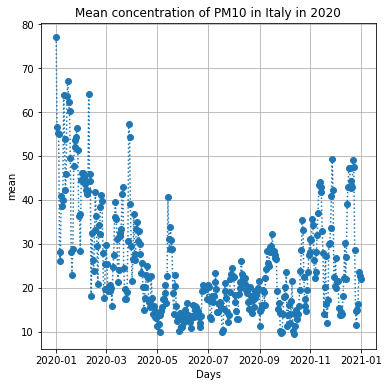

In [39]:
tsp.plot_timeSeries(df_mean, col_name="mean", title="Mean concentration of PM10 in Italy in 2020", figsize=(6,6))

<AxesSubplot:title={'center':'Mean concentration of PM10 in Italy in 2020'}, xlabel='Days', ylabel='mean'>

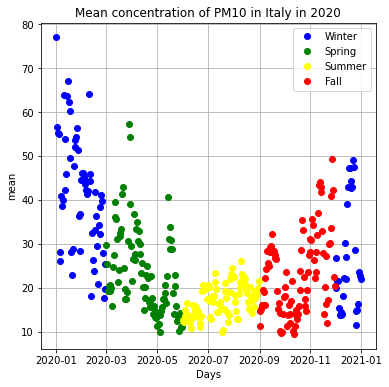

In [40]:
tsp.plot_timeSeries(df_mean, col_name="mean", divide="season", line=False, title="Mean concentration of PM10 in Italy in 2020",
                    figsize=(6,6))

Plot of the daily mean concentrations of PM10 in Italy in all the supported years (2013-2020).

In [41]:
# Process the 2013-2020 DataFrame (with an arbitrary `fill_n_days`)
df_mean_full, _, _ = eea.preprocessing(df_full, fill=True, fill_n_days=10, fill_aggr="mean")
df_mean_full

C:\Users\Enrico\anaconda3\lib\site-packages\EEA_datasets_handler.py:806: UserWarning: Missing days: ['2020-01-31', '2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-10', '2020-02-11']
  warnings.warn("Missing days: "+str(list(missing_days.strftime('%Y-%m-%d'))))


mean
Datetime              
2013-01-01  100.970568
2013-01-02   40.267997
2013-01-03   45.833017
2013-01-04   58.029136
2013-01-05   82.193141
...                ...
2020-12-27   14.997987
2020-12-28   16.317778
2020-12-29   23.536875
2020-12-30   22.759021
2020-12-31   22.005000

[2922 rows x 1 columns]

<AxesSubplot:title={'center':'Mean concentration of PM10 in Italy in 2013-2020'}, xlabel='Days', ylabel='mean'>

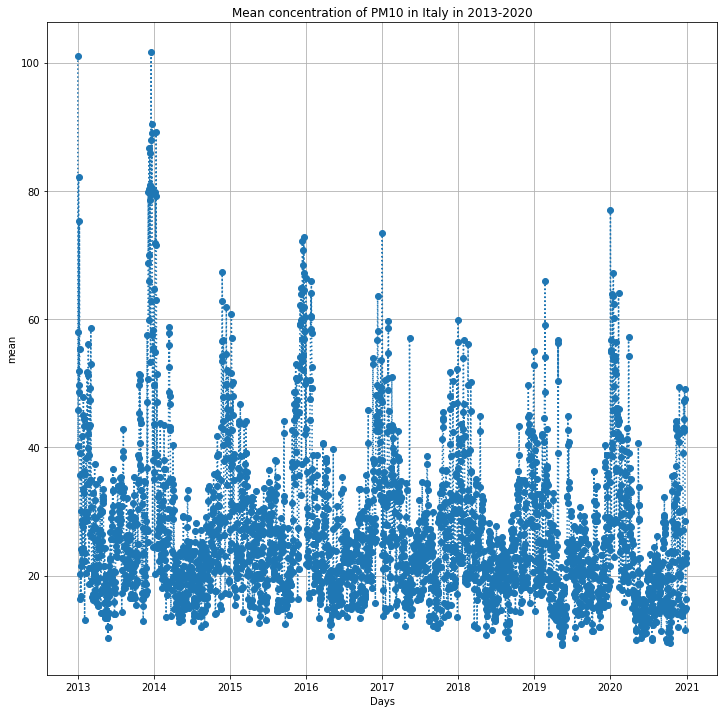

In [42]:
tsp.plot_timeSeries(df_mean_full, col_name="mean", title="Mean concentration of PM10 in Italy in 2013-2020", figsize=(12,12))

<AxesSubplot:title={'center':'Mean concentration of PM10 in Italy in 2013-2020'}, xlabel='Days', ylabel='mean'>

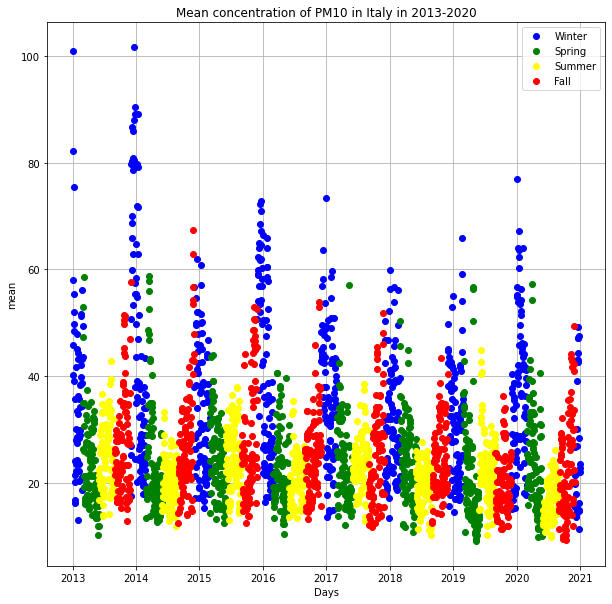

In [43]:
tsp.plot_timeSeries(df_mean_full, col_name="mean", divide="season", line=False,
                    title="Mean concentration of PM10 in Italy in 2013-2020", figsize=(10,10))

Plot of the daily mean concentrations of PM10 in Italy during the years 2018-2020.

In [44]:
df_mean_partial = df_mean_full[df_mean_full.index.map(lambda day: day.year>=2018)]
df_mean_partial

mean
Datetime             
2018-01-01  56.360286
2018-01-02  22.650771
2018-01-03  23.279466
2018-01-04  30.019436
2018-01-05  41.255582
...               ...
2020-12-27  14.997987
2020-12-28  16.317778
2020-12-29  23.536875
2020-12-30  22.759021
2020-12-31  22.005000

[1096 rows x 1 columns]

<AxesSubplot:title={'center':'Mean concentration of PM10 in Italy in 2018-2020'}, xlabel='Days', ylabel='mean'>

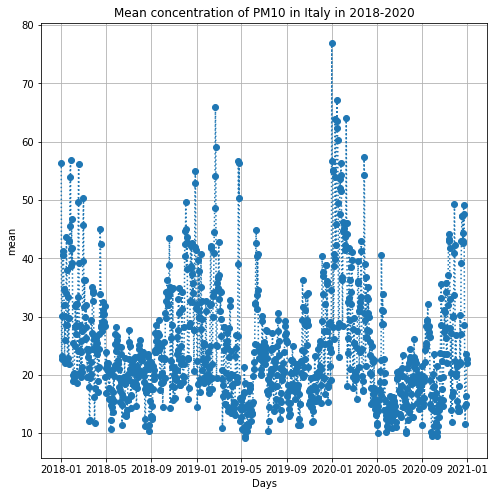

In [45]:
tsp.plot_timeSeries(df_mean_partial, col_name="mean", title="Mean concentration of PM10 in Italy in 2018-2020", figsize=(8,8))

<AxesSubplot:title={'center':'Mean concentration of PM10 in Italy in 2018-2020'}, xlabel='Days', ylabel='mean'>

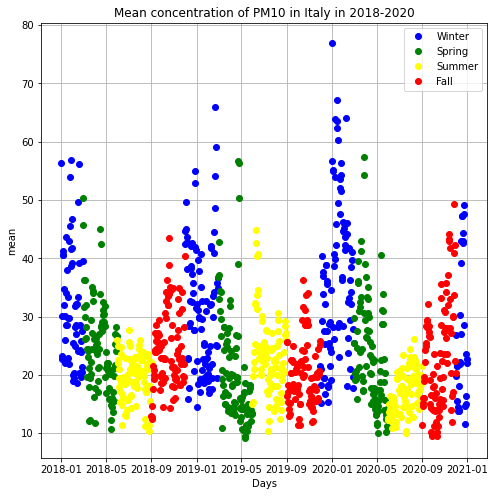

In [46]:
tsp.plot_timeSeries(df_mean_partial, col_name="mean", divide="season", line=False,
                    title="Mean concentration of PM10 in Italy in 2018-2020", figsize=(8,8))

As the plots have shown, the evolution over time of the PM10 concentration is strongly periodic.

# TRIVIAL MODEL

Trivial model, which always predicts using the mean of all the daily mean concentrations of PM10 in all the supported years (2013-2020).

In [21]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Process the 2013-2020 DataFrame (with an arbitrary `fill_n_days`)
df_mean_full,_,_ = eea.preprocessing(df_full, fill=True, fill_n_days=10, fill_aggr="mean")

# Split the DataFrame into X and y: the former contains only the explanatory features, the latter only the response feature.
# To do that the function `tsp.split_X_y` is used.
X,y = tsp.split_X_y(df_mean, y_col="mean", scale_y=True) # Scale the y

# Splitting the dataset into training-validation-test sets, for time series, with proportions 0.6-0.2-0.2
train_len = int(X.shape[0]*(0.6))
val_len = int(X.shape[0]*(0.2))
y_val = y[train_len:train_len+val_len] # Validation set 

y_pred = np.array([np.mean(y) for i in range(val_len)]) # Trivial predictions

val_score =  mean_squared_error(y_true=y_val, y_pred=y_pred)

print("Validation score: "+str(val_score))

C:\Users\Enrico\anaconda3\lib\site-packages\EEA_datasets_handler.py:806: UserWarning: Missing days: ['2020-01-31', '2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-10', '2020-02-11']
  warnings.warn("Missing days: "+str(list(missing_days.strftime('%Y-%m-%d'))))


Validation score: 0.015235327799312809


# FIRST MODELS

## Use `k` days ago to predict the current day

`k` new columns, which contain the daily mean level of PM10 in the `k` preceding days, are added into the 2020 DataFrame.

Two operations have to be made.
1. First of all, the 2020 raw DataFrame `df` needs to be processed and cleaned into a DataFrame containing the daily mean levels of PM10. The function `eea.processing` will be used. In order to do that, a value for the parameter `fill_n_days` has to be chosen (i.e. the number of preceding days used to fill a missing day of the 2020 DataFrame).
2. After that, the function `tsp.add_k_previous_days` can be used, in order to create the `k` new features containing the daily mean level of PM10 in the `k` preceding days. To do so, a value for the parameter `k` has to be chosen.

To sum up, two choices have to be made at the same time: the choice for a specific value for `fill_n_days` and the choice for a  specific value for `k`. 

The value for `fill_n_days` is chosen among the values `[5, 10, 15, "all"]` ("all" means that all the previous days are used to fill a missing day); the value for `k` is chosen among the values `range(3,15)`. All the possible combinations of the couple `fill_n_days`-`k` are evaluated, i.e. an exhaustive selection is made. In the end, the best couple is selected. 

C:\Users\Enrico\anaconda3\lib\site-packages\EEA_datasets_handler.py:806: UserWarning: Missing days: ['2020-01-31', '2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-10', '2020-02-11']
  warnings.warn("Missing days: "+str(list(missing_days.strftime('%Y-%m-%d'))))
C:\Users\Enrico\anaconda3\lib\site-packages\EEA_datasets_handler.py:806: UserWarning: Missing days: ['2020-01-31', '2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-10', '2020-02-11']
  warnings.warn("Missing days: "+str(list(missing_days.strftime('%Y-%m-%d'))))
C:\Users\Enrico\anaconda3\lib\site-packages\EEA_datasets_handler.py:806: UserWarning: Missing days: ['2020-01-31', '2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-10', '2020-02-11']
  warnings.warn("Missing days: "+str(list(missing_days.strftime('%Y-%m-%d')))

C:\Users\Enrico\anaconda3\lib\site-packages\EEA_datasets_handler.py:806: UserWarning: Missing days: ['2020-01-31', '2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-10', '2020-02-11']
  warnings.warn("Missing days: "+str(list(missing_days.strftime('%Y-%m-%d'))))
C:\Users\Enrico\anaconda3\lib\site-packages\EEA_datasets_handler.py:806: UserWarning: Missing days: ['2020-01-31', '2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-10', '2020-02-11']
  warnings.warn("Missing days: "+str(list(missing_days.strftime('%Y-%m-%d'))))
C:\Users\Enrico\anaconda3\lib\site-packages\EEA_datasets_handler.py:806: UserWarning: Missing days: ['2020-01-31', '2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-10', '2020-02-11']
  warnings.warn("Missing days: "+str(list(missing_days.strftime('%Y-%m-%d')))

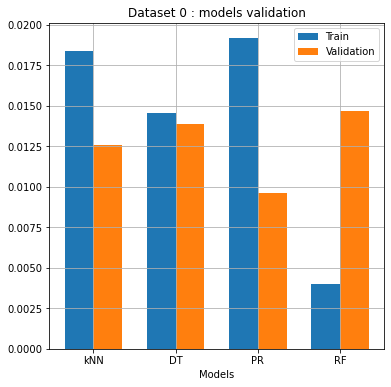

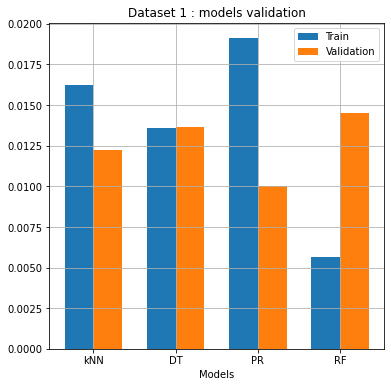

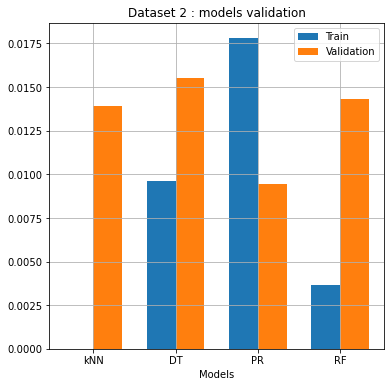

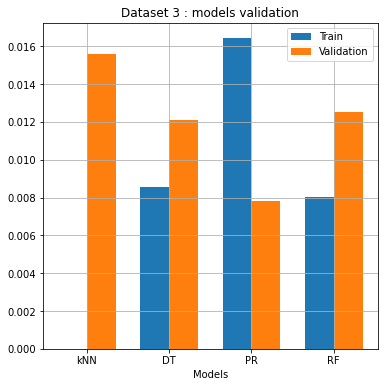

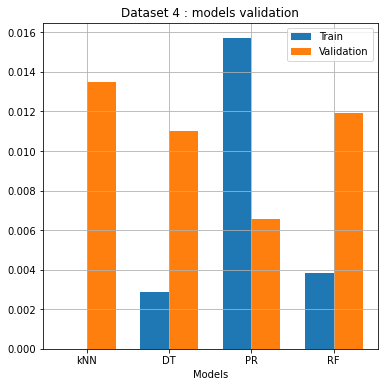

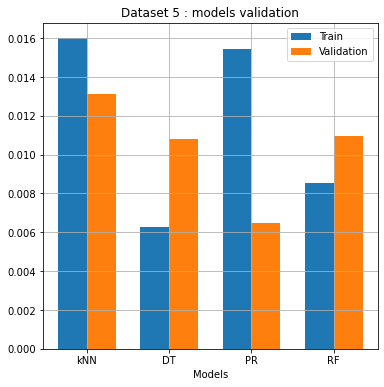

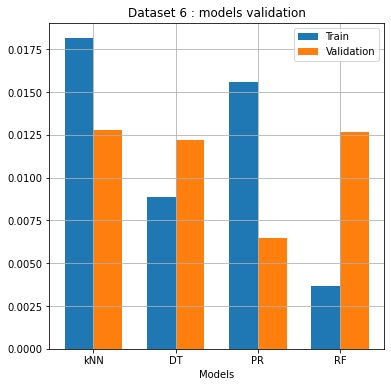

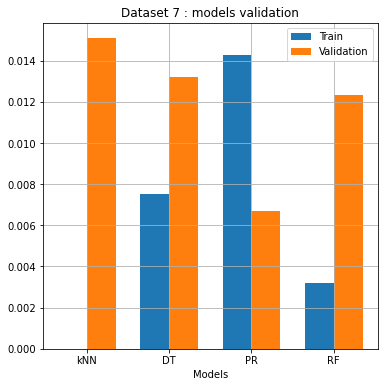

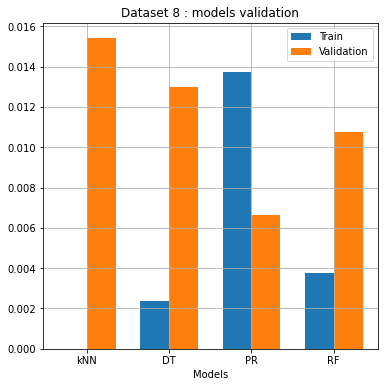

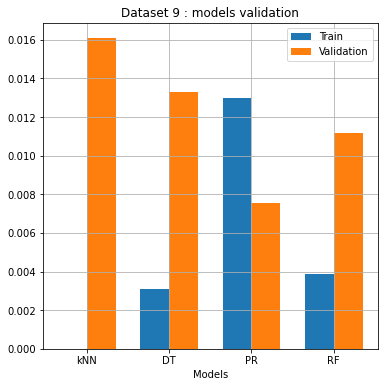

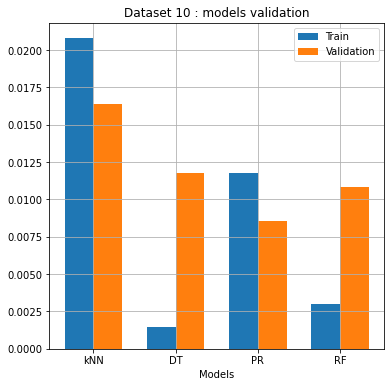

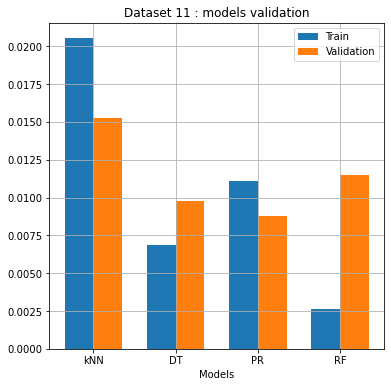

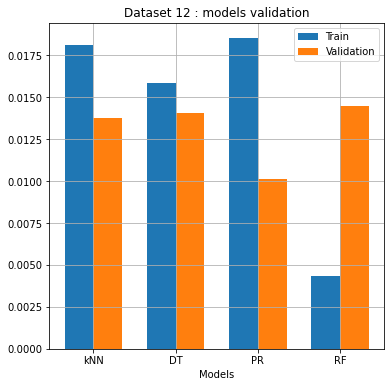

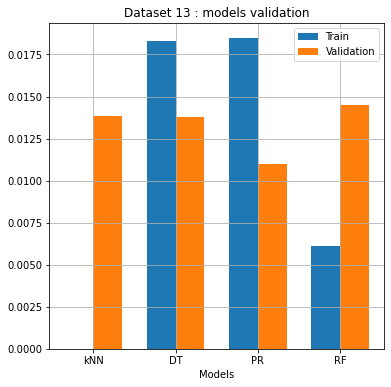

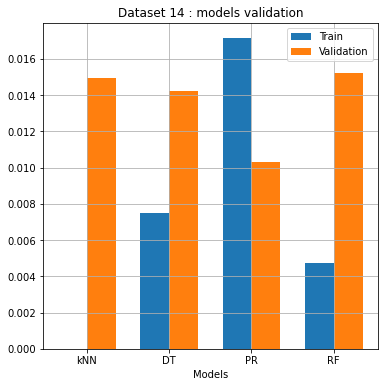

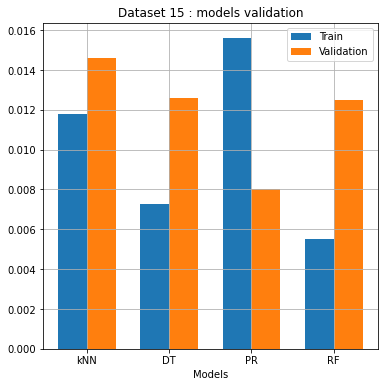

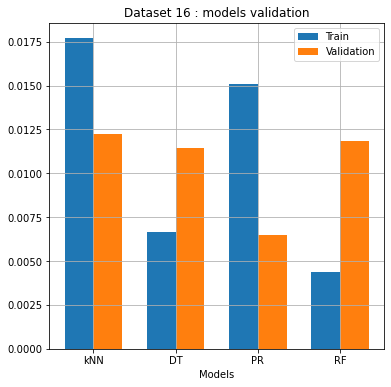

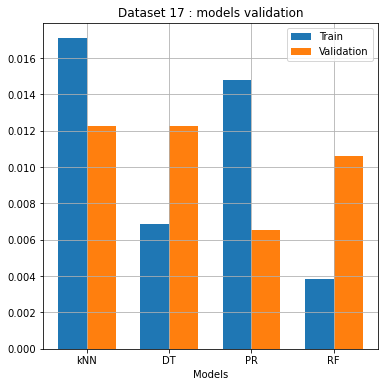

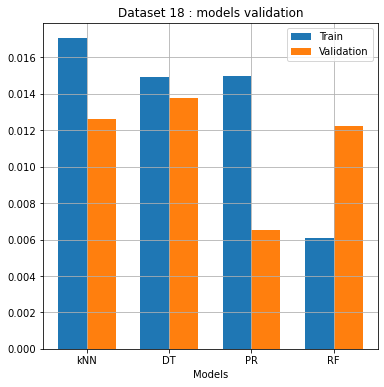

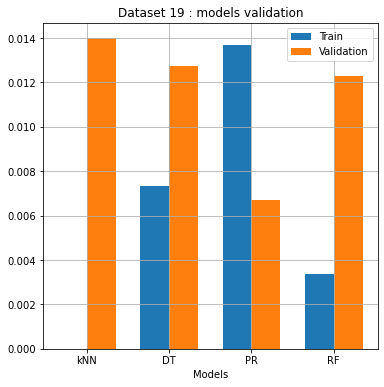

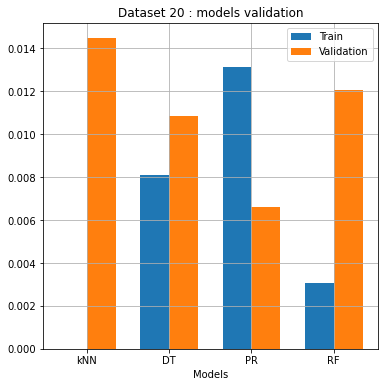

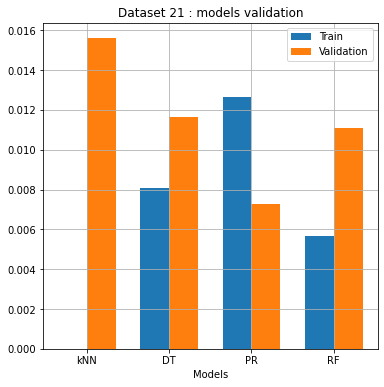

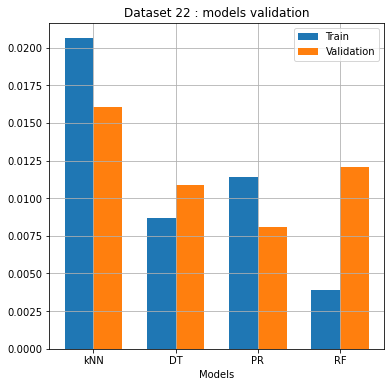

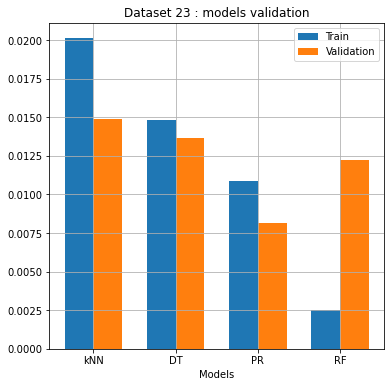

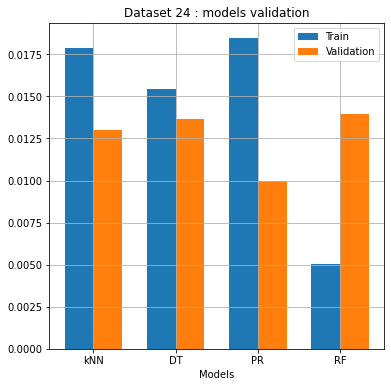

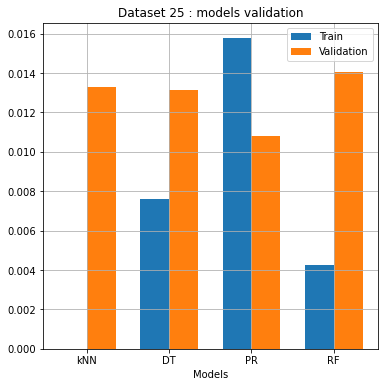

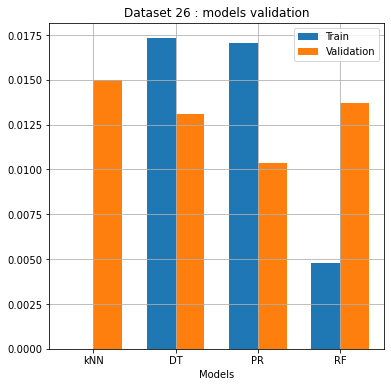

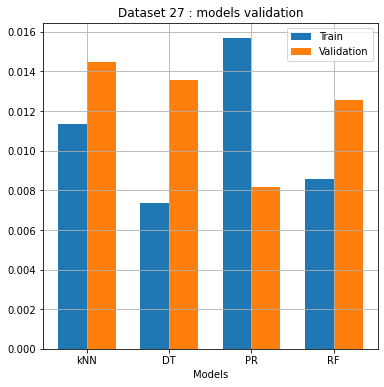

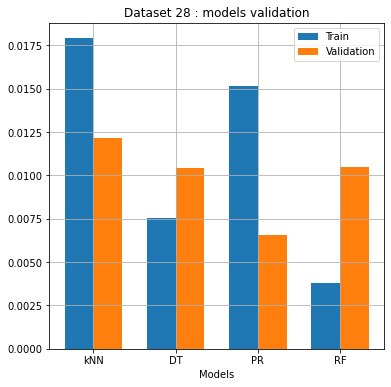

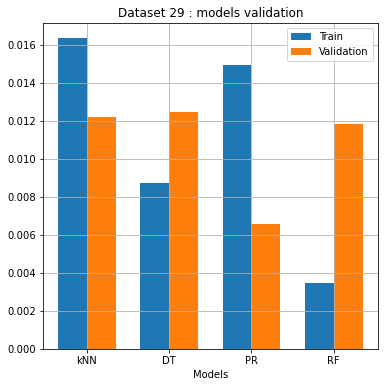

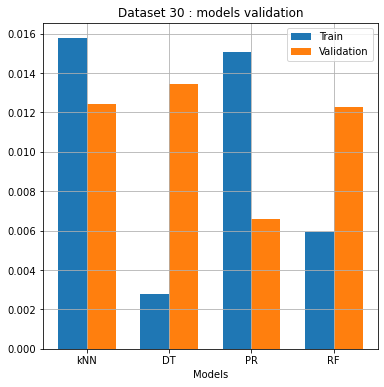

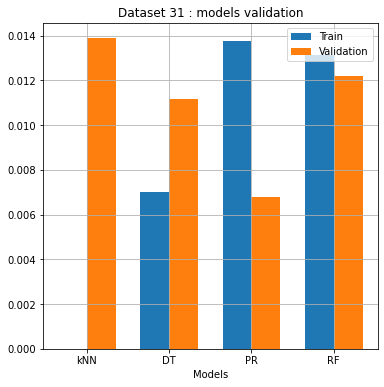

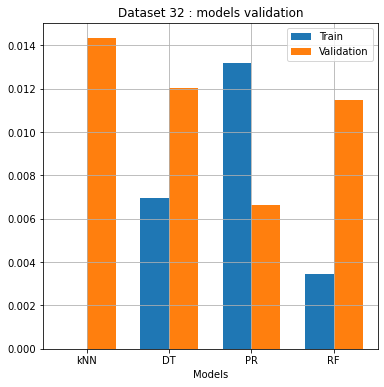

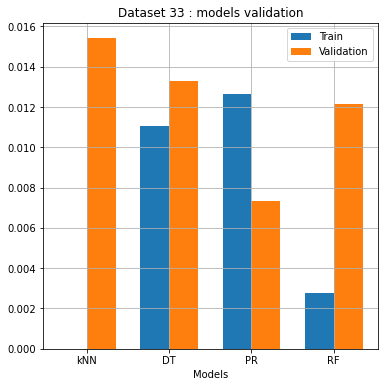

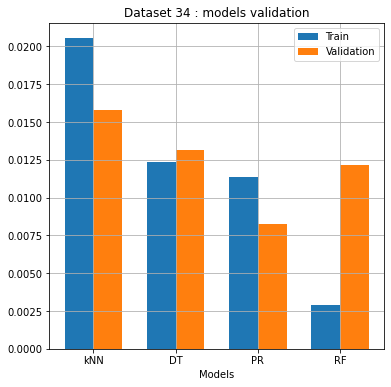

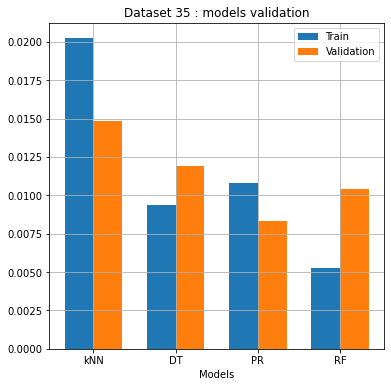

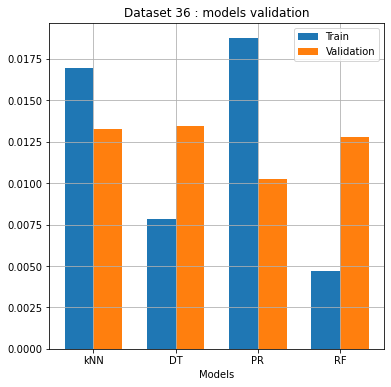

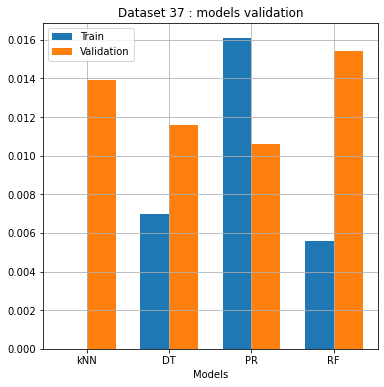

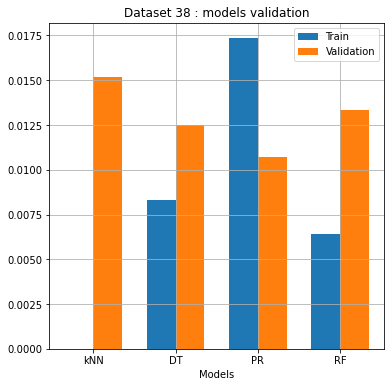

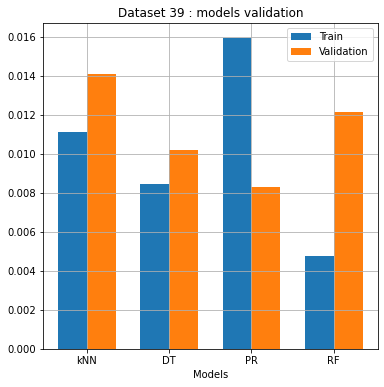

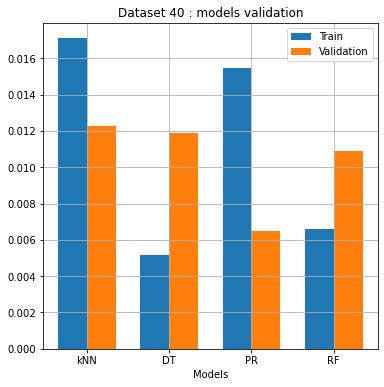

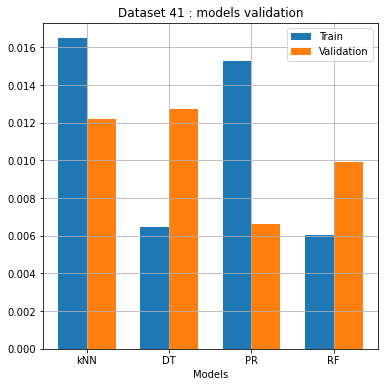

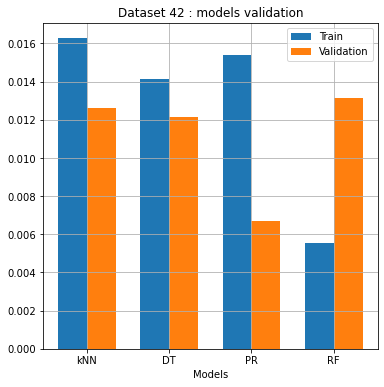

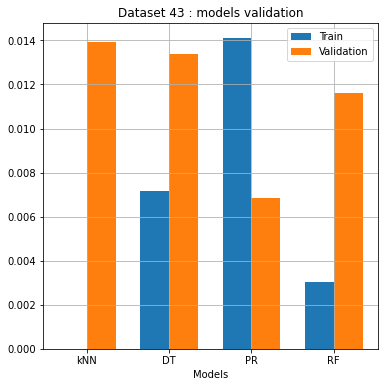

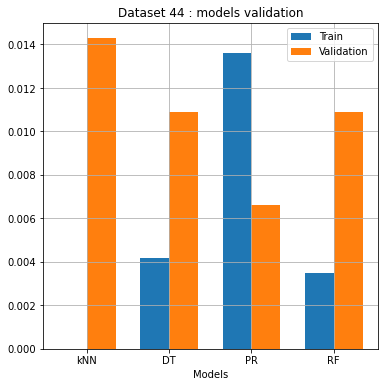

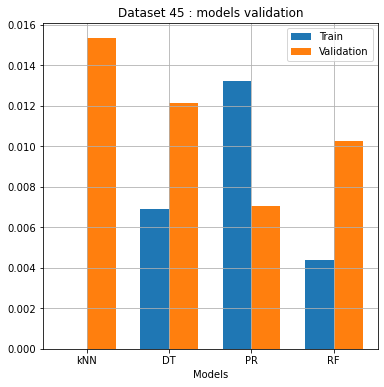

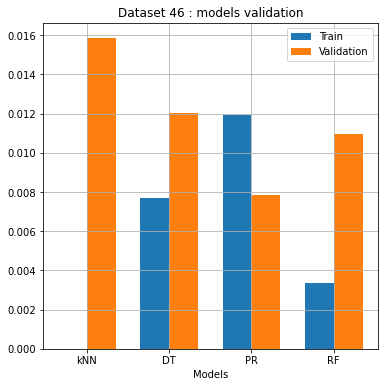

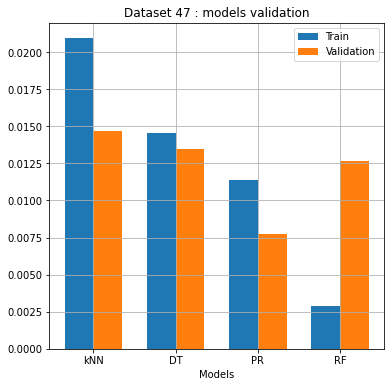

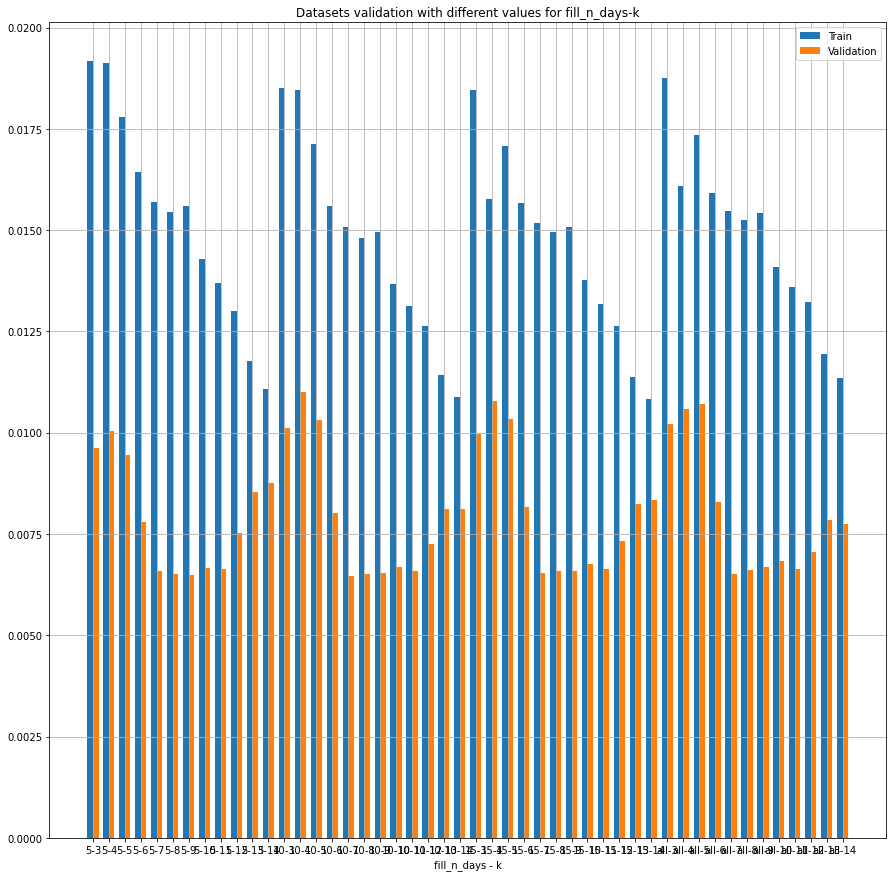

In [22]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

range_fill_n_days = [5, 10, 15, "all"]
range_k = range(3,15)
# All the datasets that have to be evaluated, one for each possible combination of the couple `fill_n_days`-`k`
dataset_list = [tsp.add_k_previous_days(eea.preprocessing(df, fill=True, fill_n_days=fill_n_days ,fill_aggr="mean")[0],
                                        col_name="mean", k=k, y_col="mean", scale_y=True)[1:]
                for fill_n_days in range_fill_n_days for k in range_k]
xvalues = [str(n_days)+"-"+str(k) for n_days in range_fill_n_days for k in range_k]

model_paramGrid_list = [ 
                         ("kNN", KNeighborsRegressor(), {"n_neighbors":range(1,45), "weights":["uniform","distance"]}),
                         ("DT", DecisionTreeRegressor(), {"max_leaf_nodes":range(2,51), "max_features":[None,"sqrt"]}),
                         ("PR", ms.PolynomialRegression(), {"degree":[1,2,3,4]}),
                         ("RF", RandomForestRegressor(), {"n_estimators":range(1,51), "max_features":[None,"sqrt"]})
                       ]
scale_list = [False,True,False,False]

datasets_train_val_score, datasets_best_model, best_index, test_score, axes = ms.datasets_models_validation(dataset_list, 
                                 model_paramGrid_list, scale_list=scale_list, time_series=True, plot=True, plot_train=True, 
                                 xvalues=xvalues, xlabel="fill_n_days - k", 
                                 title="Datasets validation with different values for fill_n_days-k", figsize=(15,15), 
                                 verbose=True)

In [23]:
print("Index best dataset:", str(best_index), "; fill_n_days-k:", xvalues[best_index])
print("Best model:", datasets_best_model[best_index][1], " ; Hyperparameters values:", str(datasets_best_model[best_index][2]))
print("Validation score:", str(datasets_train_val_score[best_index,1]))
print("Test score:", str(test_score))

Index best dataset: 16 ; fill_n_days-k: 10-7
Best model: PR  ; Hyperparameters values: {'degree': 1}
Validation score: 0.00646793271790797
Test score: 0.01319932892982265


Now an example in which the value of `fill_n_days` has been fixed to $10$, in order to show the impact of different values for `k` on the performance.

C:\Users\Enrico\anaconda3\lib\site-packages\EEA_datasets_handler.py:806: UserWarning: Missing days: ['2020-01-31', '2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-10', '2020-02-11']
  warnings.warn("Missing days: "+str(list(missing_days.strftime('%Y-%m-%d'))))
C:\Users\Enrico\anaconda3\lib\site-packages\EEA_datasets_handler.py:806: UserWarning: Missing days: ['2020-01-31', '2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-10', '2020-02-11']
  warnings.warn("Missing days: "+str(list(missing_days.strftime('%Y-%m-%d'))))
C:\Users\Enrico\anaconda3\lib\site-packages\EEA_datasets_handler.py:806: UserWarning: Missing days: ['2020-01-31', '2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-10', '2020-02-11']
  warnings.warn("Missing days: "+str(list(missing_days.strftime('%Y-%m-%d')))

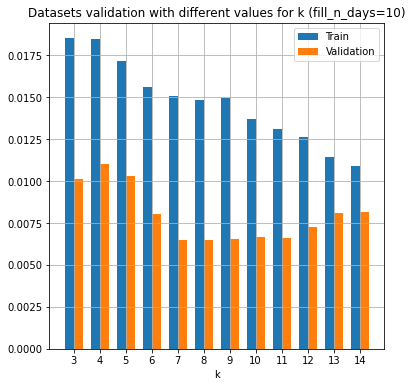

In [24]:
# In this example only the Polynomial Regression model is used
range_k = range(3,15)
dataset_list = [tsp.add_k_previous_days(eea.preprocessing(df, fill=True, fill_n_days=10 ,fill_aggr="mean")[0], col_name="mean",
                                        k=k, y_col="mean", scale_y=True)[1:]  
                for k in range_k]
xvalues = [str(k) for k in range_k]

model = ms.PolynomialRegression()
hyperparameter="degree"
hyperparameter_values=[1,2,3]

(datasets_train_val_score, datasets_best_hyperparameter_value, 
 best_index, test_score, axes) = ms.datasets_hyperparameter_validation(dataset_list, model, hyperparameter, 
                                                       hyperparameter_values, time_series=True, plot=True, plot_train=True, 
                                                       xvalues=xvalues, xlabel="k",
                                                       title="Datasets validation with different values for k (fill_n_days=10)")

**Best dataset: `fill_n_days`=10 and `k`=7**

There has been an improvement as compared to the trivial model: the validation score has decreased from $0.01523$ to $0.00647$.

In [4]:
# Processing with `fill_n_days`=10
df_mean, _, _ = eea.preprocessing(df, fill=True, fill_n_days=10 ,fill_aggr="mean")

C:\Users\Enrico\anaconda3\lib\site-packages\EEA_datasets_handler.py:806: UserWarning: Missing days: ['2020-01-31', '2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-10', '2020-02-11']
  warnings.warn("Missing days: "+str(list(missing_days.strftime('%Y-%m-%d'))))


In [5]:
# `k`=7
df_mean_best, X, y = tsp.add_k_previous_days(df_mean, col_name="mean", k=7, y_col="mean", scale_y=True)

In [6]:
df_mean_best

mean     mean_1     mean_2     mean_3     mean_4     mean_5  \
Datetime                                                                       
2020-01-08  38.646087  40.759729  26.099399  28.192059  54.887035  55.216906   
2020-01-09  39.866008  38.646087  40.759729  26.099399  28.192059  54.887035   
2020-01-10  63.946840  39.866008  38.646087  40.759729  26.099399  28.192059   
2020-01-11  53.902359  63.946840  39.866008  38.646087  40.759729  26.099399   
2020-01-12  42.199734  53.902359  63.946840  39.866008  38.646087  40.759729   
...               ...        ...        ...        ...        ...        ...   
2020-12-27  14.997987  11.480358  14.695619  28.473515  47.568209  49.143828   
2020-12-28  16.317778  14.997987  11.480358  14.695619  28.473515  47.568209   
2020-12-29  23.536875  16.317778  14.997987  11.480358  14.695619  28.473515   
2020-12-30  22.759021  23.536875  16.317778  14.997987  11.480358  14.695619   
2020-12-31  22.005000  22.759021  23.536875  16.317778  14.997987  11.480358   

               mean_6     mean_7  
Datetime                          
2020-01-08  56.675791  76.974569  
2020-01-09  55.216906  56.675791  
2020-01-10  54.887035  55.216906  
2020-01-11  28.192059  54.887035  
2020-01-12  26.099399  28.192059  
...               ...        ...  
2020-12-27  43.004333  42.601218  
2020-12-28  49.143828  43.004333  
2020-12-29  47.568209  49.143828  
2020-12-30  28.473515  47.568209  
2020-12-31  14.695619  28.473515  

[359 rows x 8 columns]

Plots which show the goodness of the predictions.

<AxesSubplot:title={'center':'Actual vs Predicted values'}, xlabel='Days'>

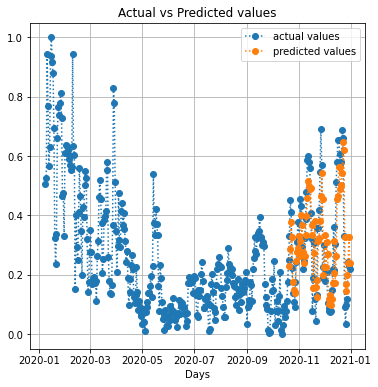

In [28]:
model = ms.PolynomialRegression(degree=1) # Best model

ms.plot_predictions(X ,y ,model, xvalues=df_mean_best.index, xlabel="Days")

<AxesSubplot:title={'center':'Actual vs Predicted values'}, xlabel='Actual values', ylabel='Predicted values'>

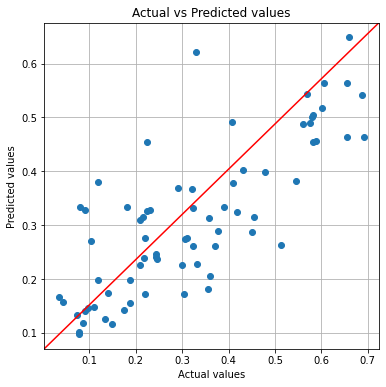

In [29]:
ms.plot_predictions(X ,y ,model, plot_type=1, xvalues=df_mean_best.index, xlabel="Days")

## Add statistical information about up to `k` years ago

Create the full DataFrame (i.e. years 2013-2020) processed and cleaned (using fill_n_days=10).

In [7]:
df_full_mean, _, _ = eea.preprocessing(df_full, fill=True, fill_n_days=10, fill_aggr="mean")

C:\Users\Enrico\anaconda3\lib\site-packages\EEA_datasets_handler.py:806: UserWarning: Missing days: ['2020-01-31', '2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-10', '2020-02-11']
  warnings.warn("Missing days: "+str(list(missing_days.strftime('%Y-%m-%d'))))


A new column is added, containing statistical information about the daily mean level of PM10 of up to `k` years ago. In order to do that, the function `tsp.add_upTo_k_years_ago_statistics` is applied. 

In this step, two choices have to be made.
1. The specific value of `k` has to be chosen, among the values `[1, 2, 3, 4, 5, 6, 7]`. (The supported years available are 2013-2020, so up to $7$ years ago).
2. The specific value of `days_to_select` has to be chosen, among the values `[1, 3, 5, 7, 9, 11, 13, 15, "month", "season"]`. This parameter specifies, for each 2020 day, which days of the previous years have to be taken into account: if it's a number `n`, the `n` days centered on that day but in the previous years are selected; if it's `"month"`, the days of the same month but in the previous years are selected; if it's `"season"`, the days of the same season but in the previous years are selected.

To sum up, two choices have to be made at the same time: the choice for a specific value for `k` and the choice for a  specific value for `days_to_select`. All the possible combinations of the couple `k`-`days_to_select` are evaluated, i.e. an exhaustive selection is made. In the end, the best couple is selected. 

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:657: UserWarning: For the day 2020-01-08 only these 7 years ago days have been found: ['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08', '2013-01-09', '2013-01-10', '2013-01-11', '2013-01-12', '2013-01-13', '2013-01-14', '2013-01-15', '2013-01-16', '2013-01-17', '2013-01-18', '2013-01-19', '2013-01-20', '2013-01-21', '2013-01-22', '2013-01-23', '2013-01-24', '2013-01-25', '2013-01-26', '2013-01-27', '2013-01-28', '2013-01-29', '2013-01-30', '2013-01-31', '2013-02-01', '2013-02-02', '2013-02-03', '2013-02-04', '2013-02-05', '2013-02-06', '2013-02-07', '2013-02-08', '2013-02-09', '2013-02-10', '2013-02-11', '2013-02-12', '2013-02-13', '2013-02-14', '2013-02-15', '2013-02-16', '2013-02-17', '2013-02-18', '2013-02-19', '2013-02-20', '2013-02-21', '2013-02-22', '2013-02-23', '2013-02-24', '2013-02-25', '2013-02-26', '2013-02-27', '2013-02-28']
  warnings.warn(("

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:657: UserWarning: For the day 2020-01-30 only these 7 years ago days have been found: ['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08', '2013-01-09', '2013-01-10', '2013-01-11', '2013-01-12', '2013-01-13', '2013-01-14', '2013-01-15', '2013-01-16', '2013-01-17', '2013-01-18', '2013-01-19', '2013-01-20', '2013-01-21', '2013-01-22', '2013-01-23', '2013-01-24', '2013-01-25', '2013-01-26', '2013-01-27', '2013-01-28', '2013-01-29', '2013-01-30', '2013-01-31', '2013-02-01', '2013-02-02', '2013-02-03', '2013-02-04', '2013-02-05', '2013-02-06', '2013-02-07', '2013-02-08', '2013-02-09', '2013-02-10', '2013-02-11', '2013-02-12', '2013-02-13', '2013-02-14', '2013-02-15', '2013-02-16', '2013-02-17', '2013-02-18', '2013-02-19', '2013-02-20', '2013-02-21', '2013-02-22', '2013-02-23', '2013-02-24', '2013-02-25', '2013-02-26', '2013-02-27', '2013-02-28']
  warnings.warn(("

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:657: UserWarning: For the day 2020-02-17 only these 7 years ago days have been found: ['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08', '2013-01-09', '2013-01-10', '2013-01-11', '2013-01-12', '2013-01-13', '2013-01-14', '2013-01-15', '2013-01-16', '2013-01-17', '2013-01-18', '2013-01-19', '2013-01-20', '2013-01-21', '2013-01-22', '2013-01-23', '2013-01-24', '2013-01-25', '2013-01-26', '2013-01-27', '2013-01-28', '2013-01-29', '2013-01-30', '2013-01-31', '2013-02-01', '2013-02-02', '2013-02-03', '2013-02-04', '2013-02-05', '2013-02-06', '2013-02-07', '2013-02-08', '2013-02-09', '2013-02-10', '2013-02-11', '2013-02-12', '2013-02-13', '2013-02-14', '2013-02-15', '2013-02-16', '2013-02-17', '2013-02-18', '2013-02-19', '2013-02-20', '2013-02-21', '2013-02-22', '2013-02-23', '2013-02-24', '2013-02-25', '2013-02-26', '2013-02-27', '2013-02-28']
  warnings.warn(("

C:\Users\Enrico\anaconda3\lib\site-packages\model_selection.py:387: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


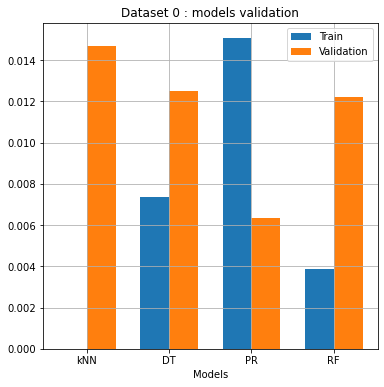

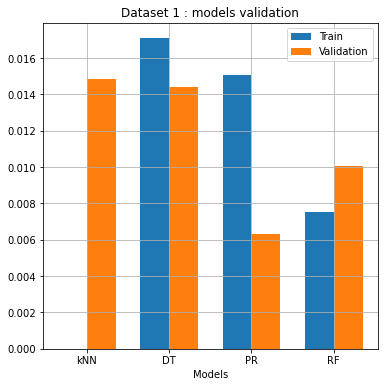

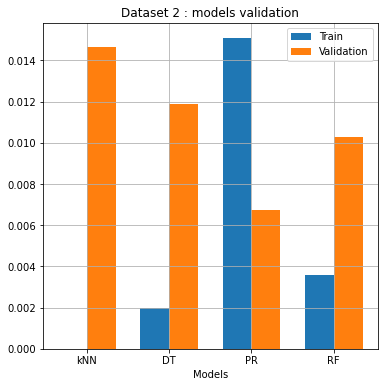

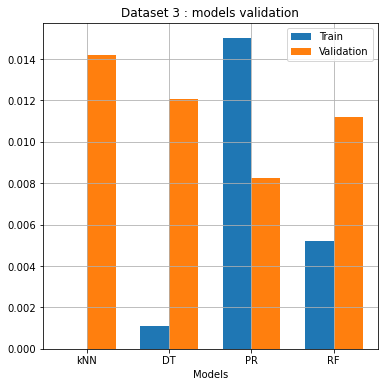

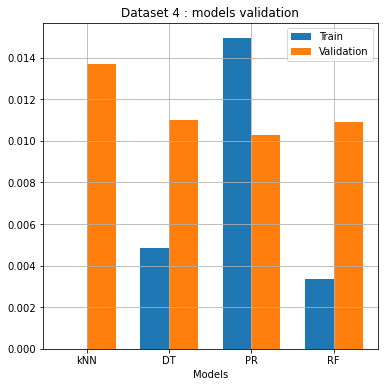

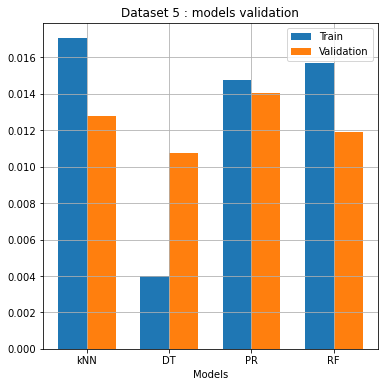

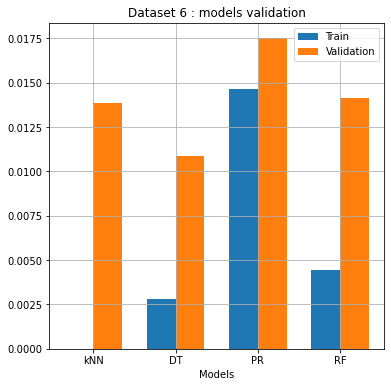

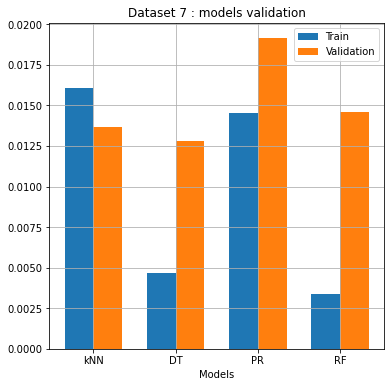

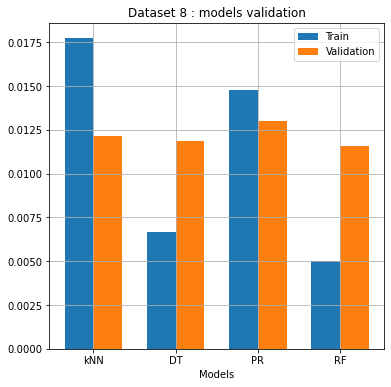

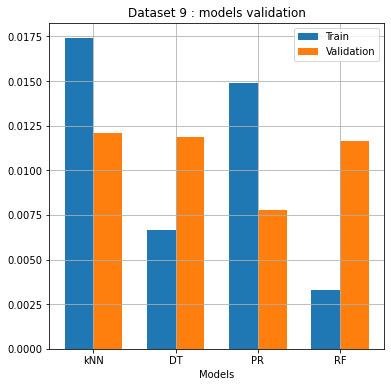

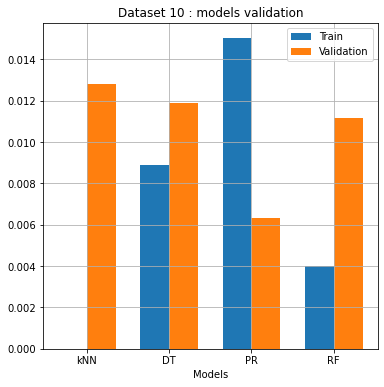

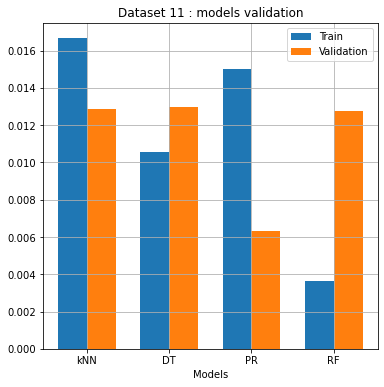

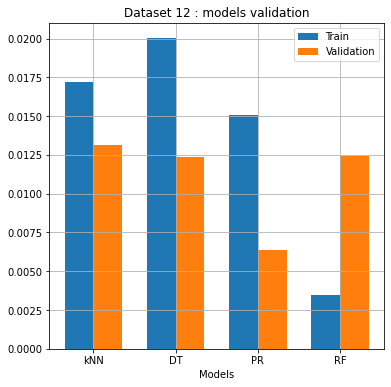

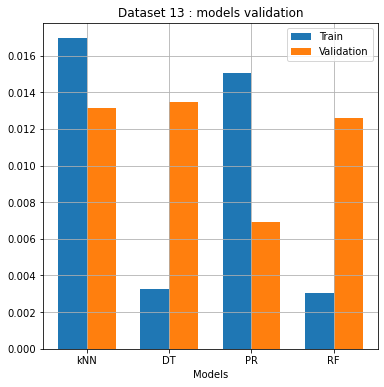

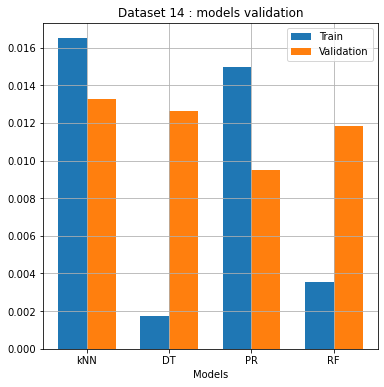

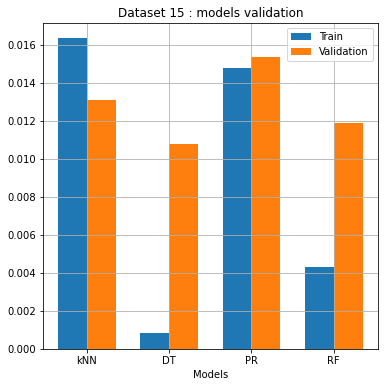

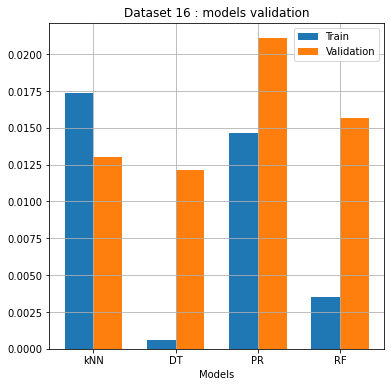

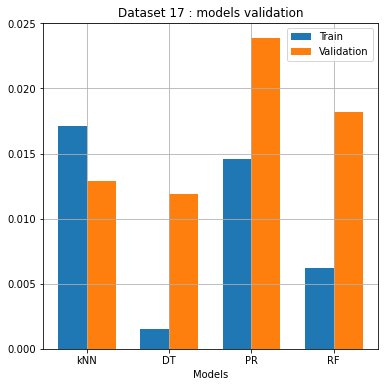

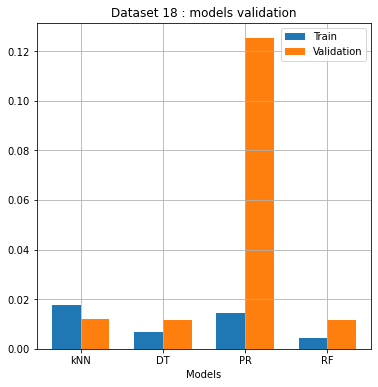

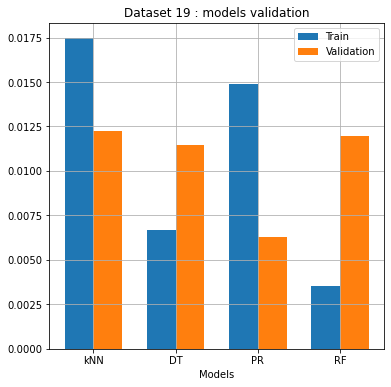

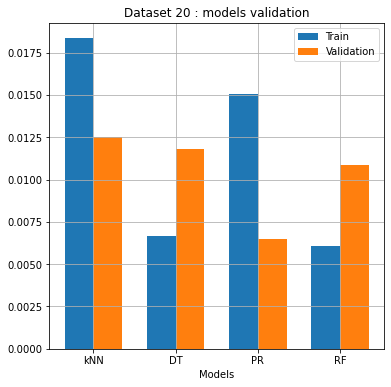

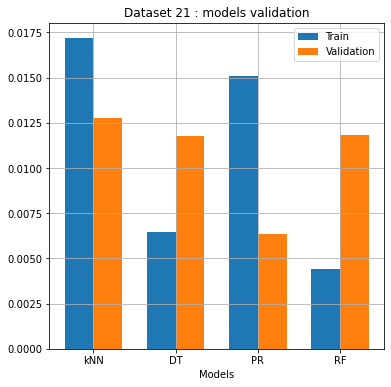

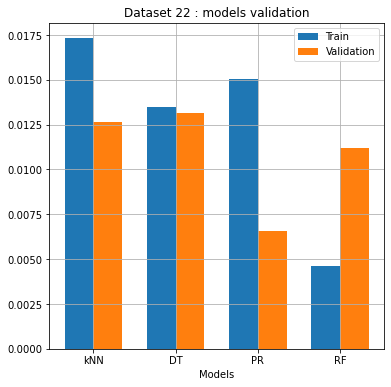

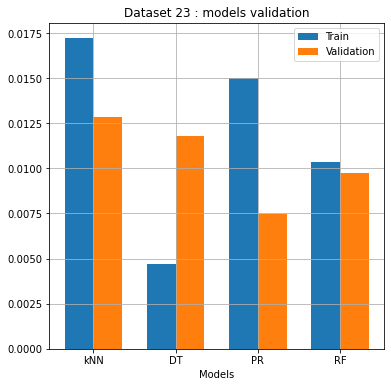

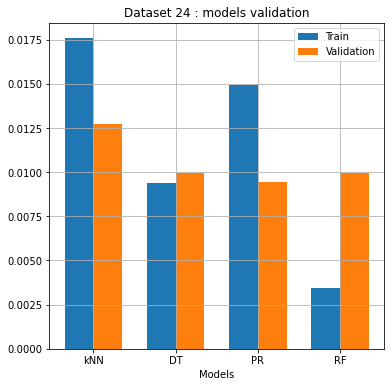

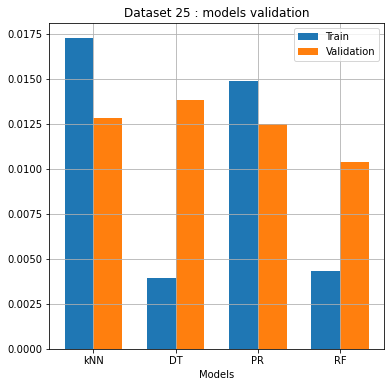

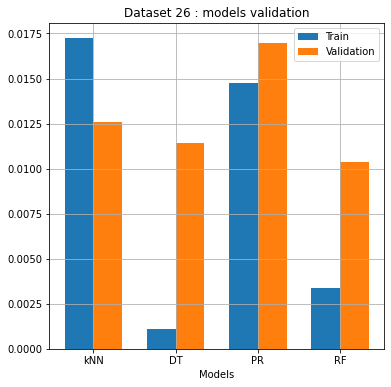

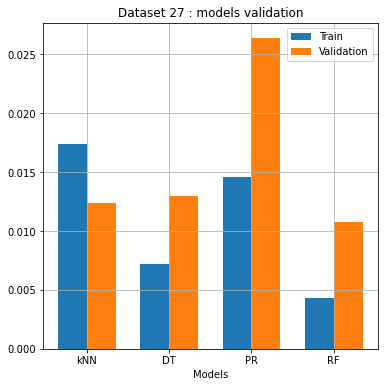

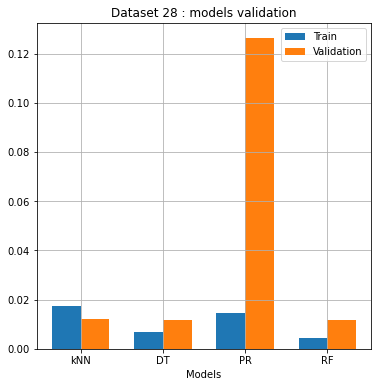

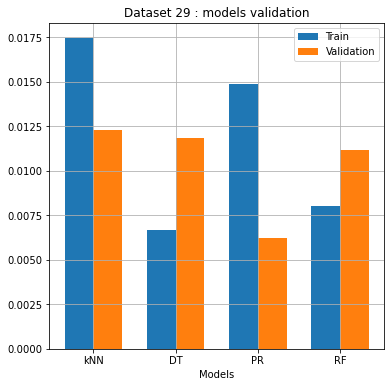

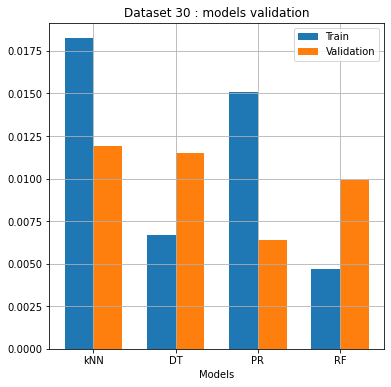

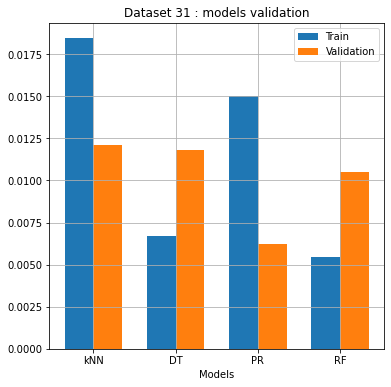

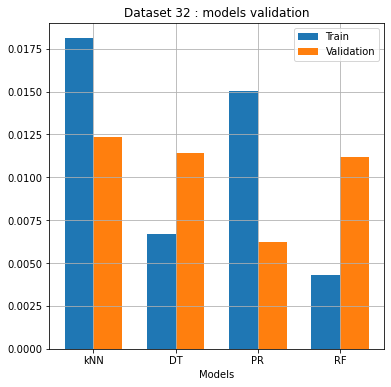

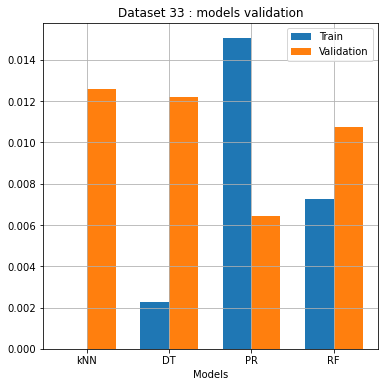

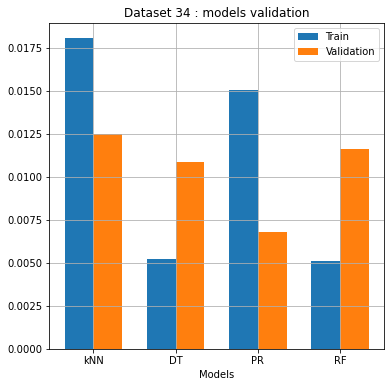

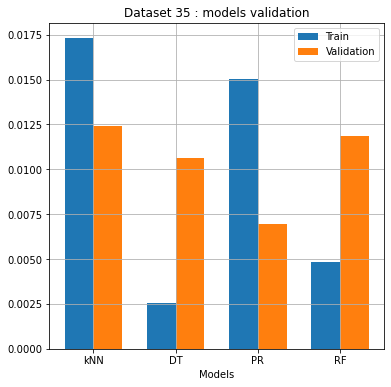

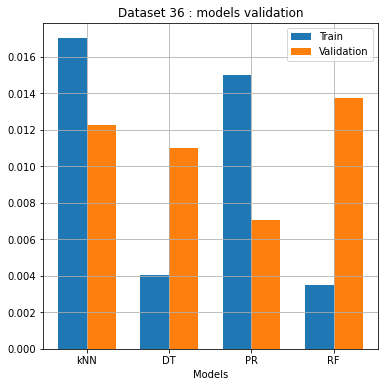

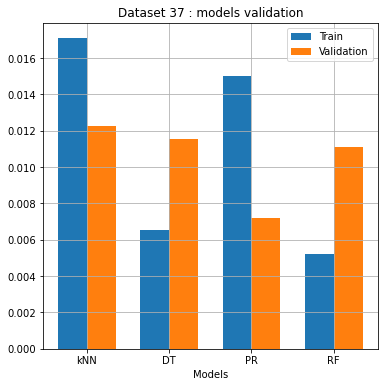

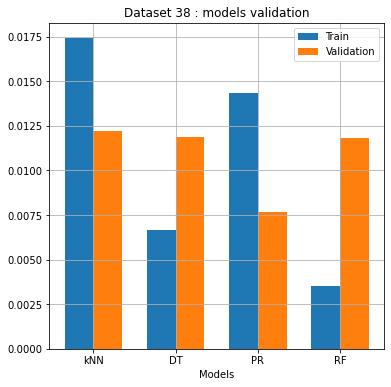

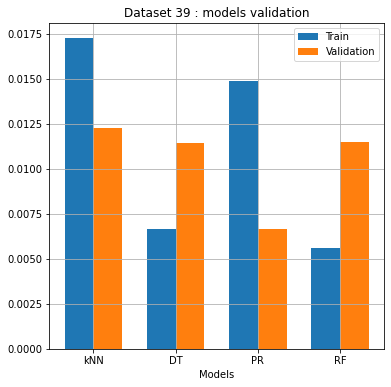

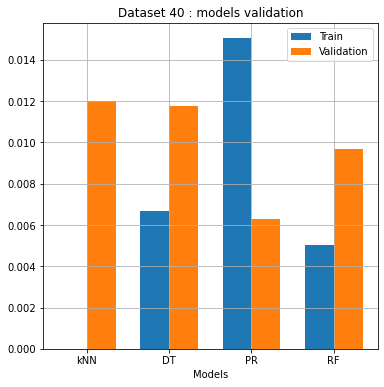

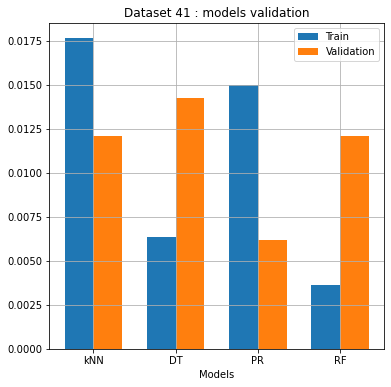

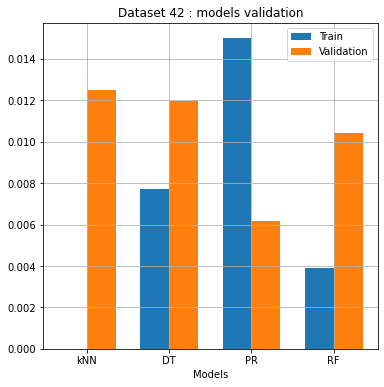

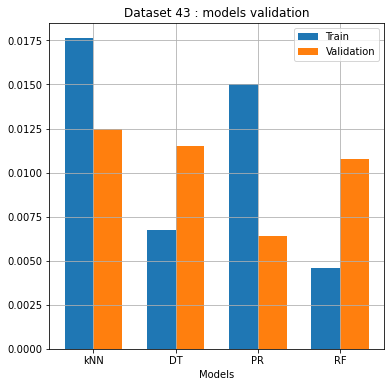

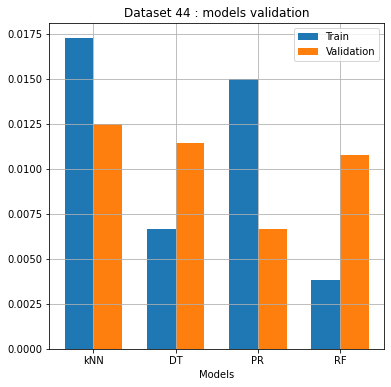

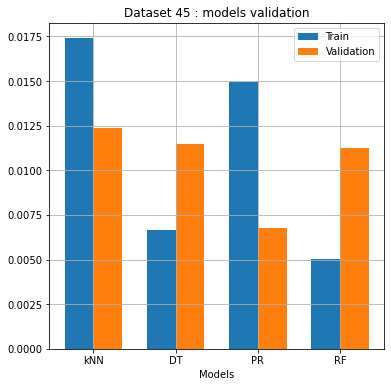

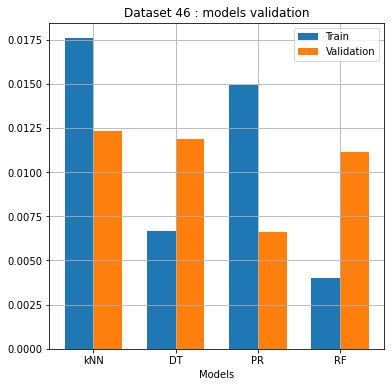

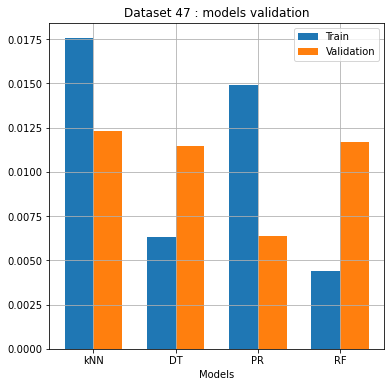

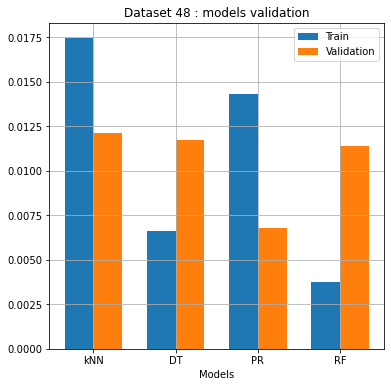

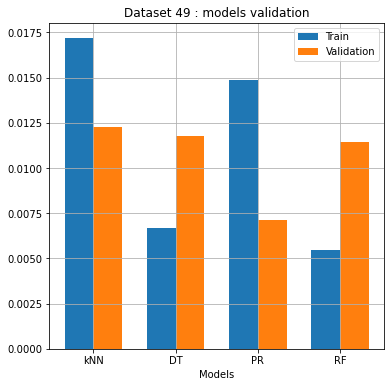

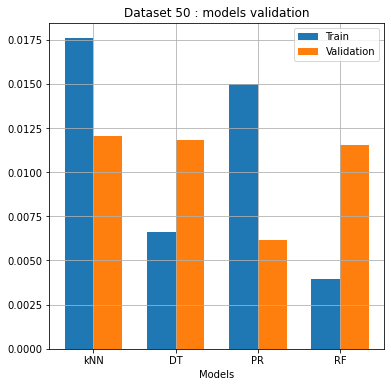

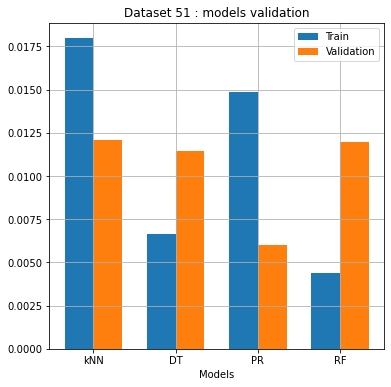

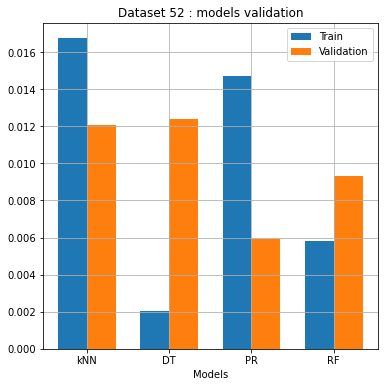

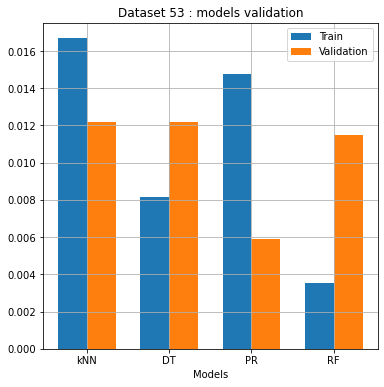

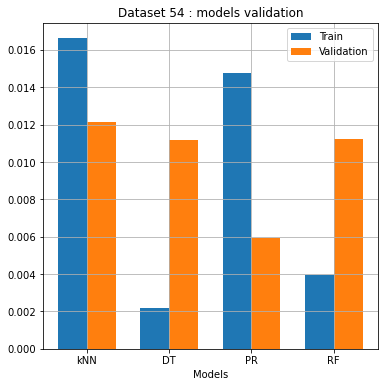

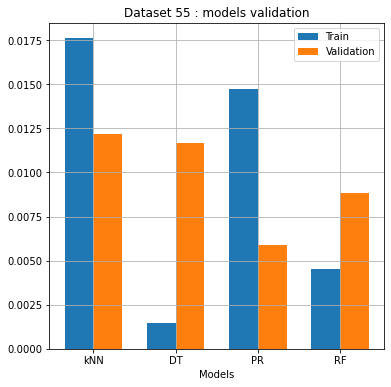

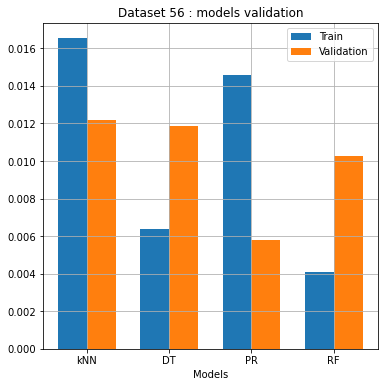

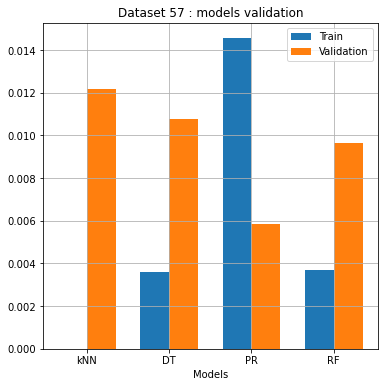

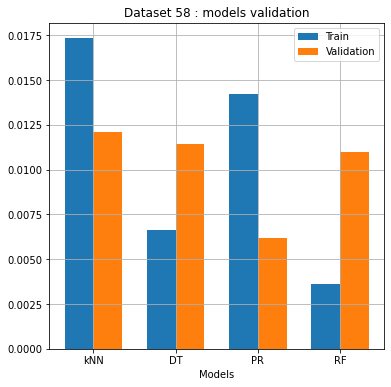

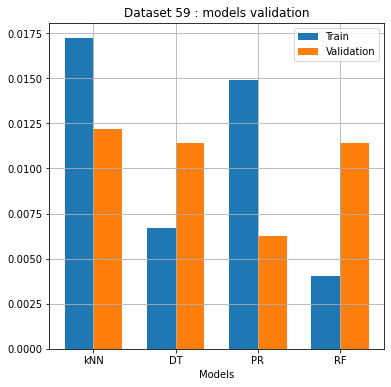

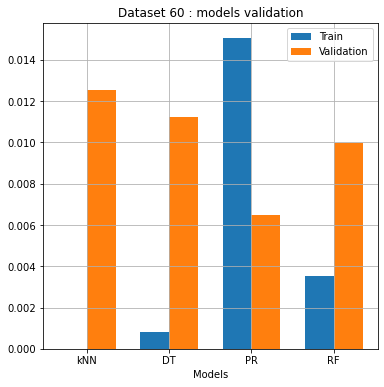

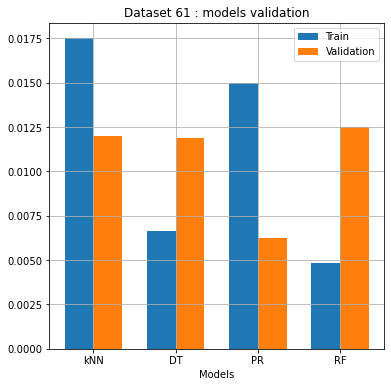

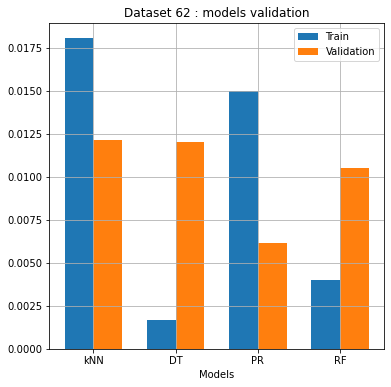

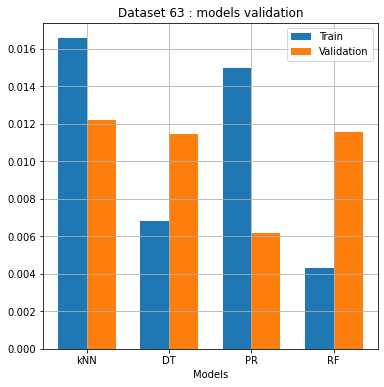

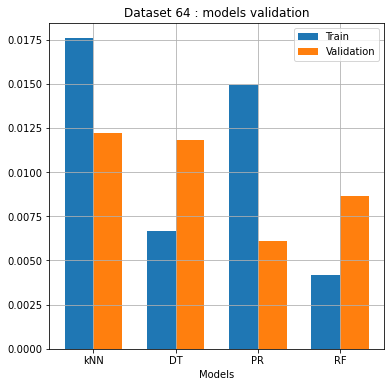

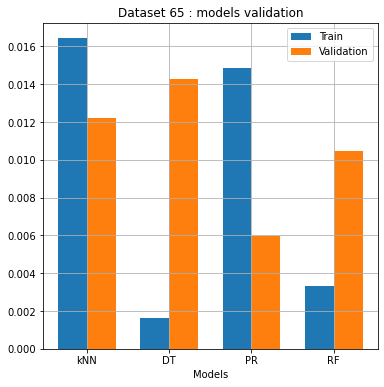

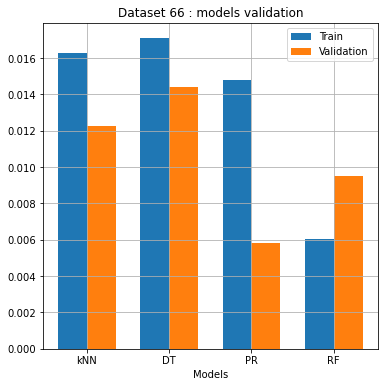

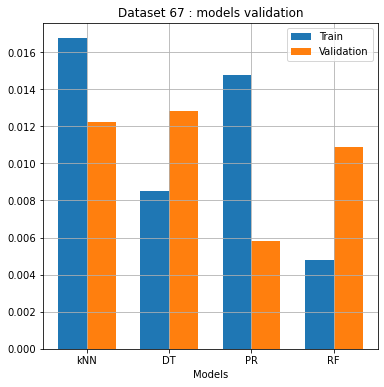

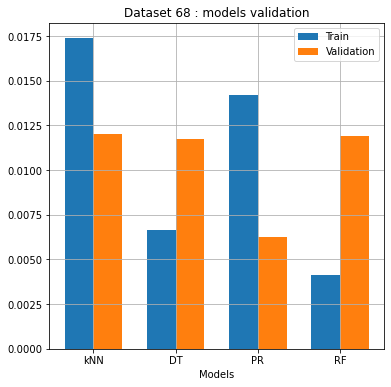

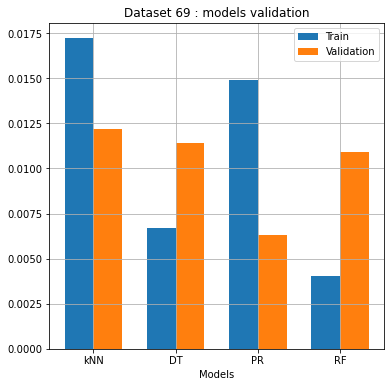

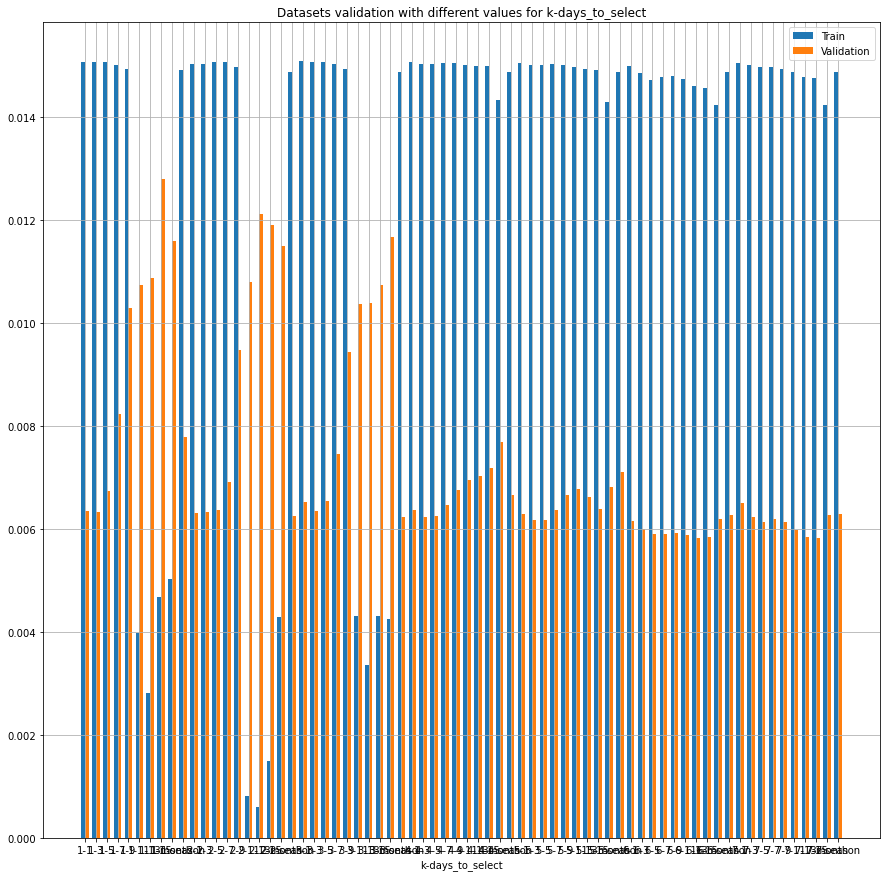

In [31]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

range_years = [1, 2, 3, 4, 5, 6, 7]
range_n_days = [1, 3, 5, 7, 9, 11, 13, 15, "month", "season"]
# All the datasets that have to be evaluated, one for each possible combination of the couple `k`-`days_to_select`
dataset_list = [tsp.add_upTo_k_years_ago_statistics(df=df_mean_best, df_upTo_k_years_ago=df_full_mean, k=k, current_year=False, 
                                                    days_to_select=days_to_select, y_col="mean", scale_y=True)[1:] 
                for k in range_years for days_to_select in range_n_days]
xvalues = [str(k)+"-"+str(days_to_select) for k in range_years for days_to_select in range_n_days]

model_paramGrid_list = [ 
                         ("kNN", KNeighborsRegressor(), {"n_neighbors":range(1,45),"weights":["uniform","distance"]}),
                         ("DT", DecisionTreeRegressor(), {"max_leaf_nodes":range(2,51),"max_features":[None,"sqrt"]}),
                         ("PR", ms.PolynomialRegression(), {"degree":[1,2,3,4]}),
                         ("RF", RandomForestRegressor(), {"n_estimators":range(1,51),"max_features":[None,"sqrt"]})
                       ]
scale_list = [False,True,False,False]

datasets_train_val_score, datasets_best_model, best_index, test_score, axes = ms.datasets_models_validation(dataset_list, 
                                 model_paramGrid_list, scale_list=scale_list, time_series=True, plot=True, plot_train=True, 
                                 xvalues=xvalues, xlabel="k-days_to_select",
                                 title="Datasets validation with different values for k-days_to_select", figsize=(15,15), 
                                 verbose=True)

In [32]:
print("Index best dataset:", str(best_index), "; k-days_to_select:", str(xvalues[best_index]))
print("Best model:", datasets_best_model[best_index][1], "; Hyperparameters values:", str(datasets_best_model[best_index][2]))
print("Validation score:", str(datasets_train_val_score[best_index,1]))
print("Test score:", str(test_score))

Index best dataset: 56 ; k-days_to_select: 6-13
Best model: PR ; Hyperparameters values: {'degree': 1}
Validation score: 0.005815045651242979
Test score: 0.01505297702537988


Now an example in which the value of `days_to_select` has been fixed to $13$, in order to show the impact of different values for `k` on the performance.

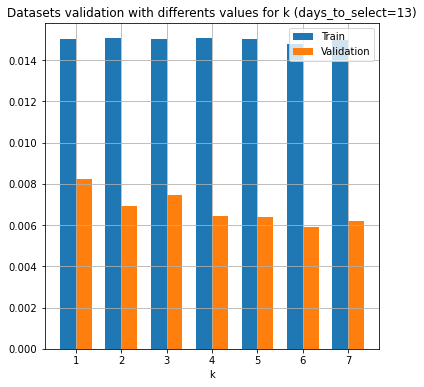

In [33]:
# In this example only the Polynomial Regression model is used
range_years = [1, 2, 3, 4, 5, 6, 7]
dataset_list = [tsp.add_upTo_k_years_ago_statistics(df=df_mean_best, df_upTo_k_years_ago=df_full_mean, k=k, current_year=False, 
                                                    days_to_select=7, y_col="mean", scale_y=True)[1:] 
                for k in range_years ]
xvalues = [str(k) for k in range_years]

model = ms.PolynomialRegression()
hyperparameter="degree"
hyperparameter_values=[1, 2, 3]

(datasets_train_val_score, datasets_best_hyperparameter_value, 
 best_index, test_score, axes) = ms.datasets_hyperparameter_validation(dataset_list, model, hyperparameter,
                                                   hyperparameter_values, time_series=True, plot=True, plot_train=True, 
                                                   xvalues=xvalues, xlabel="k",
                                                   title="Datasets validation with differents values for k (days_to_select=13)")

Now an example in which the value of `k` has been fixed to $6$, in order to show the impact of different values for `days_to_select` on the performance.

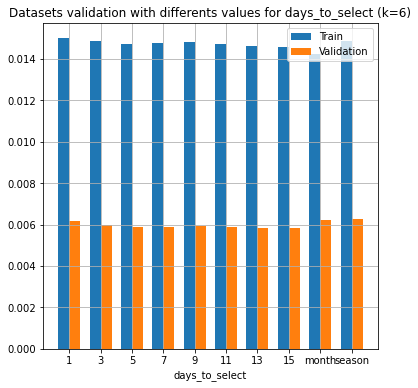

In [34]:
# In this example only the Polynomial Regression model is used
range_n_days = [1, 3, 5, 7, 9, 11, 13, 15, "month", "season"]
dataset_list = [tsp.add_upTo_k_years_ago_statistics(df=df_mean_best, df_upTo_k_years_ago=df_full_mean, k=6, current_year=False, 
                                                    days_to_select=days_to_select, y_col="mean", scale_y=True)[1:] 
                for days_to_select in range_n_days ]
xvalues = [str(days_to_select) for days_to_select in range_n_days]

model = ms.PolynomialRegression()
hyperparameter="degree"
hyperparameter_values=[1,2,3]

(datasets_train_val_score, datasets_best_hyperparameter_value,
 best_index, test_score, axes) = ms.datasets_hyperparameter_validation(dataset_list, model, hyperparameter,
                                                    hyperparameter_values, time_series=True, plot=True, plot_train=True, 
                                                    xvalues=xvalues, xlabel="days_to_select",
                                                    title="Datasets validation with differents values for days_to_select (k=6)")

**Best dataset: `k`=6 and `days_to_select`=13**

There has been an improvement as compared to the previous dataset: the validation score has decreased from $0.00647$ to $0.00581$.

In [8]:
df_mean_best, _, _ = tsp.add_upTo_k_years_ago_statistics(df=df_mean_best, df_upTo_k_years_ago=df_full_mean, k=6, 
                                                         current_year=False, days_to_select=13, y_col="mean", scale_y=True)

In [9]:
df_mean_best

mean     mean_1     mean_2     mean_3     mean_4     mean_5  \
Datetime                                                                       
2020-01-08  38.646087  40.759729  26.099399  28.192059  54.887035  55.216906   
2020-01-09  39.866008  38.646087  40.759729  26.099399  28.192059  54.887035   
2020-01-10  63.946840  39.866008  38.646087  40.759729  26.099399  28.192059   
2020-01-11  53.902359  63.946840  39.866008  38.646087  40.759729  26.099399   
2020-01-12  42.199734  53.902359  63.946840  39.866008  38.646087  40.759729   
...               ...        ...        ...        ...        ...        ...   
2020-12-27  14.997987  11.480358  14.695619  28.473515  47.568209  49.143828   
2020-12-28  16.317778  14.997987  11.480358  14.695619  28.473515  47.568209   
2020-12-29  23.536875  16.317778  14.997987  11.480358  14.695619  28.473515   
2020-12-30  22.759021  23.536875  16.317778  14.997987  11.480358  14.695619   
2020-12-31  22.005000  22.759021  23.536875  16.317778  14.997987  11.480358   

               mean_6     mean_7  upTo_6_years_ago_mean  
Datetime                                                 
2020-01-08  56.675791  76.974569              36.287863  
2020-01-09  55.216906  56.675791              35.814008  
2020-01-10  54.887035  55.216906              36.143744  
2020-01-11  28.192059  54.887035              35.806540  
2020-01-12  26.099399  28.192059              35.522678  
...               ...        ...                    ...  
2020-12-27  43.004333  42.601218              38.902204  
2020-12-28  49.143828  43.004333              38.423588  
2020-12-29  47.568209  49.143828              37.817480  
2020-12-30  28.473515  47.568209              36.864552  
2020-12-31  14.695619  28.473515              35.864452  

[359 rows x 9 columns]

## Add statistical information about `k` years ago

The same full DataFrame prepared before is used, which is `df_mean_full`.

A new column is added, containing statistical information about the daily mean level of PM10 of `k` years ago. So, the difference with the previous step is that now only a single previous year is considered. In order to do that, the function `tsp.add_k_years_ago_statistics` is applied. 

In this step, two choices have to be made.
1. The specific value of `k` has to be chosen, among the values `[1, 2, 3, 4, 5, 6, 7]`. (The supported years available are 2013-2020, so up to $7$ years ago).
2. The specific value of `days_to_select` has to be chosen, among the values `[1, 3, 5, 7, 9, 11, 13, 15, "month", "season"]`. This parameter specifies, for each 2020 day, which days of `k` years ago have to be taken into account: if it's a number `n`, the `n` days centered on that day but `k` years ago are selected; if it's `"month"`, the days of the same month but `k` years ago are selected; if it's `"season"`, the days of the same season but `k` years ago are selected.

To sum up, two choices have to be made at the same time: the choice for a specific value for `k` and the choice for a  specific value for `days_to_select`. All the possible combinations of the couple `k`-`days_to_select` are evaluated, i.e. an exhaustive selection is made. In the end, the best couple is selected. 

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:657: UserWarning: For the day 2020-01-08 only these 7 years ago days have been found: ['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08', '2013-01-09', '2013-01-10', '2013-01-11', '2013-01-12', '2013-01-13', '2013-01-14', '2013-01-15', '2013-01-16', '2013-01-17', '2013-01-18', '2013-01-19', '2013-01-20', '2013-01-21', '2013-01-22', '2013-01-23', '2013-01-24', '2013-01-25', '2013-01-26', '2013-01-27', '2013-01-28', '2013-01-29', '2013-01-30', '2013-01-31', '2013-02-01', '2013-02-02', '2013-02-03', '2013-02-04', '2013-02-05', '2013-02-06', '2013-02-07', '2013-02-08', '2013-02-09', '2013-02-10', '2013-02-11', '2013-02-12', '2013-02-13', '2013-02-14', '2013-02-15', '2013-02-16', '2013-02-17', '2013-02-18', '2013-02-19', '2013-02-20', '2013-02-21', '2013-02-22', '2013-02-23', '2013-02-24', '2013-02-25', '2013-02-26', '2013-02-27', '2013-02-28']
  warnings.warn(("

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:657: UserWarning: For the day 2020-02-03 only these 7 years ago days have been found: ['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08', '2013-01-09', '2013-01-10', '2013-01-11', '2013-01-12', '2013-01-13', '2013-01-14', '2013-01-15', '2013-01-16', '2013-01-17', '2013-01-18', '2013-01-19', '2013-01-20', '2013-01-21', '2013-01-22', '2013-01-23', '2013-01-24', '2013-01-25', '2013-01-26', '2013-01-27', '2013-01-28', '2013-01-29', '2013-01-30', '2013-01-31', '2013-02-01', '2013-02-02', '2013-02-03', '2013-02-04', '2013-02-05', '2013-02-06', '2013-02-07', '2013-02-08', '2013-02-09', '2013-02-10', '2013-02-11', '2013-02-12', '2013-02-13', '2013-02-14', '2013-02-15', '2013-02-16', '2013-02-17', '2013-02-18', '2013-02-19', '2013-02-20', '2013-02-21', '2013-02-22', '2013-02-23', '2013-02-24', '2013-02-25', '2013-02-26', '2013-02-27', '2013-02-28']
  warnings.warn(("

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:657: UserWarning: For the day 2020-02-23 only these 7 years ago days have been found: ['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08', '2013-01-09', '2013-01-10', '2013-01-11', '2013-01-12', '2013-01-13', '2013-01-14', '2013-01-15', '2013-01-16', '2013-01-17', '2013-01-18', '2013-01-19', '2013-01-20', '2013-01-21', '2013-01-22', '2013-01-23', '2013-01-24', '2013-01-25', '2013-01-26', '2013-01-27', '2013-01-28', '2013-01-29', '2013-01-30', '2013-01-31', '2013-02-01', '2013-02-02', '2013-02-03', '2013-02-04', '2013-02-05', '2013-02-06', '2013-02-07', '2013-02-08', '2013-02-09', '2013-02-10', '2013-02-11', '2013-02-12', '2013-02-13', '2013-02-14', '2013-02-15', '2013-02-16', '2013-02-17', '2013-02-18', '2013-02-19', '2013-02-20', '2013-02-21', '2013-02-22', '2013-02-23', '2013-02-24', '2013-02-25', '2013-02-26', '2013-02-27', '2013-02-28']
  warnings.warn(("

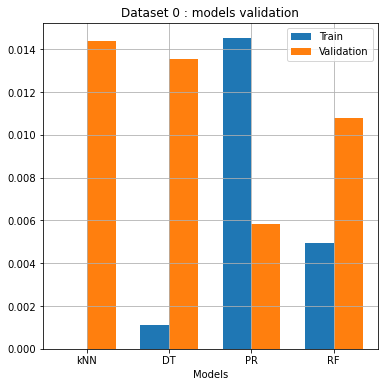

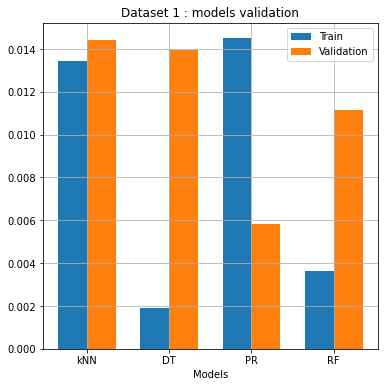

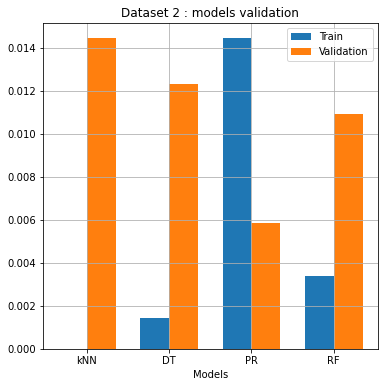

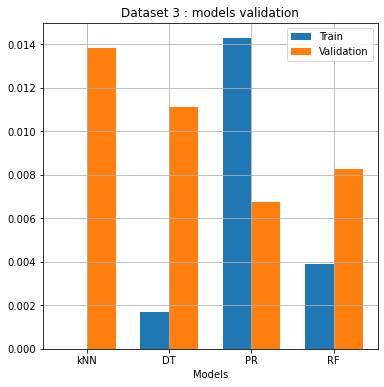

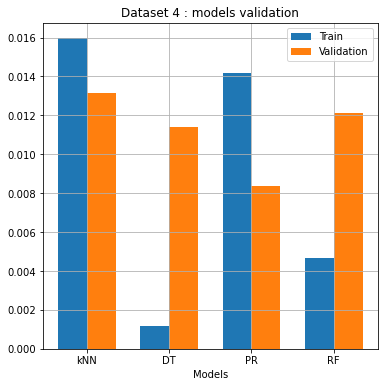

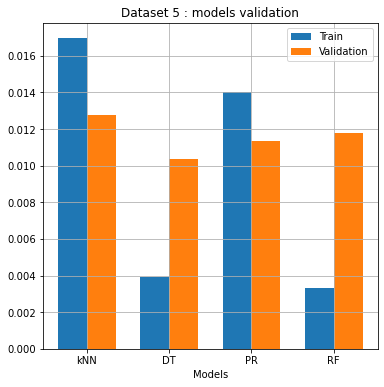

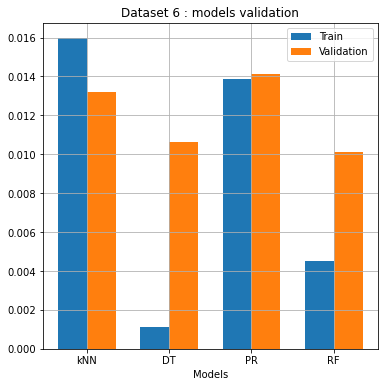

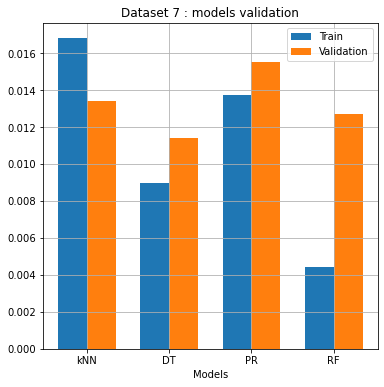

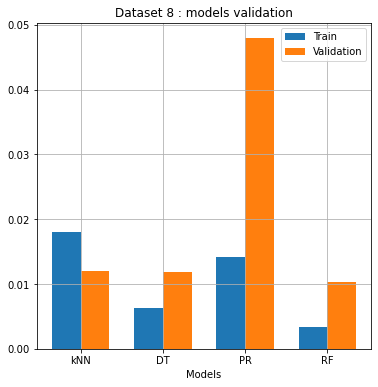

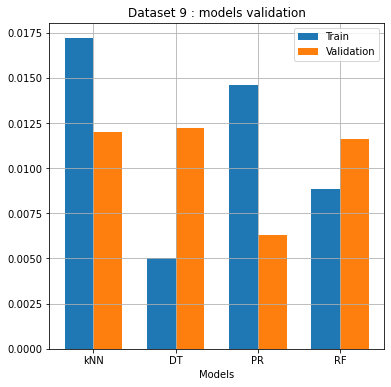

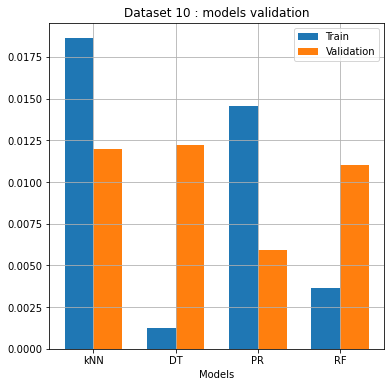

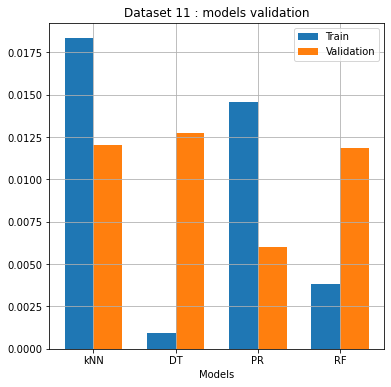

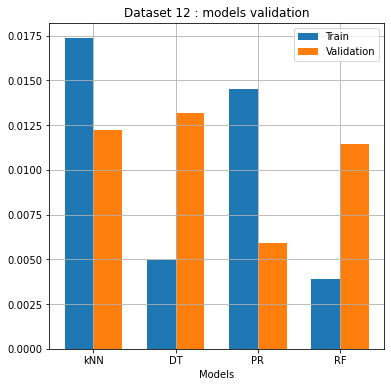

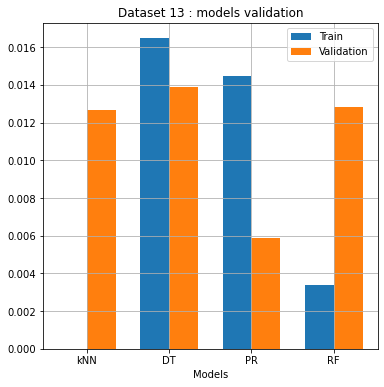

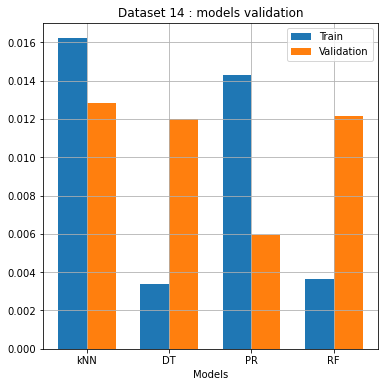

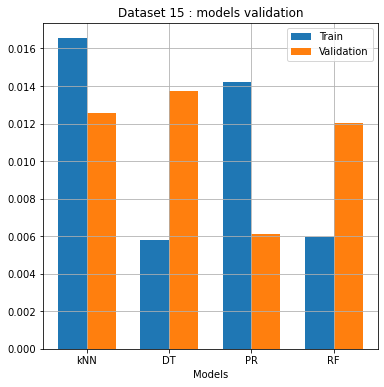

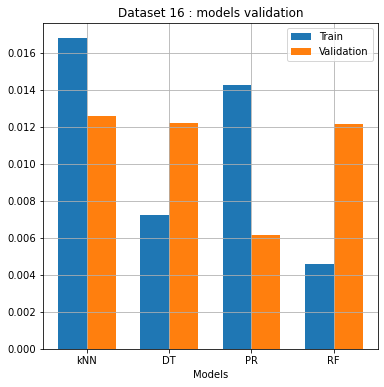

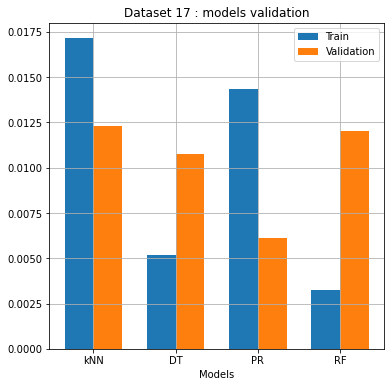

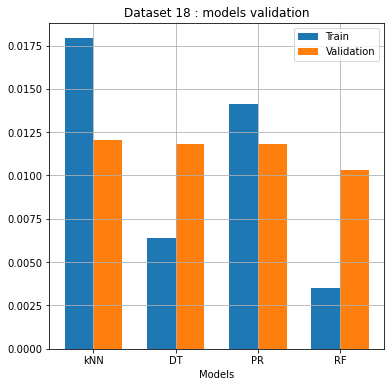

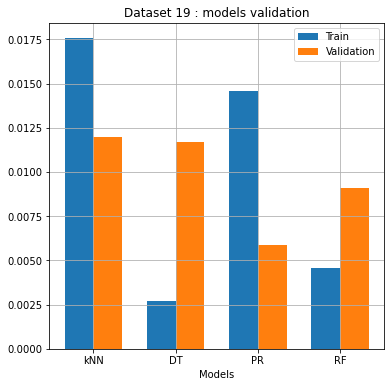

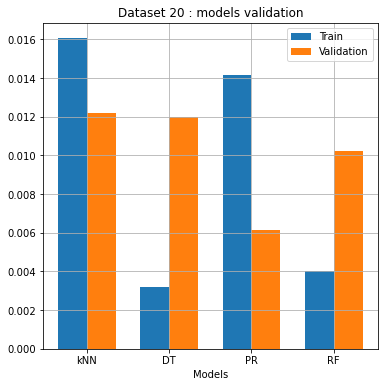

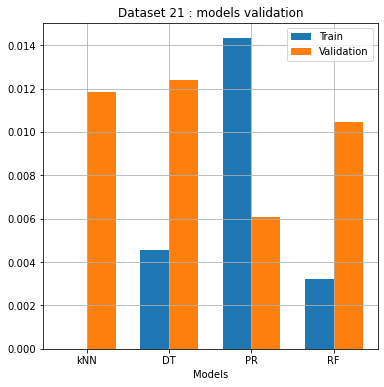

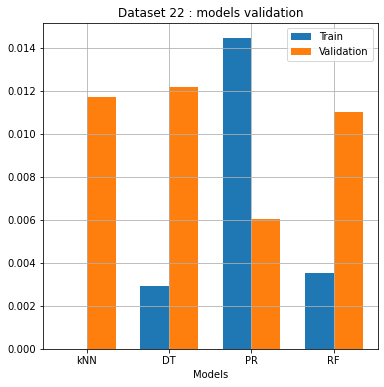

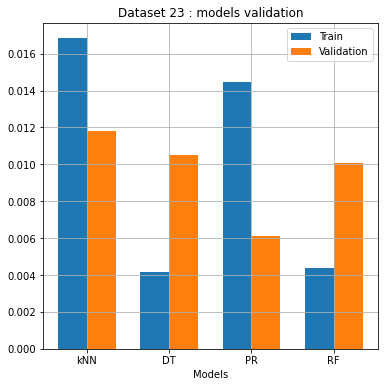

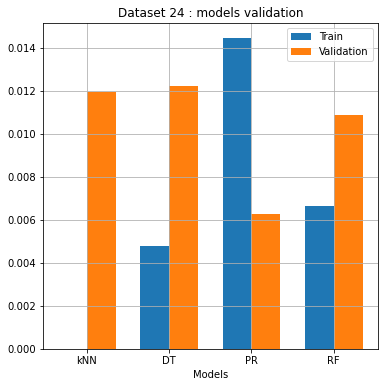

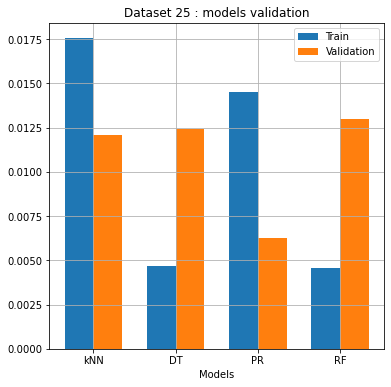

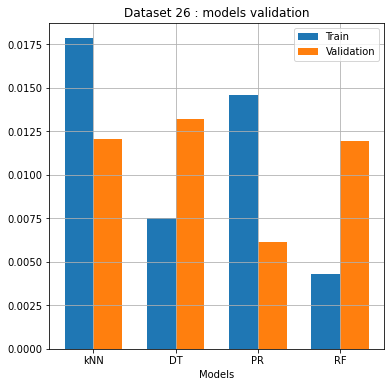

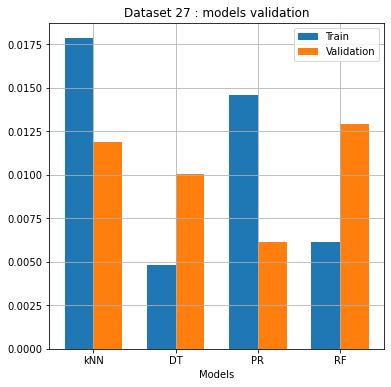

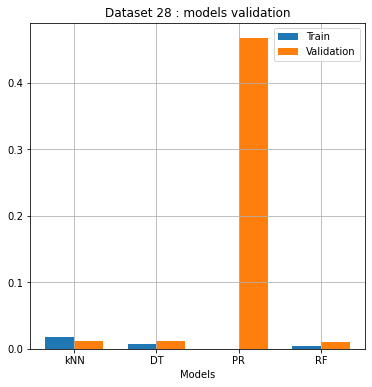

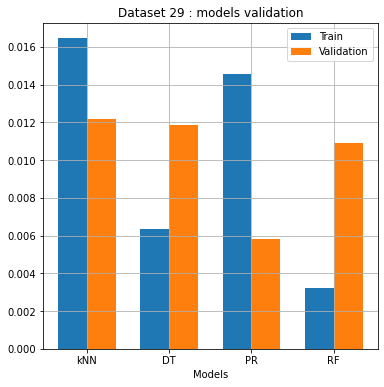

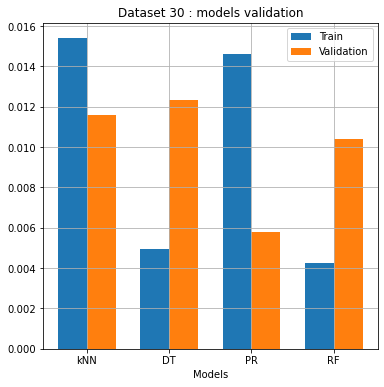

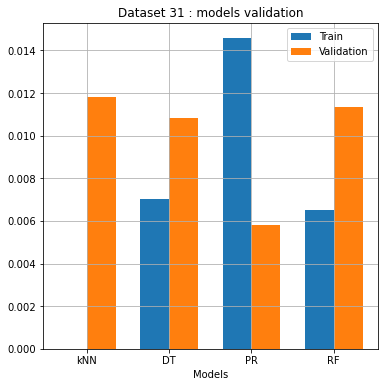

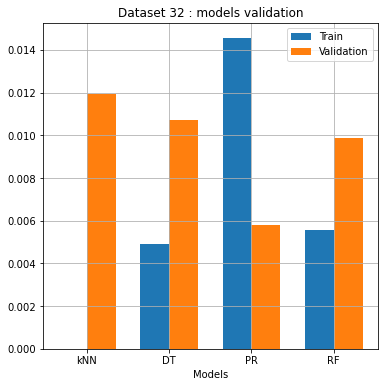

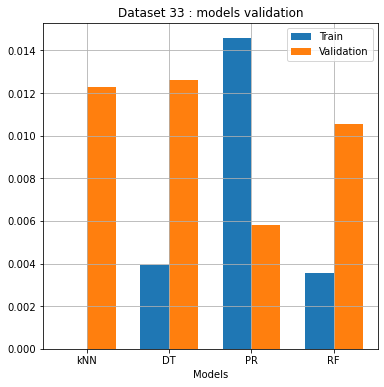

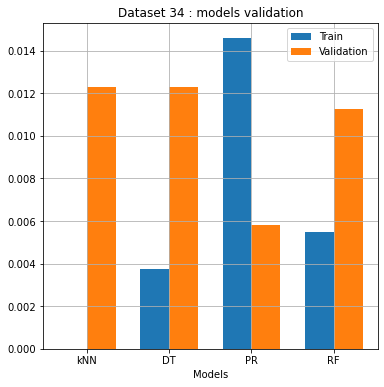

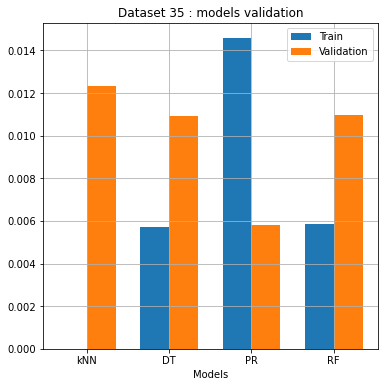

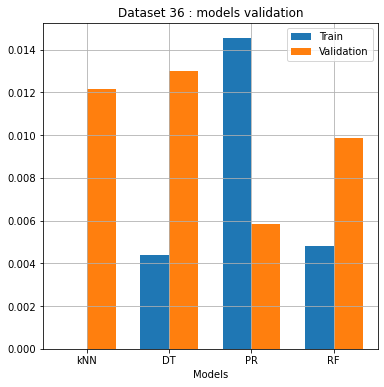

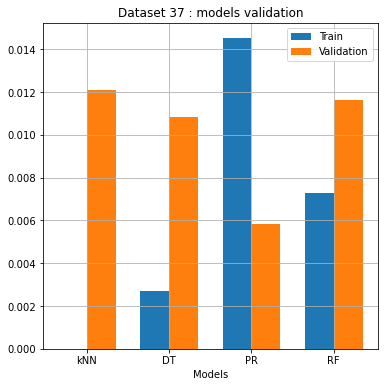

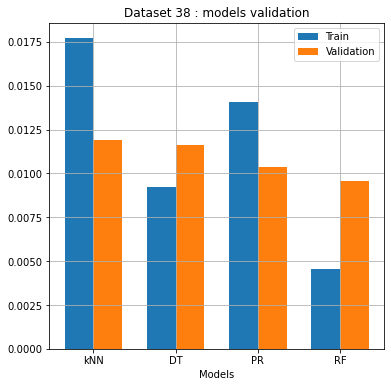

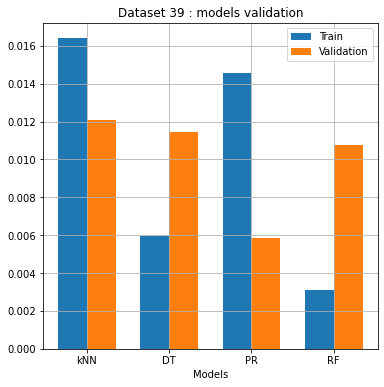

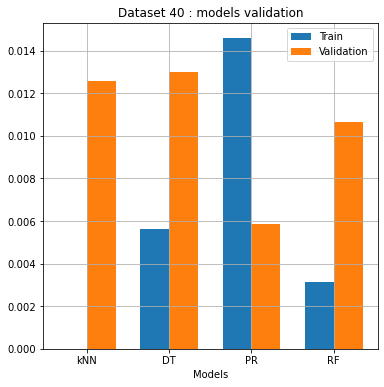

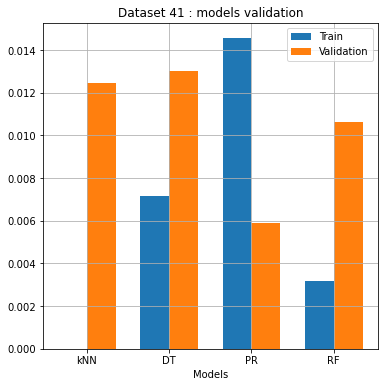

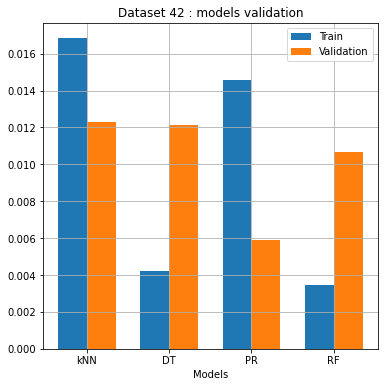

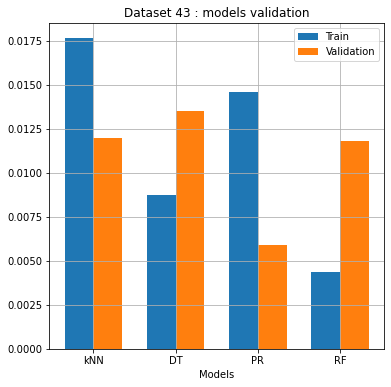

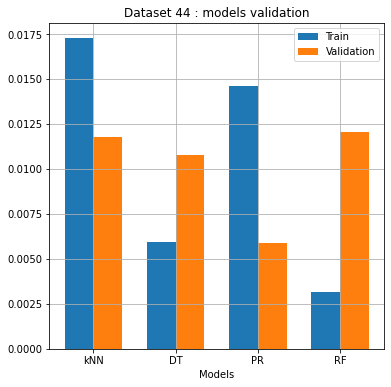

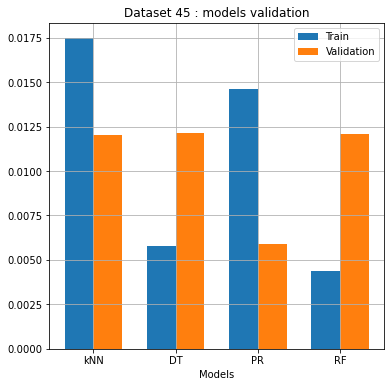

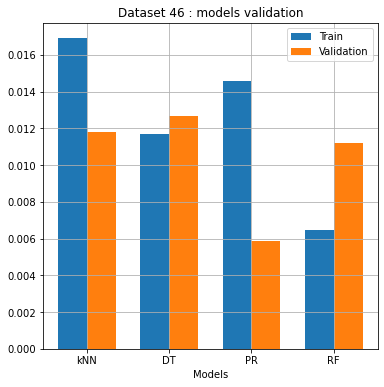

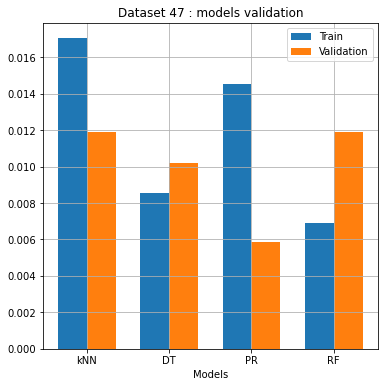

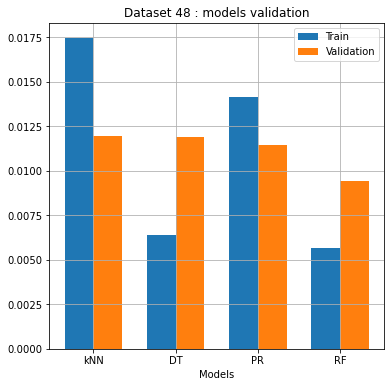

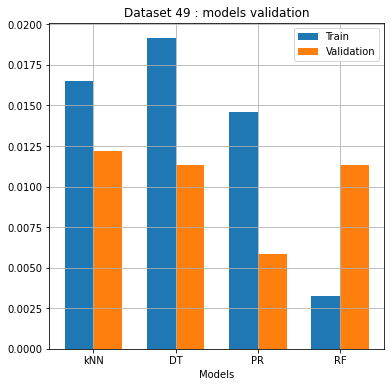

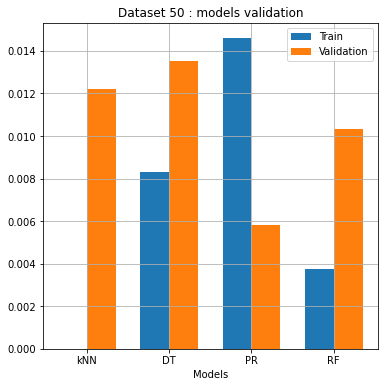

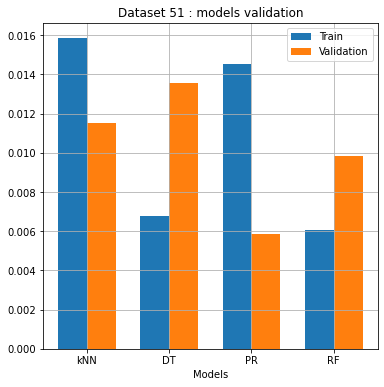

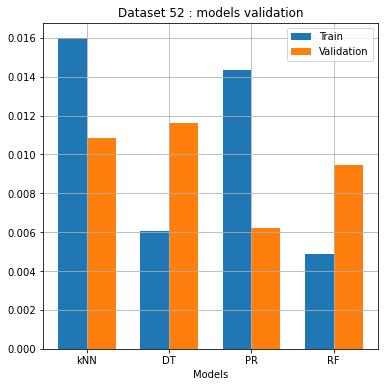

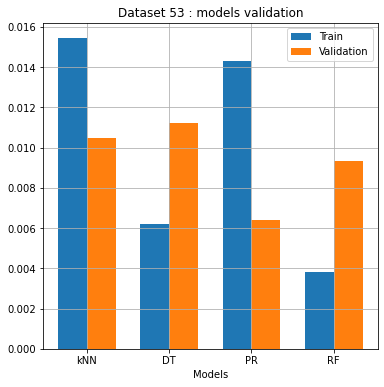

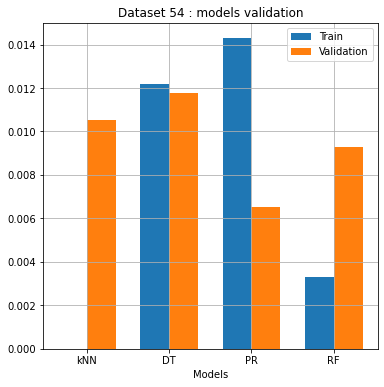

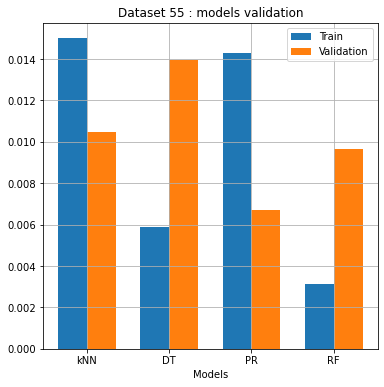

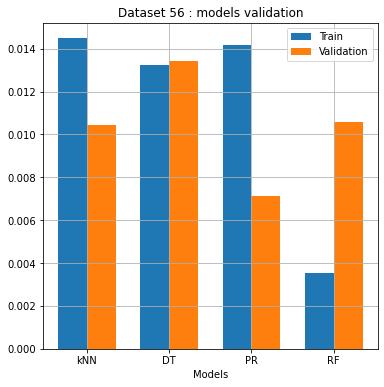

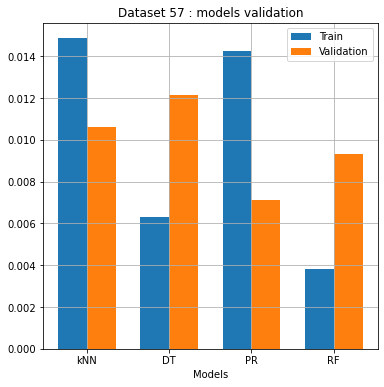

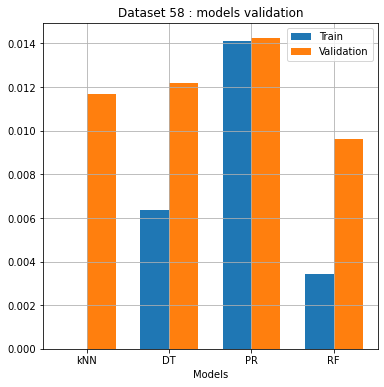

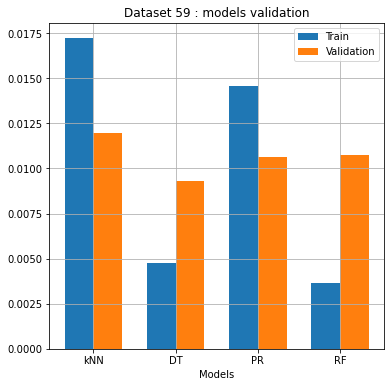

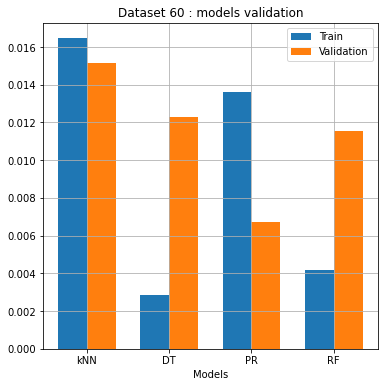

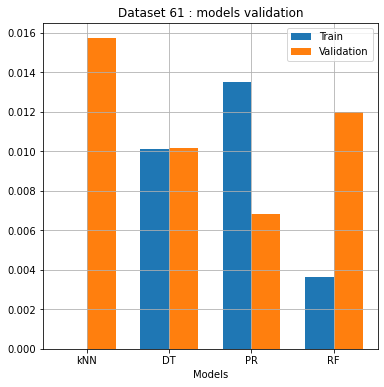

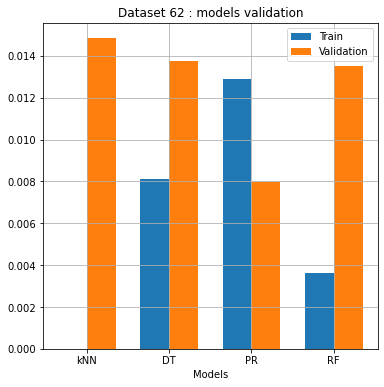

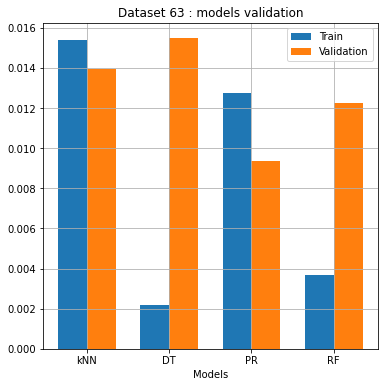

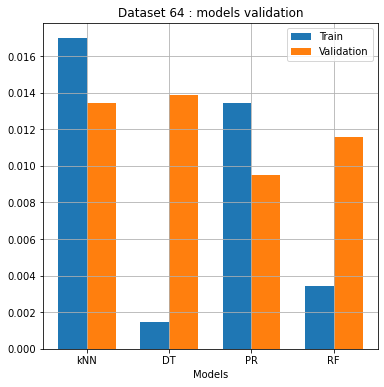

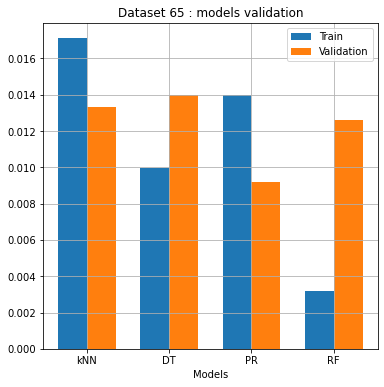

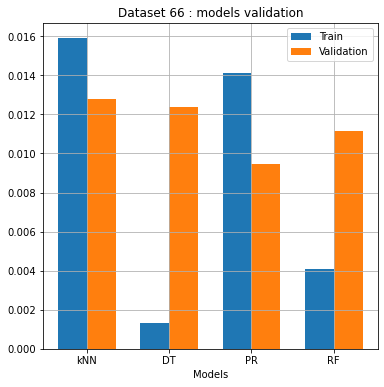

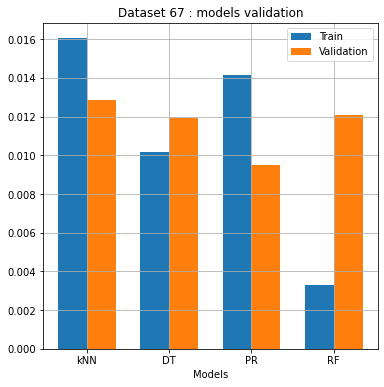

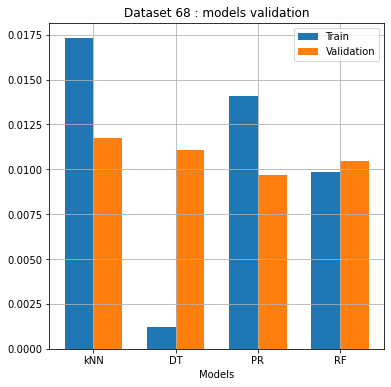

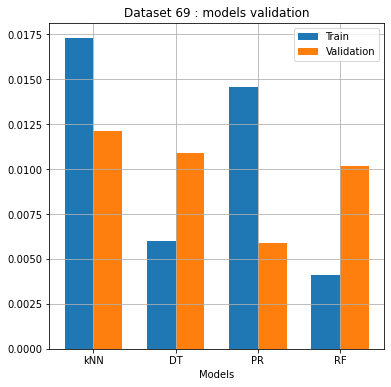

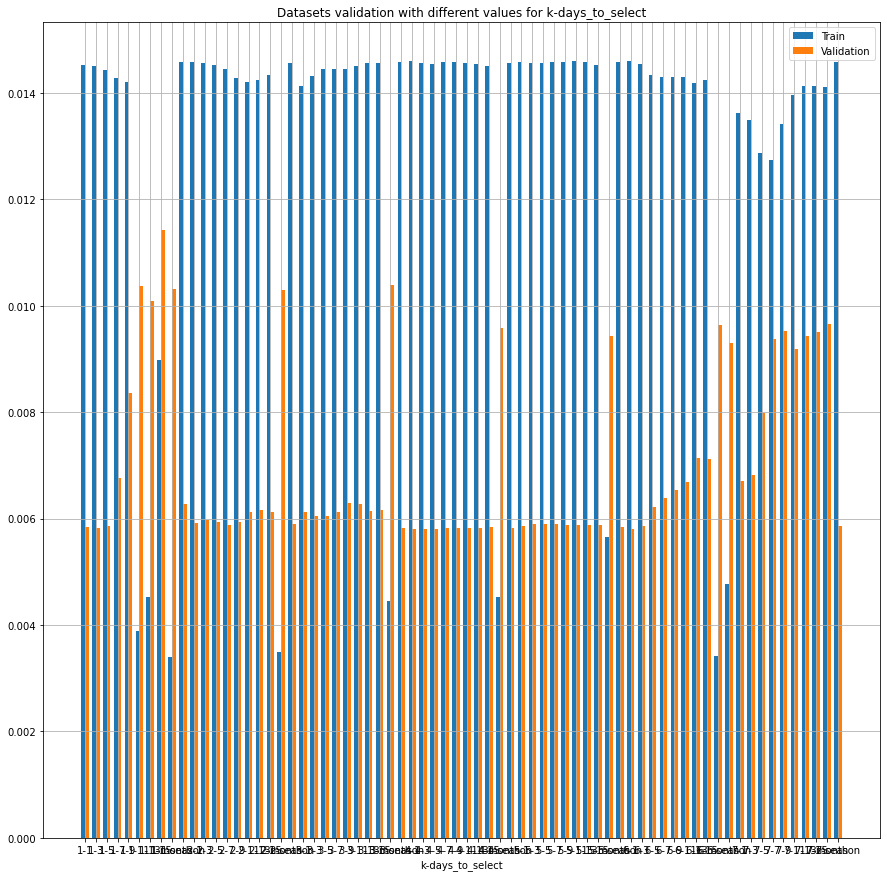

In [37]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

range_years = [1, 2, 3, 4, 5, 6, 7]
range_n_days = [1, 3, 5, 7, 9, 11, 13, 15, "month", "season"]
# All the datasets that have to be evaluated, one for each possible combination of the couple `k`-`days_to_select`
dataset_list = [tsp.add_k_years_ago_statistics(df_mean_best, df_k_years_ago=df_full_mean, k=k, days_to_select=days_to_select, 
                                               y_col="mean", scale_y=True)[1:] 
                for k in range_years for days_to_select in range_n_days]
xvalues = [str(k)+"-"+str(days_to_select) for k in range_years for days_to_select in range_n_days]

model_paramGrid_list = [ 
                         ("kNN", KNeighborsRegressor(), {"n_neighbors":range(1,45),"weights":["uniform","distance"]}),
                         ("DT", DecisionTreeRegressor(), {"max_leaf_nodes":range(2,51),"max_features":[None,"sqrt"]}),
                         ("PR", ms.PolynomialRegression(), {"degree":[1,2,3,4]}),
                         ("RF", RandomForestRegressor(), {"n_estimators":range(1,51),"max_features":[None,"sqrt"]})
                       ]
scale_list = [False,True,False,False]

datasets_train_val_score, datasets_best_model, best_index, test_score, axes = ms.datasets_models_validation(dataset_list, 
                                 model_paramGrid_list, scale_list=scale_list, time_series=True, plot=True, plot_train=True, 
                                 xvalues=xvalues, xlabel="k-days_to_select",
                                 title="Datasets validation with different values for k-days_to_select", figsize=(15,15), 
                                 verbose=True)

In [38]:
print("Index best dataset:", str(best_index), "; k-days_to_select:", str(xvalues[best_index]))
print("Best model:", datasets_best_model[best_index][1], "; Hyperparameters values:", str(datasets_best_model[best_index][2]))
print("Validation score:", str(datasets_train_val_score[best_index,1]))
print("Test score:", str(test_score))

Index best dataset: 50 ; k-days_to_select: 6-1
Best model: PR ; Hyperparameters values: {'degree': 1}
Validation score: 0.005804228658914929
Test score: 0.014628394398884796


Now an example in which the value of `days_to_select` has been fixed to $1$, in order to show the impact of different values for `k` on the performance.

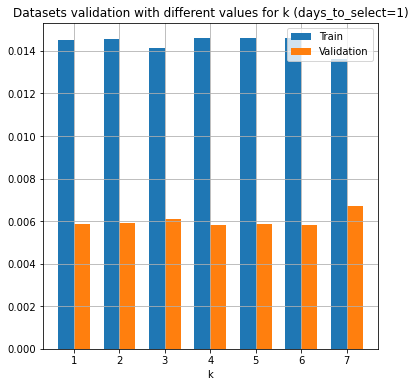

In [39]:
# In this example only the Polynomial Regression model is used
range_years = [1, 2, 3, 4, 5, 6, 7]
dataset_list = [tsp.add_k_years_ago_statistics(df_mean_best, df_k_years_ago=df_full_mean, k=k, days_to_select=1, 
                                               y_col="mean", scale_y=True)[1:] 
                for k in range_years]
xvalues = [str(k) for k in range_years]

model = ms.PolynomialRegression()
hyperparameter="degree"
hyperparameter_values=[1, 2, 3]

(datasets_train_val_score, datasets_best_hyperparameter_value,
 best_index, test_score, axes) = ms.datasets_hyperparameter_validation(dataset_list, model, hyperparameter, 
                                                     hyperparameter_values, time_series=True, plot=True, plot_train=True, 
                                                     xvalues=xvalues, xlabel="k",
                                                     title="Datasets validation with different values for k (days_to_select=1)")

Now an example in which the value of `k` has been fixed to $6$, in order to show the impact of different values for `days_to_select` on the performance.

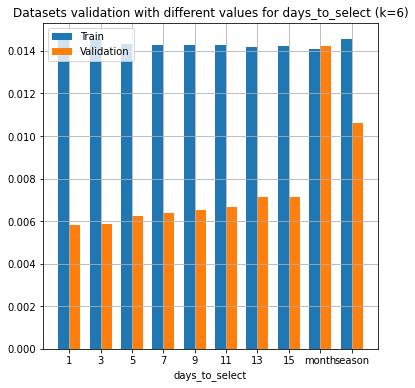

In [40]:
# In this example only the Polynomial Regression model is used
range_n_days = [1, 3, 5, 7, 9, 11, 13, 15, "month", "season"]
dataset_list = [tsp.add_k_years_ago_statistics(df_mean_best, df_k_years_ago=df_full_mean, k=6, days_to_select=days_to_select, 
                                               y_col="mean", scale_y=True)[1:] 
                for days_to_select in range_n_days]
xvalues = [str(days_to_select) for days_to_select in range_n_days]

model = ms.PolynomialRegression()
hyperparameter="degree"
hyperparameter_values=[1,2,3]

(datasets_train_val_score, datasets_best_hyperparameter_value,
 best_index, test_score, axes) = ms.datasets_hyperparameter_validation(dataset_list, model, hyperparameter, 
                                                     hyperparameter_values, time_series=True, plot=True, plot_train=True, 
                                                     xvalues=xvalues, xlabel="days_to_select",
                                                     title="Datasets validation with different values for days_to_select (k=6)")

**Best dataset: `k`=6 and `days_to_select`=1**

There has been an improvement as compared to the previous dataset: the validation score has decreased from $0.00581$ to $0.00580$.

In [10]:
df_mean_best,_,_ = tsp.add_k_years_ago_statistics(df_mean_best, df_k_years_ago=df_full_mean, k=6, days_to_select=1, 
                                                  y_col="mean", scale_y=True)

In [11]:
df_mean_best

mean     mean_1     mean_2     mean_3     mean_4     mean_5  \
Datetime                                                                       
2020-01-08  38.646087  40.759729  26.099399  28.192059  54.887035  55.216906   
2020-01-09  39.866008  38.646087  40.759729  26.099399  28.192059  54.887035   
2020-01-10  63.946840  39.866008  38.646087  40.759729  26.099399  28.192059   
2020-01-11  53.902359  63.946840  39.866008  38.646087  40.759729  26.099399   
2020-01-12  42.199734  53.902359  63.946840  39.866008  38.646087  40.759729   
...               ...        ...        ...        ...        ...        ...   
2020-12-27  14.997987  11.480358  14.695619  28.473515  47.568209  49.143828   
2020-12-28  16.317778  14.997987  11.480358  14.695619  28.473515  47.568209   
2020-12-29  23.536875  16.317778  14.997987  11.480358  14.695619  28.473515   
2020-12-30  22.759021  23.536875  16.317778  14.997987  11.480358  14.695619   
2020-12-31  22.005000  22.759021  23.536875  16.317778  14.997987  11.480358   

               mean_6     mean_7  upTo_6_years_ago_mean  6_years_ago_mean  
Datetime                                                                   
2020-01-08  56.675791  76.974569              36.287863         71.802620  
2020-01-09  55.216906  56.675791              35.814008         79.803419  
2020-01-10  54.887035  55.216906              36.143744         71.632078  
2020-01-11  28.192059  54.887035              35.806540         79.216124  
2020-01-12  26.099399  28.192059              35.522678         89.111978  
...               ...        ...                    ...               ...  
2020-12-27  43.004333  42.601218              38.902204         17.186082  
2020-12-28  49.143828  43.004333              38.423588         19.039899  
2020-12-29  47.568209  49.143828              37.817480         20.643419  
2020-12-30  28.473515  47.568209              36.864552         19.247014  
2020-12-31  14.695619  28.473515              35.864452         23.937203  

[359 rows x 10 columns]

# ADD METEOROLOGICAL INFORMATION

Load the meteorological dataset, which contains values for several climatic agents in Italy in 2020. (It has been obtained using [ILMETEO](https://www.ilmeteo.it/)).

In [12]:
import pandas as pd
df_meteo = pd.read_csv("meteorological_data_2020.csv", index_col=0)
df_meteo = df_meteo.set_index(pd.DatetimeIndex(df_meteo.index))

In [13]:
df_meteo

TMEDIA °C   TMIN °C    TMAX °C  PUNTORUGIADA °C  UMIDITA %  \
2020-01-01   5.202196  0.173764  11.003131         2.534921  75.400344   
2020-01-02   4.774801  0.182640  10.325979         2.465371  78.058483   
2020-01-03   4.885063  0.531284   9.658314         3.231408  81.535958   
2020-01-04   6.162960  1.381113  11.354987         3.776887  79.979083   
2020-01-05   6.551925  1.686219  12.409042         3.172703  68.848841   
...               ...       ...        ...              ...        ...   
2020-12-27   3.366679  0.191966   6.335378         2.162273  80.374981   
2020-12-28   4.014919  1.075045   6.692360         3.125000  87.748644   
2020-12-29   4.921844  1.494424   8.174234         3.427775  85.676591   
2020-12-30   5.007944  2.084797   8.026350         3.539751  88.368509   
2020-12-31   3.614142 -0.334781   7.465027         2.430201  83.184996   

            VISIBILITA km  VENTOMEDIA km/h  VENTOMAX km/h  RAFFICA km/h  \
2020-01-01      16.156784         7.012758      13.023608           0.0   
2020-01-02      15.880184         6.966149      12.185646           0.0   
2020-01-03      16.139090         5.948631      10.975893           0.0   
2020-01-04      16.473732         6.768174      13.554989           0.0   
2020-01-05      17.870075         9.782989      18.613108           0.0   
...                   ...              ...            ...           ...   
2020-12-27      16.946089         8.373068      16.888885           0.0   
2020-12-28      11.109177        13.816230      27.218354           0.0   
2020-12-29      12.655763         9.622137      18.752669           0.0   
2020-12-30      11.634365         7.926860      15.825013           0.0   
2020-12-31      15.578617         7.799542      14.594909           0.0   

            PRESSIONESLM mb  PRESSIONEMEDIA mb  PIOGGIA mm  
2020-01-01      1028.970020                0.0         0.0  
2020-01-02      1030.733348                0.0         0.0  
2020-01-03      1027.118509                0.0         0.0  
2020-01-04      1023.379968                0.0         0.0  
2020-01-05      1025.567681                0.0         0.0  
...                     ...                ...         ...  
2020-12-27      1001.183619                0.0         0.0  
2020-12-28       992.389919                0.0         0.0  
2020-12-29       999.328145                0.0         0.0  
2020-12-30      1004.437032                0.0         0.0  
2020-12-31      1009.482102                0.0         0.0  

[366 rows x 12 columns]

## Add meteorological information about 2020

A new column is added, containing meteorological information about a specific climatic agent in Italy in 2020.

That specific climatic agent has to be chosen among the list `["TMEDIA °C", "TMIN °C", "TMAX °C", "UMIDITA %", "VENTOMEDIA km/h", "VENTOMAX km/h", "PRESSIONESLM mb"]`. All these possible agents are evaluated: in the end, the best one is selected.

In order to add a climatic agent, the function `tsp.add_timeSeries_dataframe` is used.

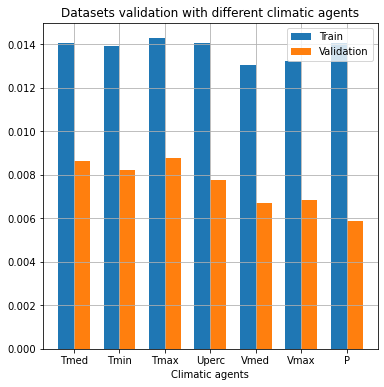

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

columns = ["TMEDIA °C", "TMIN °C", "TMAX °C", "UMIDITA %", "VENTOMEDIA km/h", "VENTOMAX km/h", "PRESSIONESLM mb"]
# All the datasets that have to be evaluated, one for each possible climatic agent
dataset_list = [tsp.add_timeSeries_dataframe(df_mean_best,df_meteo[[agent]], y_col="mean", scale_y=True)[1:] 
                for agent in columns]
xvalues = ["Tmed", "Tmin", "Tmax", "Uperc", "Vmed", "Vmax", "P"]

model_paramGrid_list = [ 
                         ("kNN", KNeighborsRegressor(), {"n_neighbors":range(1,45),"weights":["uniform","distance"]}),
                         ("DT", DecisionTreeRegressor(), {"max_leaf_nodes":range(2,51),"max_features":[None,"sqrt"]}),
                         ("PR", ms.PolynomialRegression(), {"degree":[1,2,3,4]}),
                         ("RF", RandomForestRegressor(), {"n_estimators":range(1,51),"max_features":[None,"sqrt"]})
                       ]
scale_list = [False,True,False,False]

datasets_train_val_score, datasets_best_model, best_index, test_score, axes = ms.datasets_models_validation(dataset_list,
                                 model_paramGrid_list, scale_list=scale_list, time_series=True, regr=True, plot=True, 
                                 plot_train=True, xvalues=xvalues, xlabel="Climatic agents",
                                 title="Datasets validation with different climatic agents")

In [47]:
print("Index best dataset:", str(best_index), "; Climatic agent:", str(xvalues[best_index]))
print("Best model:", datasets_best_model[best_index][1], "; Hyperparameters values:", str(datasets_best_model[best_index][2]))
print("Validation score:", str(datasets_train_val_score[best_index,1]))
print("Test score:", str(test_score))

Index best dataset: 6 ; Climatic agent: P
Best model: PR ; Hyperparameters values: {'degree': 1}
Validation score: 0.005893619946527116
Test score: 0.011106647607909125


The validation score associated with the best climatic agent has not decreased as compared to the previous dataset: the previous validation score was $0.00580$ and the current is $0.00589$.

**There has been no improvement as compared to the previous dataset: no new feature is added.**

*In all the datasets that have been tested, the `PolynomialRegression` model was always the best one. For this reason, from this point on only this model will be used.*

## Add statistical information about 2020 days with similar meteorological conditions

The previous attempt to add meteorological features was a failure. For this reason, the technique and the point of view have to be changed.

First of all, a new DataFrame is created: this simply contains the daily mean levels of PM10 in Italy in 2020 and the climatic agents in Italy in 2020. This DataFrame is simply obtained by merging the DataFrames `df_mean` and `df_meteo`

In [14]:
df_mean_meteo, _, _ = tsp.add_timeSeries_dataframe(df_mean, df_meteo, y_col="mean", scale_y=True)
df_mean_meteo 

mean  TMEDIA °C   TMIN °C    TMAX °C  PUNTORUGIADA °C  \
Datetime                                                                 
2020-01-01  76.974569   5.202196  0.173764  11.003131         2.534921   
2020-01-02  56.675791   4.774801  0.182640  10.325979         2.465371   
2020-01-03  55.216906   4.885063  0.531284   9.658314         3.231408   
2020-01-04  54.887035   6.162960  1.381113  11.354987         3.776887   
2020-01-05  28.192059   6.551925  1.686219  12.409042         3.172703   
...               ...        ...       ...        ...              ...   
2020-12-27  14.997987   3.366679  0.191966   6.335378         2.162273   
2020-12-28  16.317778   4.014919  1.075045   6.692360         3.125000   
2020-12-29  23.536875   4.921844  1.494424   8.174234         3.427775   
2020-12-30  22.759021   5.007944  2.084797   8.026350         3.539751   
2020-12-31  22.005000   3.614142 -0.334781   7.465027         2.430201   

            UMIDITA %  VISIBILITA km  VENTOMEDIA km/h  VENTOMAX km/h  \
Datetime                                                               
2020-01-01  75.400344      16.156784         7.012758      13.023608   
2020-01-02  78.058483      15.880184         6.966149      12.185646   
2020-01-03  81.535958      16.139090         5.948631      10.975893   
2020-01-04  79.979083      16.473732         6.768174      13.554989   
2020-01-05  68.848841      17.870075         9.782989      18.613108   
...               ...            ...              ...            ...   
2020-12-27  80.374981      16.946089         8.373068      16.888885   
2020-12-28  87.748644      11.109177        13.816230      27.218354   
2020-12-29  85.676591      12.655763         9.622137      18.752669   
2020-12-30  88.368509      11.634365         7.926860      15.825013   
2020-12-31  83.184996      15.578617         7.799542      14.594909   

            RAFFICA km/h  PRESSIONESLM mb  PRESSIONEMEDIA mb  PIOGGIA mm  
Datetime                                                                  
2020-01-01           0.0      1028.970020                0.0         0.0  
2020-01-02           0.0      1030.733348                0.0         0.0  
2020-01-03           0.0      1027.118509                0.0         0.0  
2020-01-04           0.0      1023.379968                0.0         0.0  
2020-01-05           0.0      1025.567681                0.0         0.0  
...                  ...              ...                ...         ...  
2020-12-27           0.0      1001.183619                0.0         0.0  
2020-12-28           0.0       992.389919                0.0         0.0  
2020-12-29           0.0       999.328145                0.0         0.0  
2020-12-30           0.0      1004.437032                0.0         0.0  
2020-12-31           0.0      1009.482102                0.0         0.0  

[366 rows x 13 columns]

A new column is added, containing statistical information about the daily mean level of PM10 of the preceding 2020 days with similar meteorological conditions. So, for each 2020 day the preceding 2020 days with similar meteorological conditions are considered and then the mean of their daily level of PM10 is computed. 

In order to do that, the function `tsp.add_current_year_statistics` is applied, specifying as `days_to_select` a predicate (i.e. a function which returns a boolean). 

Now, the meaning of 'similar meteorological conditions' has to be defined. Two days have similar meteorological conditions if, for a certain specified climatic agent, their values differ by not more than a certain tolerance `t`. So, two choices have to be made: 
- the climatic agent has to be chosen, among `["TMEDIA °C", "TMIN °C", "TMAX °C", "UMIDITA %", "VENTOMEDIA km/h", "VENTOMAX km/h", "PRESSIONESLM mb"]` 
- the tolerance has to be chosen (the possible values depend on the climatic agent).

All the possible combinations of the couple `Climatic agent`-`t` are evaluated, i.e. an exhaustive selection is made. In the end, the best couple is selected. Unlike the dataset selections seen previously, now the dataset selection is divided by climatic agent, in order to simplify the visualization. 

As it will be shown, the just described technique is effective. In fact, four new features will be added with this technique. 

### First addition

**T MEDIA**

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-08
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-03
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-04
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

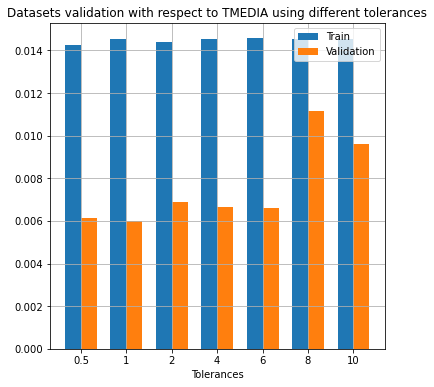

In [22]:
# Higher-order function, which creates the `days_to_select` function.
# It takes in input a specific tolerance `t` and it returns the corresponding `days_to_select` function.
def create_daysToSelect_function(t):
    # `days_to_select` is a lambda function which decides whether to select `day_current_year` for `day` or not
    # It returns True if `day_current_year` has a similar TMEDIA with respect to `day` (i.e. the difference is less than `t`)
    return (lambda day, df, day_current_year, df_current_year : abs(df_current_year["TMEDIA °C"].loc[day] -
                                                                    df_current_year["TMEDIA °C"].loc[day_current_year])<t)

tolerances = [0.5, 1, 2, 4, 6, 8, 10] # Possible tolerances
dataset_list = [tsp.add_current_year_statistics(df=df_mean_best, df_current_year=df_mean_meteo, 
                                                days_to_select = create_daysToSelect_function(t), # Create `days_to_select`
                                                columns_to_select=["mean"], # Only the "mean" column is of interest
                                                y_col="mean", scale_y=True)[1:] 
                for t in tolerances]
xvalues = [str(t) for t in tolerances]

model = ms.PolynomialRegression()
hyperparameter="degree"
hyperparameter_values=[1,2,3]

(datasets_train_val_score, datasets_best_hyperparameter_value,
 best_index, test_score, axes) = ms.datasets_hyperparameter_validation(dataset_list, model, hyperparameter, 
                                                 hyperparameter_values, time_series=True, plot=True, plot_train=True, 
                                                 xvalues=xvalues, xlabel="Tolerances",
                                                 title="Datasets validation with respect to TMEDIA using different tolerances")

In [23]:
print("Index best dataset:", str(best_index), "; Tolerance:", str(xvalues[best_index]))
print("Best polynomial grade:", str(datasets_best_hyperparameter_value[best_index]))
print("Validation score:", str(datasets_train_val_score[best_index,1]))
print("Test score:", str(test_score))

Index best dataset: 1 ; Tolerance: 1
Best polynomial grade: 1
Validation score: 0.005973842073088957
Test score: 0.014607561953069621


*The validation score has not decreased.*

**T MIN**

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-08
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-18
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-25
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

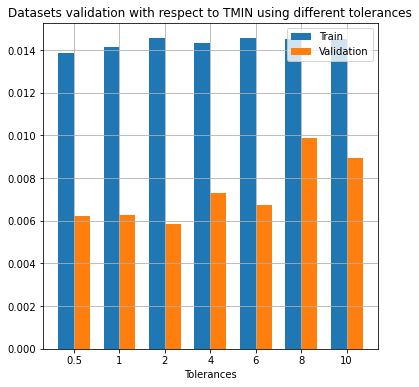

In [25]:
# Higher-order function, which creates the `days_to_select` function.
# It takes in input a specific tolerance `t` and it returns the corresponding `days_to_select` function.
def create_daysToSelect_function(t):
    # `days_to_select` is a lambda function which decides whether to select `day_current_year` for `day` or not.
    # It returns True if `day_current_year` has a similar TMIN with respect to `day` (i.e. the difference is less than `t`).
    return (lambda day, df, day_current_year, df_current_year : abs(df_current_year["TMIN °C"].loc[day] -
                                                                    df_current_year["TMIN °C"].loc[day_current_year])<t)

tolerances = [0.5, 1, 2, 4, 6, 8, 10] # Possible tolerances
dataset_list = [tsp.add_current_year_statistics(df=df_mean_best, df_current_year=df_mean_meteo, 
                                                days_to_select = create_daysToSelect_function(t), # Create `days_to_select`
                                                columns_to_select=["mean"], # Only the "mean" column is of interest
                                                y_col="mean", scale_y=True)[1:] 
                for t in tolerances]
xvalues = [str(t) for t in tolerances]

model = ms.PolynomialRegression()
hyperparameter="degree"
hyperparameter_values=[1,2,3]

(datasets_train_val_score, datasets_best_hyperparameter_value,
 best_index, test_score, axes) = ms.datasets_hyperparameter_validation(dataset_list, model, hyperparameter, 
                                                 hyperparameter_values, time_series=True, plot=True, plot_train=True, 
                                                 xvalues=xvalues, xlabel="Tolerances",
                                                 title="Datasets validation with respect to TMIN using different tolerances")

In [26]:
print("Index best dataset:", str(best_index), "; Tolerance:", str(xvalues[best_index]))
print("Best polynomial grade:", str(datasets_best_hyperparameter_value[best_index]))
print("Validation score:", str(datasets_train_val_score[best_index,1]))
print("Test score:", str(test_score))

Index best dataset: 2 ; Tolerance: 2
Best polynomial grade: 1
Validation score: 0.00585275308627106
Test score: 0.013347518888114866


*The validation score has not decreased.*

**T MAX**

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-29
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-31
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-03
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-04
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

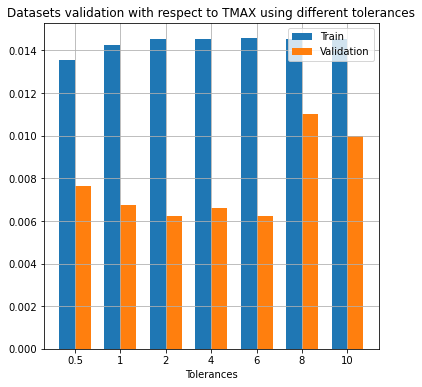

In [27]:
# Higher-order function, which creates the `days_to_select` function.
# It takes in input a specific tolerance `t` and it returns the corresponding `days_to_select` function.
def create_daysToSelect_function(t):
    # `days_to_select` is a lambda function which decides whether to select `day_current_year` for `day` or not.
    # It returns True if `day_current_year` has a similar TMAX with respect to `day` (i.e. the difference is less than `t`).
    return (lambda day, df, day_current_year, df_current_year : abs(df_current_year["TMAX °C"].loc[day] -
                                                                    df_current_year["TMAX °C"].loc[day_current_year])<t)

tolerances = [0.5, 1, 2, 4, 6, 8, 10] # Possible tolerances
dataset_list = [tsp.add_current_year_statistics(df=df_mean_best, df_current_year=df_mean_meteo, 
                                                days_to_select = create_daysToSelect_function(t), # Create `days_to_select`
                                                columns_to_select=["mean"], # Only the "mean" column is of interest
                                                y_col="mean", scale_y=True)[1:] 
                for t in tolerances]
xvalues = [str(t) for t in tolerances]

model = ms.PolynomialRegression()
hyperparameter="degree"
hyperparameter_values=[1,2,3]

(datasets_train_val_score, datasets_best_hyperparameter_value,
 best_index, test_score, axes) = ms.datasets_hyperparameter_validation(dataset_list, model, hyperparameter, 
                                                 hyperparameter_values, time_series=True, plot=True, plot_train=True, 
                                                 xvalues=xvalues, xlabel="Tolerances",
                                                 title="Datasets validation with respect to TMAX using different tolerances")

In [28]:
print("Index best dataset:", str(best_index), "; Tolerance:", str(xvalues[best_index]))
print("Best polynomial grade:", str(datasets_best_hyperparameter_value[best_index]))
print("Validation score:", str(datasets_train_val_score[best_index,1]))
print("Test score:", str(test_score))

Index best dataset: 2 ; Tolerance: 2
Best polynomial grade: 1
Validation score: 0.0062306936890401425
Test score: 0.015206419159237023


*The validation score has not decreased.*

**VENTO MEDIA**

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-09
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-18
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-19
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-20
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-04
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-05
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-04
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))


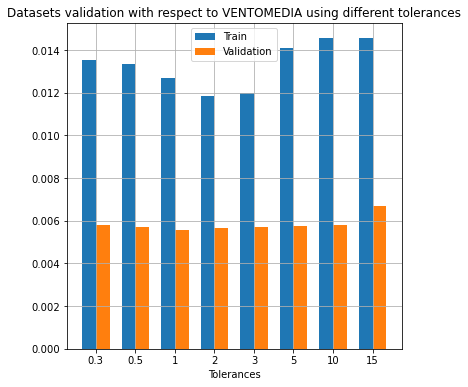

In [29]:
# Higher-order function, which creates the `days_to_select` function.
# It takes in input a specific tolerance `t` and it returns the corresponding `days_to_select` function.
def create_daysToSelect_function(t):
    # `days_to_select` is a lambda function which decides whether to select `day_current_year` for `day` or not.
    # It returns True if `day_current_year` has a similar VENTOMEDIA with respect to `day` (i.e. the difference is less than 
    # `t`).
    return (lambda day, df, day_current_year, df_current_year : abs(df_current_year["VENTOMEDIA km/h"].loc[day] -
                                                                    df_current_year["VENTOMEDIA km/h"].loc[day_current_year])<t)

tolerances = [0.3, 0.5, 1, 2, 3, 5, 10, 15] # Possible tolerances
dataset_list = [tsp.add_current_year_statistics(df=df_mean_best, df_current_year=df_mean_meteo, 
                                                days_to_select = create_daysToSelect_function(t), # Create `days_to_select`
                                                columns_to_select=["mean"], # Only the "mean" column is of interest
                                                y_col="mean", scale_y=True)[1:] 
                for t in tolerances]
xvalues = [str(t) for t in tolerances]

model = ms.PolynomialRegression()
hyperparameter="degree"
hyperparameter_values=[1,2,3]

(datasets_train_val_score, datasets_best_hyperparameter_value,
 best_index, test_score, axes) = ms.datasets_hyperparameter_validation(dataset_list, model, hyperparameter, 
                                             hyperparameter_values, time_series=True, plot=True, plot_train=True, 
                                             xvalues=xvalues, xlabel="Tolerances",
                                             title="Datasets validation with respect to VENTOMEDIA using different tolerances")

In [30]:
print("Index best dataset:", str(best_index), "; Tolerance:", str(xvalues[best_index]))
print("Best polynomial grade:", str(datasets_best_hyperparameter_value[best_index]))
print("Validation score:", str(datasets_train_val_score[best_index,1]))
print("Test score:", str(test_score))

Index best dataset: 2 ; Tolerance: 1
Best polynomial grade: 1
Validation score: 0.00557915970824468
Test score: 0.0070760470805857805


*The validation score has decreased!*

**VENTO MAX**

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-09
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-13
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-18
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-19
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-05-11
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-06-04
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-07-07
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-08-30
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-11
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-27
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-03
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-04-14
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

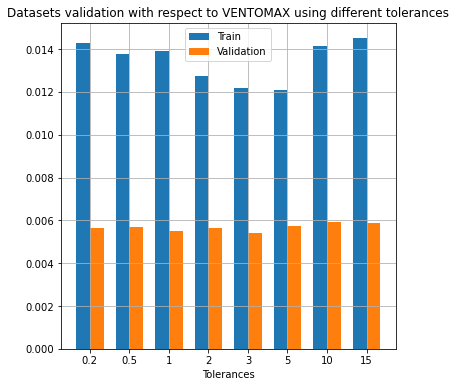

In [31]:
# Higher-order function, which creates the `days_to_select` function.
# It takes in input a specific tolerance `t` and it returns the corresponding `days_to_select` function.
def create_daysToSelect_function(t):
    # `days_to_select` is a lambda function which decides whether to select `day_current_year` for `day` or not.
    # It returns True if `day_current_year` has a similar VENTOMAX with respect to `day` (i.e. the difference is less than `t`).
    return (lambda day, df, day_current_year, df_current_year : abs(df_current_year["VENTOMAX km/h"].loc[day] -
                                                                    df_current_year["VENTOMAX km/h"].loc[day_current_year])<t)

tolerances = [0.2, 0.5, 1, 2, 3, 5, 10, 15] # Possible tolerances
dataset_list = [tsp.add_current_year_statistics(df=df_mean_best, df_current_year=df_mean_meteo, 
                                                days_to_select = create_daysToSelect_function(t), # Create `days_to_select`
                                                columns_to_select=["mean"], # Only the "mean" column is of interest
                                                y_col="mean", scale_y=True)[1:] 
                for t in tolerances]
xvalues = [str(t) for t in tolerances]

model = ms.PolynomialRegression()
hyperparameter="degree"
hyperparameter_values=[1,2,3]

(datasets_train_val_score, datasets_best_hyperparameter_value,
 best_index, test_score, axes) = ms.datasets_hyperparameter_validation(dataset_list, model, hyperparameter, 
                                             hyperparameter_values, time_series=True, plot=True, plot_train=True, 
                                             xvalues=xvalues, xlabel="Tolerances",
                                             title="Datasets validation with respect to VENTOMAX using different tolerances")

In [32]:
print("Index best dataset:", str(best_index), "; Tolerance:", str(xvalues[best_index]))
print("Best polynomial grade:", str(datasets_best_hyperparameter_value[best_index]))
print("Validation score:", str(datasets_train_val_score[best_index,1]))
print("Test score:", str(test_score))

Index best dataset: 4 ; Tolerance: 3
Best polynomial grade: 1
Validation score: 0.005414068416456359
Test score: 0.0071246954594039215


*The validation score has decreased!*

**PRESSIONE**

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-09
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-10
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-11
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-13
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-07
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-09
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-13
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-16
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-10
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-17
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-29
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-10
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-18
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-20
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

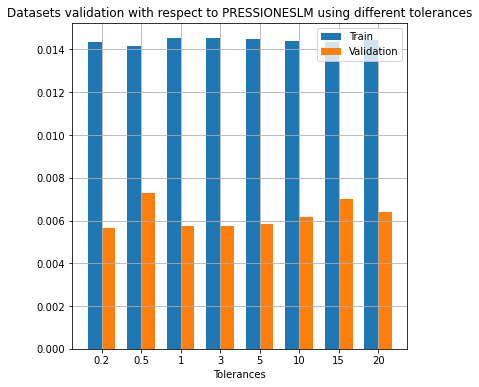

In [33]:
# Higher-order function, which creates the `days_to_select` function.
# It takes in input a specific tolerance `t` and it returns the corresponding `days_to_select` function.
def create_daysToSelect_function(t):
    # `days_to_select` is a lambda function which decides whether to select `day_current_year` for `day` or not.
    # It returns True if `day_current_year` has a similar PRESSIONESLM with respect to `day` (i.e. the difference is less than 
    #`t`).
    return (lambda day, df, day_current_year, df_current_year : abs(df_current_year["PRESSIONESLM mb"].loc[day] -
                                                                    df_current_year["PRESSIONESLM mb"].loc[day_current_year])<t)

tolerances = [0.2, 0.5, 1, 3, 5, 10, 15, 20] # Possible tolerances
dataset_list = [tsp.add_current_year_statistics(df=df_mean_best, df_current_year=df_mean_meteo, 
                                                days_to_select = create_daysToSelect_function(t), # Create `days_to_select`
                                                columns_to_select=["mean"], # Only the "mean" column is of interest
                                                y_col="mean", scale_y=True)[1:] 
                for t in tolerances]
xvalues = [str(t) for t in tolerances]

model = ms.PolynomialRegression()
hyperparameter="degree"
hyperparameter_values=[1,2,3]

(datasets_train_val_score, datasets_best_hyperparameter_value,
 best_index, test_score, axes) = ms.datasets_hyperparameter_validation(dataset_list, model, hyperparameter, 
                                         hyperparameter_values, time_series=True, plot=True, plot_train=True, 
                                         xvalues=xvalues, xlabel="Tolerances",
                                         title="Datasets validation with respect to PRESSIONESLM using different tolerances")

In [34]:
print("Index best dataset:", str(best_index), "; Tolerance:", str(xvalues[best_index]))
print("Best polynomial grade:", str(datasets_best_hyperparameter_value[best_index]))
print("Validation score:", str(datasets_train_val_score[best_index,1]))
print("Test score:", str(test_score))

Index best dataset: 0 ; Tolerance: 0.2
Best polynomial grade: 1
Validation score: 0.005665634068097989
Test score: 0.01260854713712688


*The validation score has decreased!*

**UMIDITA**

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-10
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-11
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-12
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-14
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-04-20
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-04-22
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-05-04
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-05-21
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-05-21
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-10-23
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-11-16
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-03
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-20
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-05
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-05
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-05
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))


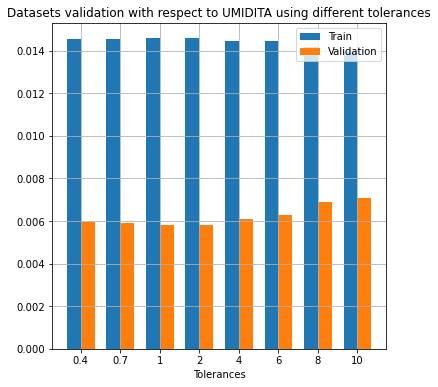

In [35]:
# Higher-order function, which creates the `days_to_select` function.
# It takes in input a specific tolerance `t` and it returns the corresponding `days_to_select` function.
def create_daysToSelect_function(t):
    # `days_to_select` is a lambda function which decides whether to select `day_current_year` for `day` or not.
    # It returns True if `day_current_year` has a similar UMIDITA with respect to `day` (i.e. the difference is less than `t`).
    return (lambda day, df, day_current_year, df_current_year : abs(df_current_year["UMIDITA %"].loc[day] -
                                                                    df_current_year["UMIDITA %"].loc[day_current_year])<t)

tolerances = [0.4, 0.7, 1, 2, 4, 6, 8, 10] # Possible tolerances
dataset_list = [tsp.add_current_year_statistics(df=df_mean_best, df_current_year=df_mean_meteo, 
                                                days_to_select = create_daysToSelect_function(t), # Create `days_to_select`
                                                columns_to_select=["mean"], # Only the "mean" column is of interest
                                                y_col="mean", scale_y=True)[1:] 
                for t in tolerances]
xvalues = [str(t) for t in tolerances]

model = ms.PolynomialRegression()
hyperparameter="degree"
hyperparameter_values=[1,2,3]

(datasets_train_val_score, datasets_best_hyperparameter_value,
 best_index, test_score, axes) = ms.datasets_hyperparameter_validation(dataset_list, model, hyperparameter, 
                                                 hyperparameter_values, time_series=True, plot=True, plot_train=True, 
                                                 xvalues=xvalues, xlabel="Tolerances",
                                                 title="Datasets validation with respect to UMIDITA using different tolerances")

In [36]:
print("Index best dataset:", str(best_index), "; Tolerance:", str(xvalues[best_index]))
print("Best polynomial grade:", str(datasets_best_hyperparameter_value[best_index]))
print("Validation score:", str(datasets_train_val_score[best_index,1]))
print("Test score:", str(test_score))

Index best dataset: 2 ; Tolerance: 1
Best polynomial grade: 1
Validation score: 0.005827590144634284
Test score: 0.014934800194941403


*The validation score has not decreased.*

**VMEDIA VMAX P**

Trying to use more climatic agents together could be interesting. The three most effective climatic agents are considered, which are VMEDIA, VMAX, P. Each of them is tested with different tolerances: `t1` is the tolerance for VMEDIA, `t2` is the tolerance for VMAX, and `t3` is the tolerance for P. All the possible combinations of tolerances `t1`-`t2`-`t3` are evaluated.

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-10
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-13
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-18
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-19
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-09
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-13
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-15
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-20
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-05-27
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-05-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-05-29
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-06-04
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-07
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-08
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-09
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-10
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-07
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-23
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-25
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-26
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-26
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-27
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-02
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-03
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-10-02
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-10-03
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-10
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-18
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-22
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-23
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-24
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-25
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-30
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-20
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-21
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-10
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-18
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-19
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-20
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-31
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-04-05
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-04-18
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-04-22
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-25
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-26
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-27
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-10
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-11
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-12
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-13
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-06-04
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-06-05
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-06-08
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-07-07
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-04
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-06
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-23
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-25
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-19
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-20
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-22
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-23
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-05-10
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-05-11
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-05-14
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-05-16
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-18
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-20
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-21
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-04
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-05
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-06
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-25
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-26
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-27
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-04
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-11
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-10
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-18
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-26
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-27
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-03
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-03
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-04
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-05
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-06
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-04-09
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-04-12
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-04-14
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-04-15
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-12
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-14
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-15
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-26
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-09-25
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-09-26
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-10-03
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-10
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-26
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-27
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-03
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-25
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-26
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-02
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-03
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-04
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-05
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-26
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-26
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-27
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-03
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-30
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-31
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-04-01
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-04-02
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-05
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-07
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-09
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-10
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-31
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-04-14
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-05-11
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-06-05
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-09-25
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-10
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-18
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-20
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-12
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-20
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-05-11
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-06-04
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-20
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-04
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-04
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))


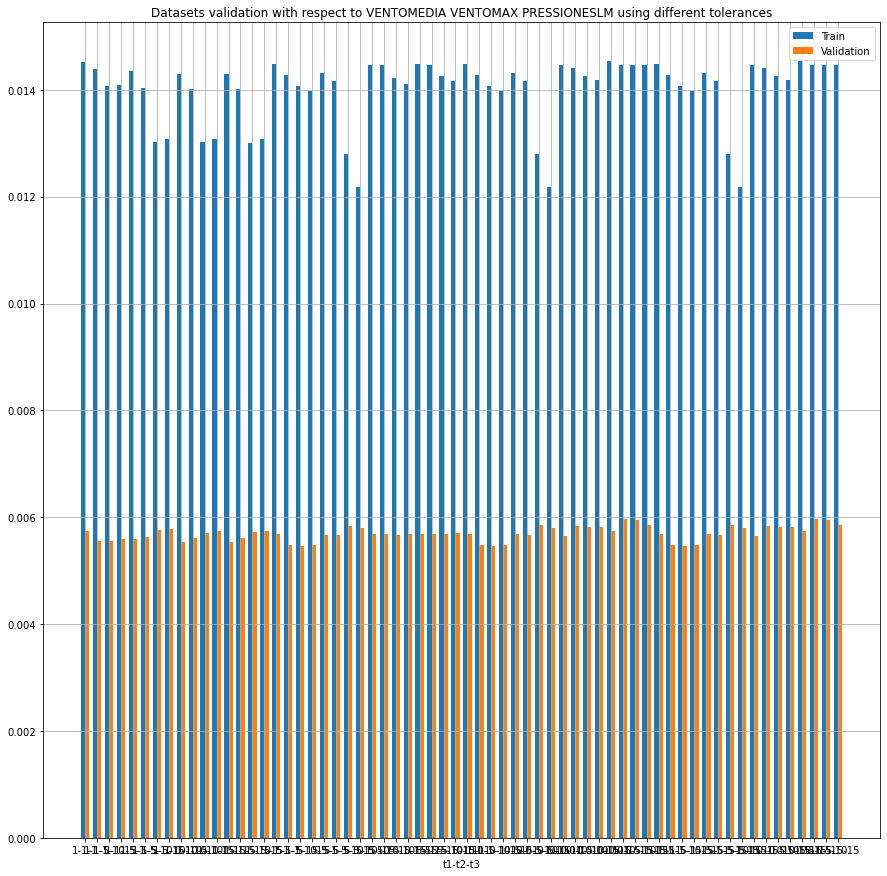

In [37]:
# Higher-order function, which creates the `days_to_select` function.
# It takes in input three specific tolerances `t1-t2-t3` and it returns the corresponding `days_to_select` function.
def create_daysToSelect_function(t1, t2, t3):
    return (lambda day, df, day_current_year, df_current_year : (abs(df_current_year["VENTOMEDIA km/h"].loc[day] - 
                                                                df_current_year["VENTOMEDIA km/h"].loc[day_current_year])<t1 and
                                                                abs(df_current_year["VENTOMAX km/h"].loc[day] -
                                                                  df_current_year["VENTOMAX km/h"].loc[day_current_year])<t2 and
                                                                abs(df_current_year["PRESSIONESLM mb"].loc[day] - 
                                                                 df_current_year["PRESSIONESLM mb"].loc[day_current_year])<t3) )

tolerances = [1, 5, 10, 15] # Possible tolerances
dataset_list = [tsp.add_current_year_statistics(df=df_mean_best, df_current_year=df_mean_meteo, 
                                                days_to_select=create_daysToSelect_function(t1,t2,t3), # Create `days_to_select`
                                                columns_to_select=["mean"], # Only the "mean" column is of interest
                                                y_col="mean", scale_y=True)[1:] 
                for t1 in tolerances for t2 in tolerances for t3 in tolerances]
xvalues = [str(t1)+"-"+str(t2)+"-"+str(t3) for t1 in tolerances for t2 in tolerances for t3 in tolerances]

model = ms.PolynomialRegression()
hyperparameter="degree"
hyperparameter_values=[1,2,3]

(datasets_train_val_score, datasets_best_hyperparameter_value,
 best_index, test_score, axes) = ms.datasets_hyperparameter_validation(dataset_list, model, hyperparameter, 
                        hyperparameter_values, time_series=True, plot=True, plot_train=True, xvalues=xvalues, xlabel="t1-t2-t3",
                        title="Datasets validation with respect to VENTOMEDIA VENTOMAX PRESSIONESLM using different tolerances",
                        figsize=(15,15))

In [38]:
print("Index best dataset:", str(best_index), "; t1-t2-t3:", str(xvalues[best_index]))
print("Best polynomial grade:", str(datasets_best_hyperparameter_value[best_index]))
print("Validation score:", str(datasets_train_val_score[best_index,1]))
print("Test score:", str(test_score))

Index best dataset: 18 ; t1-t2-t3: 5-1-10
Best polynomial grade: 1
Validation score: 0.005454695745022879
Test score: 0.007884025168365652


*The validation score has decreased!*

**Best dataset: VENTO MAX with tolerance=3**

The best alternative is the one with VENTOMAX and with tolerance=3. There is an improvement as compared to the previous dataset: the validation score has decreased from $0.00580$ to $0.00541$.

In [15]:
# `days_to_select` function
days_to_select = lambda day, df, day_current_year, df_current_year : abs(df_current_year["VENTOMAX km/h"].loc[day] -
                                                                      df_current_year["VENTOMAX km/h"].loc[day_current_year])<3
df_mean_best, _, _ = tsp.add_current_year_statistics(df=df_mean_best, df_current_year=df_mean_meteo, 
                                                     days_to_select=days_to_select, columns_to_select=["mean"], y_col="mean", 
                                                     scale_y=True)

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-04
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-11
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))


In [16]:
df_mean_best

mean     mean_1     mean_2     mean_3     mean_4     mean_5  \
Datetime                                                                       
2020-01-08  38.646087  40.759729  26.099399  28.192059  54.887035  55.216906   
2020-01-09  39.866008  38.646087  40.759729  26.099399  28.192059  54.887035   
2020-01-10  63.946840  39.866008  38.646087  40.759729  26.099399  28.192059   
2020-01-11  53.902359  63.946840  39.866008  38.646087  40.759729  26.099399   
2020-01-12  42.199734  53.902359  63.946840  39.866008  38.646087  40.759729   
...               ...        ...        ...        ...        ...        ...   
2020-12-27  14.997987  11.480358  14.695619  28.473515  47.568209  49.143828   
2020-12-28  16.317778  14.997987  11.480358  14.695619  28.473515  47.568209   
2020-12-29  23.536875  16.317778  14.997987  11.480358  14.695619  28.473515   
2020-12-30  22.759021  23.536875  16.317778  14.997987  11.480358  14.695619   
2020-12-31  22.005000  22.759021  23.536875  16.317778  14.997987  11.480358   

               mean_6     mean_7  upTo_6_years_ago_mean  6_years_ago_mean  \
Datetime                                                                    
2020-01-08  56.675791  76.974569              36.287863         71.802620   
2020-01-09  55.216906  56.675791              35.814008         79.803419   
2020-01-10  54.887035  55.216906              36.143744         71.632078   
2020-01-11  28.192059  54.887035              35.806540         79.216124   
2020-01-12  26.099399  28.192059              35.522678         89.111978   
...               ...        ...                    ...               ...   
2020-12-27  43.004333  42.601218              38.902204         17.186082   
2020-12-28  49.143828  43.004333              38.423588         19.039899   
2020-12-29  47.568209  49.143828              37.817480         20.643419   
2020-12-30  28.473515  47.568209              36.864552         19.247014   
2020-12-31  14.695619  28.473515              35.864452         23.937203   

            current_year_mean  
Datetime                       
2020-01-08          56.902806  
2020-01-09          53.860020  
2020-01-10          51.860875  
2020-01-11          53.371621  
2020-01-12          53.430592  
...                       ...  
2020-12-27          21.778933  
2020-12-28          20.635976  
2020-12-29          20.311077  
2020-12-30          24.071164  
2020-12-31          26.838859  

[359 rows x 11 columns]

### Second addition

**VENTO MEDIA**

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-04
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-05
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-11
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-27
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

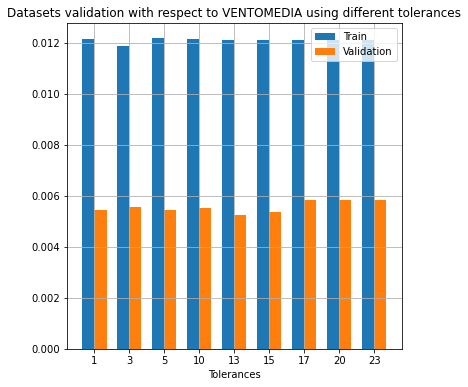

In [17]:
# Higher-order function, which creates the `days_to_select` function.
# It takes in input a specific tolerance `t` and it returns the corresponding `days_to_select` function.
def create_daysToSelect_function(t):
    # `days_to_select` is a lambda function which decides whether to select `day_current_year` for `day` or not.
    # It returns True if `day_current_year` has a similar VENTOMEDIA with respect to `day` (i.e. the difference is less than 
    # `t`).
    return (lambda day, df, day_current_year, df_current_year : abs(df_current_year["VENTOMEDIA km/h"].loc[day] -
                                                                    df_current_year["VENTOMEDIA km/h"].loc[day_current_year])<t)

tolerances =  [1, 3, 5, 10, 13, 15, 17, 20, 23] # Possible tolerances
dataset_list = [tsp.add_current_year_statistics(df=df_mean_best, df_current_year=df_mean_meteo, 
                                                days_to_select = create_daysToSelect_function(t), # Create `days_to_select`
                                                columns_to_select=["mean"], # Only the "mean" column is of interest
                                                y_col="mean", scale_y=True)[1:] 
                for t in tolerances]
xvalues = [str(t) for t in tolerances]

model = ms.PolynomialRegression()
hyperparameter="degree"
hyperparameter_values=[1,2,3]

(datasets_train_val_score, datasets_best_hyperparameter_value,
 best_index, test_score, axes) = ms.datasets_hyperparameter_validation(dataset_list, model, hyperparameter, 
                                             hyperparameter_values, time_series=True, plot=True, plot_train=True, 
                                             xvalues=xvalues, xlabel="Tolerances",
                                             title="Datasets validation with respect to VENTOMEDIA using different tolerances")

In [18]:
print("Index best dataset:", str(best_index), "; Tolerance:", str(xvalues[best_index]))
print("Best polynomial grade:", str(datasets_best_hyperparameter_value[best_index]))
print("Validation score:", str(datasets_train_val_score[best_index,1]))
print("Test score:", str(test_score))

Index best dataset: 4 ; Tolerance: 13
Best polynomial grade: 1
Validation score: 0.005267587773141723
Test score: 0.006624223754847354


*The validation score has decreased!*

**PRESSIONE**

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-09
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-10
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-11
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-13
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-07
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-09
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-13
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-16
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-10
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-17
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-29
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-10
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-18
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-20
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

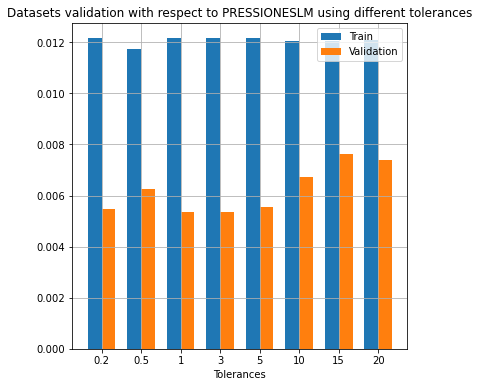

In [19]:
# Higher-order function, which creates the `days_to_select` function.
# It takes in input a specific tolerance `t` and it returns the corresponding `days_to_select` function.
def create_daysToSelect_function(t):
    # `days_to_select` is a lambda function which decides whether to select `day_current_year` for `day` or not.
    # It returns True if `day_current_year` has a similar PRESSIONESLM with respect to `day` (i.e. the difference is less than 
    #`t`).
    return (lambda day, df, day_current_year, df_current_year : abs(df_current_year["PRESSIONESLM mb"].loc[day] -
                                                                    df_current_year["PRESSIONESLM mb"].loc[day_current_year])<t)

tolerances = [0.2, 0.5, 1, 3, 5, 10, 15, 20] # Possible tolerances
dataset_list = [tsp.add_current_year_statistics(df=df_mean_best, df_current_year=df_mean_meteo, 
                                                days_to_select = create_daysToSelect_function(t), # Create `days_to_select`
                                                columns_to_select=["mean"], # Only the "mean" column is of interest
                                                y_col="mean", scale_y=True)[1:] 
                for t in tolerances]
xvalues = [str(t) for t in tolerances]

model = ms.PolynomialRegression()
hyperparameter="degree"
hyperparameter_values=[1,2,3]

(datasets_train_val_score, datasets_best_hyperparameter_value,
 best_index, test_score, axes) = ms.datasets_hyperparameter_validation(dataset_list, model, hyperparameter, 
                                         hyperparameter_values, time_series=True, plot=True, plot_train=True, 
                                         xvalues=xvalues, xlabel="Tolerances",
                                         title="Datasets validation with respect to PRESSIONESLM using different tolerances")

In [20]:
print("Index best dataset:", str(best_index), "; Tolerance:", str(xvalues[best_index]))
print("Best polynomial grade:", str(datasets_best_hyperparameter_value[best_index]))
print("Validation score:", str(datasets_train_val_score[best_index,1]))
print("Test score:", str(test_score))

Index best dataset: 3 ; Tolerance: 3
Best polynomial grade: 1
Validation score: 0.005337474933219499
Test score: 0.0069914173394748525


*The validation score has decreased!*

**Best dataset : VENTO MED with toleranzce=13**

There is an improvement as compared to the previous dataset: the validation score has decreased from $0.00541$ to $0.00527$.

In [21]:
# `days_to_select` function
days_to_select= lambda day, df, day_current_year, df_current_year : abs(df_current_year["VENTOMEDIA km/h"].loc[day] -
                                                                    df_current_year["VENTOMEDIA km/h"].loc[day_current_year])<13
df_mean_best, _, _ = tsp.add_current_year_statistics(df=df_mean_best, df_current_year=df_mean_meteo, 
                                                     days_to_select=days_to_select, columns_to_select=["mean"], y_col="mean", 
                                                     scale_y=True)

In [22]:
df_mean_best

mean     mean_1     mean_2     mean_3     mean_4     mean_5  \
Datetime                                                                       
2020-01-08  38.646087  40.759729  26.099399  28.192059  54.887035  55.216906   
2020-01-09  39.866008  38.646087  40.759729  26.099399  28.192059  54.887035   
2020-01-10  63.946840  39.866008  38.646087  40.759729  26.099399  28.192059   
2020-01-11  53.902359  63.946840  39.866008  38.646087  40.759729  26.099399   
2020-01-12  42.199734  53.902359  63.946840  39.866008  38.646087  40.759729   
...               ...        ...        ...        ...        ...        ...   
2020-12-27  14.997987  11.480358  14.695619  28.473515  47.568209  49.143828   
2020-12-28  16.317778  14.997987  11.480358  14.695619  28.473515  47.568209   
2020-12-29  23.536875  16.317778  14.997987  11.480358  14.695619  28.473515   
2020-12-30  22.759021  23.536875  16.317778  14.997987  11.480358  14.695619   
2020-12-31  22.005000  22.759021  23.536875  16.317778  14.997987  11.480358   

               mean_6     mean_7  upTo_6_years_ago_mean  6_years_ago_mean  \
Datetime                                                                    
2020-01-08  56.675791  76.974569              36.287863         71.802620   
2020-01-09  55.216906  56.675791              35.814008         79.803419   
2020-01-10  54.887035  55.216906              36.143744         71.632078   
2020-01-11  28.192059  54.887035              35.806540         79.216124   
2020-01-12  26.099399  28.192059              35.522678         89.111978   
...               ...        ...                    ...               ...   
2020-12-27  43.004333  42.601218              38.902204         17.186082   
2020-12-28  49.143828  43.004333              38.423588         19.039899   
2020-12-29  47.568209  49.143828              37.817480         20.643419   
2020-12-30  28.473515  47.568209              36.864552         19.247014   
2020-12-31  14.695619  28.473515              35.864452         23.937203   

            current_year_mean  current_year_mean.1  
Datetime                                            
2020-01-08          56.902806            48.400784  
2020-01-09          53.860020            47.181447  
2020-01-10          51.860875            46.368620  
2020-01-11          53.371621            48.126442  
2020-01-12          53.430592            48.651526  
...                       ...                  ...  
2020-12-27          21.778933            25.123485  
2020-12-28          20.635976            25.146538  
2020-12-29          20.311077            25.122216  
2020-12-30          24.071164            25.066962  
2020-12-31          26.838859            25.060622  

[359 rows x 12 columns]

### Third addition

**PRESSIONE**

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-09
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-10
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-11
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-13
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-07
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-09
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-13
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-16
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-10
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-17
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-29
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-10
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-18
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-20
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

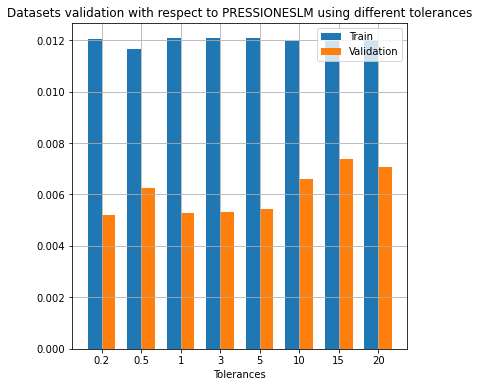

In [23]:
# Higher-order function, which creates the `days_to_select` function.
# It takes in input a specific tolerance `t` and it returns the corresponding `days_to_select` function.
def create_daysToSelect_function(t):
    # `days_to_select` is a lambda function which decides whether to select `day_current_year` for `day` or not.
    # It returns True if `day_current_year` has a similar PRESSIONESLM with respect to `day` (i.e. the difference is less than 
    #`t`).
    return (lambda day, df, day_current_year, df_current_year : abs(df_current_year["PRESSIONESLM mb"].loc[day] -
                                                                    df_current_year["PRESSIONESLM mb"].loc[day_current_year])<t)

tolerances = [0.2, 0.5, 1, 3, 5, 10, 15, 20] # Possible tolerances
dataset_list = [tsp.add_current_year_statistics(df=df_mean_best, df_current_year=df_mean_meteo, 
                                                days_to_select = create_daysToSelect_function(t), # Create `days_to_select`
                                                columns_to_select=["mean"], # Only the "mean" column is of interest
                                                y_col="mean", scale_y=True)[1:] 
                for t in tolerances]
xvalues = [str(t) for t in tolerances]

model = ms.PolynomialRegression()
hyperparameter="degree"
hyperparameter_values=[1,2,3]

(datasets_train_val_score, datasets_best_hyperparameter_value,
 best_index, test_score, axes) = ms.datasets_hyperparameter_validation(dataset_list, model, hyperparameter, 
                                         hyperparameter_values, time_series=True, plot=True, plot_train=True, 
                                         xvalues=xvalues, xlabel="Tolerances",
                                         title="Datasets validation with respect to PRESSIONESLM using different tolerances")

In [24]:
print("Index best dataset:", str(best_index), "; Tolerance:", str(xvalues[best_index]))
print("Best polynomial grade:", str(datasets_best_hyperparameter_value[best_index]))
print("Validation score:", str(datasets_train_val_score[best_index,1]))
print("Test score:", str(test_score))

Index best dataset: 0 ; Tolerance: 0.2
Best polynomial grade: 1
Validation score: 0.005221659150174389
Test score: 0.006919093386128838


*The validation score has decreased!*

**Best dataset: PRESSIONE with tolerance=0.2**

There is an improvement as compared to the previous dataset: the validation score has decreased from $0.00527$ to $0.00522$.

In [25]:
days_to_select = lambda day, df, day_current_year, df_current_year : abs(df_current_year["PRESSIONESLM mb"].loc[day] -
                                                                   df_current_year["PRESSIONESLM mb"].loc[day_current_year])<0.2
df_mean_best, X, y = tsp.add_current_year_statistics(df=df_mean_best, df_current_year=df_mean_meteo, 
                                                     days_to_select=days_to_select, columns_to_select=["mean"], y_col="mean", 
                                                     scale_y=True)

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-09
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-10
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-11
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-13
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-17
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-20
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-24
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-25
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

In [26]:
df_mean_best

mean     mean_1     mean_2     mean_3     mean_4     mean_5  \
Datetime                                                                       
2020-01-08  38.646087  40.759729  26.099399  28.192059  54.887035  55.216906   
2020-01-09  39.866008  38.646087  40.759729  26.099399  28.192059  54.887035   
2020-01-10  63.946840  39.866008  38.646087  40.759729  26.099399  28.192059   
2020-01-11  53.902359  63.946840  39.866008  38.646087  40.759729  26.099399   
2020-01-12  42.199734  53.902359  63.946840  39.866008  38.646087  40.759729   
...               ...        ...        ...        ...        ...        ...   
2020-12-27  14.997987  11.480358  14.695619  28.473515  47.568209  49.143828   
2020-12-28  16.317778  14.997987  11.480358  14.695619  28.473515  47.568209   
2020-12-29  23.536875  16.317778  14.997987  11.480358  14.695619  28.473515   
2020-12-30  22.759021  23.536875  16.317778  14.997987  11.480358  14.695619   
2020-12-31  22.005000  22.759021  23.536875  16.317778  14.997987  11.480358   

               mean_6     mean_7  upTo_6_years_ago_mean  6_years_ago_mean  \
Datetime                                                                    
2020-01-08  56.675791  76.974569              36.287863         71.802620   
2020-01-09  55.216906  56.675791              35.814008         79.803419   
2020-01-10  54.887035  55.216906              36.143744         71.632078   
2020-01-11  28.192059  54.887035              35.806540         79.216124   
2020-01-12  26.099399  28.192059              35.522678         89.111978   
...               ...        ...                    ...               ...   
2020-12-27  43.004333  42.601218              38.902204         17.186082   
2020-12-28  49.143828  43.004333              38.423588         19.039899   
2020-12-29  47.568209  49.143828              37.817480         20.643419   
2020-12-30  28.473515  47.568209              36.864552         19.247014   
2020-12-31  14.695619  28.473515              35.864452         23.937203   

            current_year_mean  current_year_mean.1  current_year_mean.2  
Datetime                                                                 
2020-01-08          56.902806            48.400784            76.974569  
2020-01-09          53.860020            47.181447            47.181447  
2020-01-10          51.860875            46.368620            46.368620  
2020-01-11          53.371621            48.126442            48.126442  
2020-01-12          53.430592            48.651526            53.902359  
...                       ...                  ...                  ...  
2020-12-27          21.778933            25.123485            14.463473  
2020-12-28          20.635976            25.146538            25.146538  
2020-12-29          20.311077            25.122216            25.122216  
2020-12-30          24.071164            25.066962            25.117861  
2020-12-31          26.838859            25.060622            16.131590  

[359 rows x 13 columns]

### Fourth addition

**VMEDIA VMAX P**

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-10
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-13
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-18
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-19
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-09
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-13
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-15
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-20
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-05-29
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-06-04
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-06-05
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-06-06
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-12
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-14
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-15
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-25
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-04-14
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-04-20
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-05-11
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-05-23
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-04-14
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-05-23
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-07-03
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-07-24
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-03
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-04
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-05
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-04-22
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-04-26
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-05-11
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-05-26
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-06
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-23
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-25
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-09-26
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-19
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-20
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-22
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-25
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-08-30
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-09-26
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-10-01
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-10-02
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-09-26
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-21
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-26
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-27
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-01
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-11-22
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-03
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-05
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-07
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-05
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-06
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-11
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-27
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-29
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-01
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-02
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-03
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-07-07
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-07-24
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-08-30
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-09-25
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-13
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-25
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-26
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-27
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-04-14
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-09-25
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-18
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-21
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-09
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-13
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-23
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-24
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-26
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-27
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-03
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-26
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-02
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-06
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-11
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-12
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-13
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-19
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-04-15
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-04-18
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-04-25
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-04-26
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-26
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-27
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-29
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-10
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-27
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-18
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-27
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-03
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-04
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-25
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-26
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-02
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-03-03
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-04
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-05
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-26
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-26
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-27
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-03
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-04-01
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-04-02
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-04-09
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-04-12
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-09
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-10
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-12
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-14
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-05-11
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-06-05
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-09-25
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-09-26
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-21
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-22
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-26
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-27
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-04
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-05
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-11
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-25
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-12-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-20
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-01-28
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-04
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\li

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-04
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))


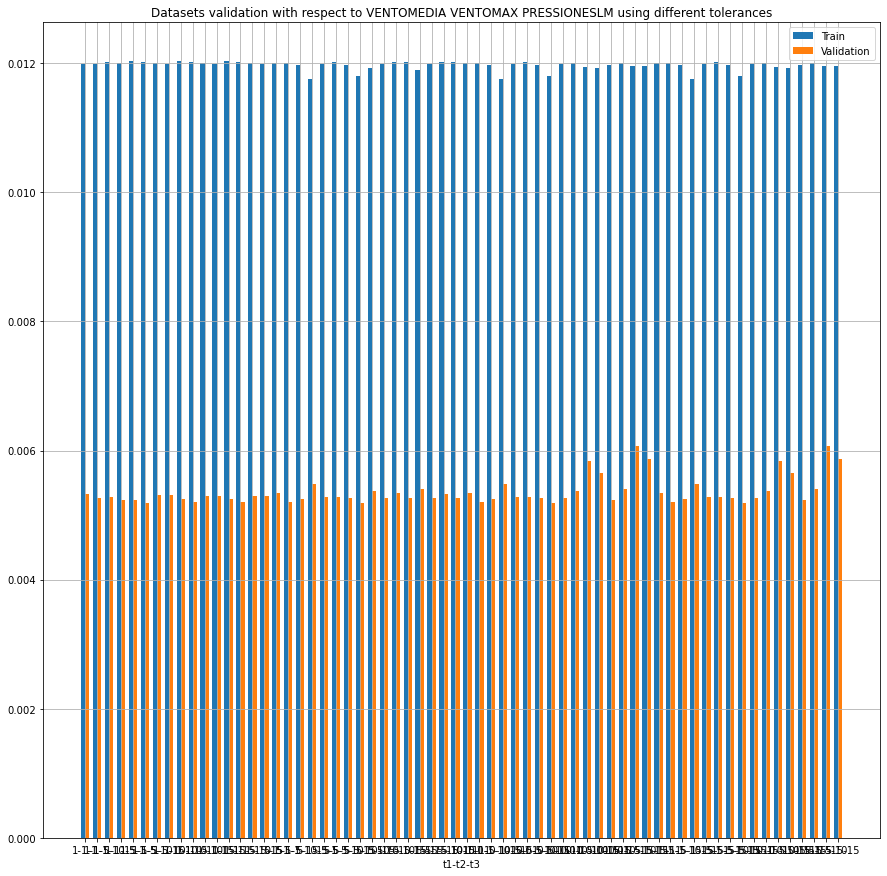

In [27]:
# Higher-order function, which creates the `days_to_select` function.
# It takes in input three specific tolerances `t1-t2-t3` and it returns the corresponding `days_to_select` function.
def create_daysToSelect_function(t1, t2, t3):
    return (lambda day, df, day_current_year, df_current_year : (abs(df_current_year["VENTOMEDIA km/h"].loc[day] - 
                                                                df_current_year["VENTOMEDIA km/h"].loc[day_current_year])<t1 and
                                                                abs(df_current_year["VENTOMAX km/h"].loc[day] -
                                                                  df_current_year["VENTOMAX km/h"].loc[day_current_year])<t2 and
                                                                abs(df_current_year["PRESSIONESLM mb"].loc[day] - 
                                                                 df_current_year["PRESSIONESLM mb"].loc[day_current_year])<t3) )

tolerances = [1, 5, 10, 15] # Possible tolerances
dataset_list = [tsp.add_current_year_statistics(df=df_mean_best, df_current_year=df_mean_meteo, 
                                                days_to_select=create_daysToSelect_function(t1,t2,t3), # Create `days_to_select`
                                                columns_to_select=["mean"], # Only the "mean" column is of interest
                                                y_col="mean", scale_y=True)[1:] 
                for t1 in tolerances for t2 in tolerances for t3 in tolerances]
xvalues = [str(t1)+"-"+str(t2)+"-"+str(t3) for t1 in tolerances for t2 in tolerances for t3 in tolerances]

model = ms.PolynomialRegression()
hyperparameter="degree"
hyperparameter_values=[1,2,3]

(datasets_train_val_score, datasets_best_hyperparameter_value,
 best_index, test_score, axes) = ms.datasets_hyperparameter_validation(dataset_list, model, hyperparameter, 
                        hyperparameter_values, time_series=True, plot=True, plot_train=True, xvalues=xvalues, xlabel="t1-t2-t3",
                        title="Datasets validation with respect to VENTOMEDIA VENTOMAX PRESSIONESLM using different tolerances",
                        figsize=(15,15))

In [28]:
print("Index best dataset:", str(best_index), "; t1-t2-t3:", str(xvalues[best_index]))
print("Best polynomial grade:", str(datasets_best_hyperparameter_value[best_index]))
print("Validation score:", str(datasets_train_val_score[best_index,1]))
print("Test score:", str(test_score))

Index best dataset: 23 ; t1-t2-t3: 5-5-15
Best polynomial grade: 1
Validation score: 0.00518555388716895
Test score: 0.00724853609009831


*The validation score has decreased!*

**Best dataset: tolerances 5-5-15**

There is an improvement as compared to the previous dataset: the validation score has decreased from $0.00522$ to $0.00518$.

In [29]:
days_to_select = lambda day, df, day_current_year, df_current_year : (abs(df_current_year["VENTOMEDIA km/h"].loc[day] -
                                                                 df_current_year["VENTOMEDIA km/h"].loc[day_current_year])<5 and
                                                                 abs(df_current_year["VENTOMAX km/h"].loc[day] -
                                                                 df_current_year["VENTOMAX km/h"].loc[day_current_year])<5 and
                                                                 abs(df_current_year["PRESSIONESLM mb"].loc[day] -
                                                                 df_current_year["PRESSIONESLM mb"].loc[day_current_year])<15) 
df_mean_best, X, y = tsp.add_current_year_statistics(df=df_mean_best, df_current_year=df_mean_meteo, 
                                                     days_to_select=days_to_select, columns_to_select=["mean"], y_col="mean", 
                                                     scale_y=True)

C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-04
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))
C:\Users\Enrico\anaconda3\lib\site-packages\timeSeries_processing.py:871: UserWarning: No current year days have been found for the day 2020-02-11
  warnings.warn("No current year days have been found for the day " + day.strftime('%Y-%m-%d'))


In [30]:
df_mean_best

mean     mean_1     mean_2     mean_3     mean_4     mean_5  \
Datetime                                                                       
2020-01-08  38.646087  40.759729  26.099399  28.192059  54.887035  55.216906   
2020-01-09  39.866008  38.646087  40.759729  26.099399  28.192059  54.887035   
2020-01-10  63.946840  39.866008  38.646087  40.759729  26.099399  28.192059   
2020-01-11  53.902359  63.946840  39.866008  38.646087  40.759729  26.099399   
2020-01-12  42.199734  53.902359  63.946840  39.866008  38.646087  40.759729   
...               ...        ...        ...        ...        ...        ...   
2020-12-27  14.997987  11.480358  14.695619  28.473515  47.568209  49.143828   
2020-12-28  16.317778  14.997987  11.480358  14.695619  28.473515  47.568209   
2020-12-29  23.536875  16.317778  14.997987  11.480358  14.695619  28.473515   
2020-12-30  22.759021  23.536875  16.317778  14.997987  11.480358  14.695619   
2020-12-31  22.005000  22.759021  23.536875  16.317778  14.997987  11.480358   

               mean_6     mean_7  upTo_6_years_ago_mean  6_years_ago_mean  \
Datetime                                                                    
2020-01-08  56.675791  76.974569              36.287863         71.802620   
2020-01-09  55.216906  56.675791              35.814008         79.803419   
2020-01-10  54.887035  55.216906              36.143744         71.632078   
2020-01-11  28.192059  54.887035              35.806540         79.216124   
2020-01-12  26.099399  28.192059              35.522678         89.111978   
...               ...        ...                    ...               ...   
2020-12-27  43.004333  42.601218              38.902204         17.186082   
2020-12-28  49.143828  43.004333              38.423588         19.039899   
2020-12-29  47.568209  49.143828              37.817480         20.643419   
2020-12-30  28.473515  47.568209              36.864552         19.247014   
2020-12-31  14.695619  28.473515              35.864452         23.937203   

            current_year_mean  current_year_mean.1  current_year_mean.2  \
Datetime                                                                  
2020-01-08          56.902806            48.400784            76.974569   
2020-01-09          53.860020            47.181447            47.181447   
2020-01-10          51.860875            46.368620            46.368620   
2020-01-11          53.371621            48.126442            48.126442   
2020-01-12          53.430592            48.651526            53.902359   
...                       ...                  ...                  ...   
2020-12-27          21.778933            25.123485            14.463473   
2020-12-28          20.635976            25.146538            25.146538   
2020-12-29          20.311077            25.122216            25.122216   
2020-12-30          24.071164            25.066962            25.117861   
2020-12-31          26.838859            25.060622            16.131590   

            current_year_mean.3  
Datetime                         
2020-01-08            51.768905  
2020-01-09            53.860020  
2020-01-10            51.860875  
2020-01-11            50.341374  
2020-01-12            50.697472  
...                         ...  
2020-12-27            19.177966  
2020-12-28            17.899923  
2020-12-29            18.574172  
2020-12-30            20.902818  
2020-12-31            24.139165  

[359 rows x 14 columns]

# CONCLUSIONS

The best dataset contains $14$ features.

In [31]:
df_mean_best.info()
df_mean_best

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 359 entries, 2020-01-08 to 2020-12-31
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   mean                   359 non-null    float64
 1   mean_1                 359 non-null    float64
 2   mean_2                 359 non-null    float64
 3   mean_3                 359 non-null    float64
 4   mean_4                 359 non-null    float64
 5   mean_5                 359 non-null    float64
 6   mean_6                 359 non-null    float64
 7   mean_7                 359 non-null    float64
 8   upTo_6_years_ago_mean  359 non-null    float64
 9   6_years_ago_mean       359 non-null    float64
 10  current_year_mean      359 non-null    float64
 11  current_year_mean.1    359 non-null    float64
 12  current_year_mean.2    359 non-null    float64
 13  current_year_mean.3    359 non-null    float64
dtypes: float64(14)
memory usage: 50.2 KB


mean     mean_1     mean_2     mean_3     mean_4     mean_5  \
Datetime                                                                       
2020-01-08  38.646087  40.759729  26.099399  28.192059  54.887035  55.216906   
2020-01-09  39.866008  38.646087  40.759729  26.099399  28.192059  54.887035   
2020-01-10  63.946840  39.866008  38.646087  40.759729  26.099399  28.192059   
2020-01-11  53.902359  63.946840  39.866008  38.646087  40.759729  26.099399   
2020-01-12  42.199734  53.902359  63.946840  39.866008  38.646087  40.759729   
...               ...        ...        ...        ...        ...        ...   
2020-12-27  14.997987  11.480358  14.695619  28.473515  47.568209  49.143828   
2020-12-28  16.317778  14.997987  11.480358  14.695619  28.473515  47.568209   
2020-12-29  23.536875  16.317778  14.997987  11.480358  14.695619  28.473515   
2020-12-30  22.759021  23.536875  16.317778  14.997987  11.480358  14.695619   
2020-12-31  22.005000  22.759021  23.536875  16.317778  14.997987  11.480358   

               mean_6     mean_7  upTo_6_years_ago_mean  6_years_ago_mean  \
Datetime                                                                    
2020-01-08  56.675791  76.974569              36.287863         71.802620   
2020-01-09  55.216906  56.675791              35.814008         79.803419   
2020-01-10  54.887035  55.216906              36.143744         71.632078   
2020-01-11  28.192059  54.887035              35.806540         79.216124   
2020-01-12  26.099399  28.192059              35.522678         89.111978   
...               ...        ...                    ...               ...   
2020-12-27  43.004333  42.601218              38.902204         17.186082   
2020-12-28  49.143828  43.004333              38.423588         19.039899   
2020-12-29  47.568209  49.143828              37.817480         20.643419   
2020-12-30  28.473515  47.568209              36.864552         19.247014   
2020-12-31  14.695619  28.473515              35.864452         23.937203   

            current_year_mean  current_year_mean.1  current_year_mean.2  \
Datetime                                                                  
2020-01-08          56.902806            48.400784            76.974569   
2020-01-09          53.860020            47.181447            47.181447   
2020-01-10          51.860875            46.368620            46.368620   
2020-01-11          53.371621            48.126442            48.126442   
2020-01-12          53.430592            48.651526            53.902359   
...                       ...                  ...                  ...   
2020-12-27          21.778933            25.123485            14.463473   
2020-12-28          20.635976            25.146538            25.146538   
2020-12-29          20.311077            25.122216            25.122216   
2020-12-30          24.071164            25.066962            25.117861   
2020-12-31          26.838859            25.060622            16.131590   

            current_year_mean.3  
Datetime                         
2020-01-08            51.768905  
2020-01-09            53.860020  
2020-01-10            51.860875  
2020-01-11            50.341374  
2020-01-12            50.697472  
...                         ...  
2020-12-27            19.177966  
2020-12-28            17.899923  
2020-12-29            18.574172  
2020-12-30            20.902818  
2020-12-31            24.139165  

[359 rows x 14 columns]

The best model is the `PolynomialRegression` with `degree`=$1$.

In [34]:
model = ms.PolynomialRegression(degree=1)

On the whole, the validation score has been dramatically decreased: from $0.01523$ of the trivial model to $0.00518$.

**The final test score is $0.00725$.** 

Plots which show the goodness of the predictions.

<AxesSubplot:title={'center':'Actual vs Predicted values'}, xlabel='Days'>

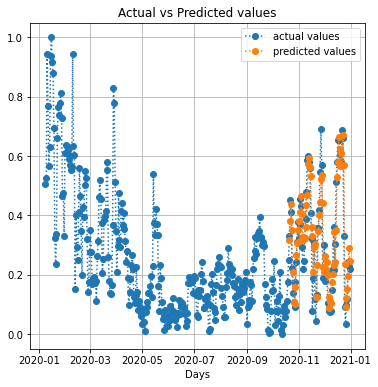

In [35]:
ms.plot_predictions(X ,y ,model, xvalues=df_mean_best.index, xlabel="Days")

<AxesSubplot:title={'center':'Actual vs Predicted values'}, xlabel='Actual values', ylabel='Predicted values'>

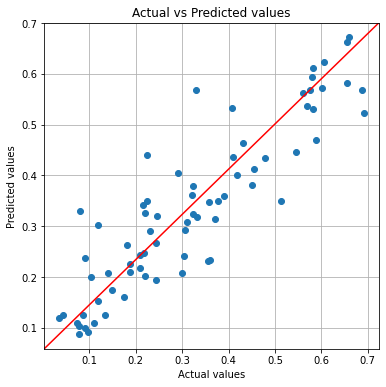

In [36]:
ms.plot_predictions(X ,y ,model, plot_type=1, xvalues=df_mean_best.index, xlabel="Days")